In [4]:
#!pip install easyocr

In [19]:
import os
import glob
import json
import shutil
from multiprocessing import Pool
import matplotlib.pyplot as plt

import easyocr
import numpy as np
import torch

from PIL import Image
from skimage import transform
from skimage.feature import canny
from skimage.color import rgb2gray, gray2rgb

In [5]:
def multi_boxes_mask(image, boxes, pad_crop=5):
    """
    image: np.uint8 (h, w, c)
    boxes: np.int32 (n, 4) ymin, xmin, ymax, xmax
    """
    image = image.copy()
    mask = np.zeros_like(image)
    ih, iw, ic = image.shape
    resize = lambda a, b: transform.resize(a, b, preserve_range=True).astype(np.uint8)
    import matplotlib.pyplot as plt
    
    for box in boxes:
        # image[box[0]: box[2], box[1]: box[3], :] = 0
        box[:2] = np.maximum(box[:2] - pad_crop, 0)
        box[2:] = np.minimum(box[2:] + pad_crop, image.shape[:2])
        
        patch = image[box[0]: box[2], box[1]: box[3], :]
        pure_white = (patch > 253).all(axis=-1).astype(np.uint8)
        mask[box[0]: box[2], box[1]: box[3], :] = pure_white[..., None]
        
        # plt.subplot(2, 1, 1)
        # plt.imshow(patch)
        # plt.subplot(2, 1, 2)
        # plt.imshow(pure_white)
        # plt.colorbar()
        # plt.show()
        
        print('pure_white ', pure_white.sum())
    
    shift = 3
    shifts = [
        (0, 0), (shift, 0), (-shift, 0), (0, shift), (0, -shift),
        (shift, shift), (-shift, shift), (shift, -shift), (-shift, -shift)
    ]
    # shifts = []
    for offset in shifts:
        ox, oy = offset
        _mask = mask.copy()

        slice_y = slice(max(0, 0 + oy), min(ih, ih + oy))
        slice_x = slice(max(0, 0 + ox), min(iw, iw + ox))
        print(slice_y, slice_x)
        _mask = _mask[
            max(0, 0 + oy): min(ih, ih + oy),
            max(0, 0 + ox): min(iw, iw + ox),
            :
        ]
        crop_pad = [
            (max(0, -oy), max(0, oy)),
            (max(0, -ox), max(0, ox)),
            (0, 0)
        ]
        _mask = np.pad(_mask, crop_pad)
        print(
            crop_pad,
            np.abs(_mask - mask).sum(),
            np.abs(mask - np.clip(_mask + mask, 0, 1)).sum()
        )
        mask = np.clip(_mask + mask, 0, 1)

    image = image * (1 - mask) + mask * 255 * 0
    mask *= 255
    return image, mask

def cast_pred_type(pred):
    result = []
    for tup in pred:
        coord, txt, score = tup
        coord = np.array(coord).tolist()
        score = float(score)
        result.append((coord, txt, score))
    return result


def detect(root_dir):
    reader = easyocr.Reader(['en'])
    image_dir = os.path.join(root_dir, 'img')
    images = glob.glob(os.path.join(image_dir, '*.png'))
    images += glob.glob(os.path.join(image_dir, '**', '*.png'))
    # images = images[:3]
    assert len(images) > 9000

    out_json = os.path.join(root_dir, 'ocr.json')
    out_anno = {}
    print(f"Find {len(images)} images!")

    for i, image_path in enumerate(images):
        print(F"{i}/{len(images)}")
        img_name = os.path.basename(image_path)
        pred = reader.readtext(image_path)
        out_anno[img_name] = cast_pred_type(pred)

    with open(out_json, 'w') as f:
        json.dump(out_anno, f)


def point_to_box(anno_json):
    with open(anno_json, 'r') as f:
        ocr_anno = json.load(f)
    
    boxed_anno = {}
    for k, v in ocr_anno.items():
        img_ocr_infos = []
        for txt_info in v:
            coord, txt, score = txt_info
            xmin = min([p[0] for p in coord])
            xmax = max([p[0] for p in coord])
            ymin = min([p[1] for p in coord])
            ymax = max([p[1] for p in coord])
            box = [xmin, ymin, xmax, ymax]
            img_ocr_infos.append([box, txt, score])
        boxed_anno[k] = img_ocr_infos
    
    out_path = anno_json.replace('.json', '.box.json')
    with open(out_path, 'w') as f:
        json.dump(boxed_anno, f)


def _mask_white_txt(args):
    img_name, img_boxes, img_dir, out_dir = args
    img_path = os.path.join(img_dir, img_name)
    out_path = os.path.join(out_dir, img_name)
    
    if os.path.exists(out_path):
        return
    # if img_name != '01487.png':
    #     continue
    
    print(out_path)
    img_boxes = [box_info[0] for box_info in img_boxes]
    if len(img_boxes) > 0:
        boxes = np.asarray(img_boxes, dtype=np.int32)
        # print(boxes)
        boxes = np.concatenate([boxes[:, ::-1][:, 2:], boxes[:,::-1][:, :2]], axis=1)
        # print(boxes)
        # x,y,x,y -> y,x,y,x
        img = np.array(Image.open(img_path).convert('RGB'))
        # res = inpaint_model.inpaint_multi_boxes(img, boxes)
        masked_img, mask = multi_boxes_mask(img, boxes)

        Image.fromarray(masked_img).save(out_path)
        out_path = os.path.join(out_dir, img_name.replace('.png', '.mask.png'))
        Image.fromarray(mask).save(out_path)
    else:
        img = np.asarray(Image.open(img_path).convert('RGB'))
        shutil.copy(img_path, out_path)

        mask = np.zeros_like(img)
        out_path = os.path.join(out_dir, img_name.replace('.png', '.mask.png'))
        Image.fromarray(mask).save(out_path)

def generate_mask(ocr_box_anno, img_dir, out_dir):
    os.makedirs(out_dir, exist_ok=True)
    with open(ocr_box_anno, 'r') as f:
        boxes_anno = json.load(f)

    # for i, (img_name, img_boxes) in enumerate(boxes_anno.items()):
    #     pass
    
    with Pool(16) as pool:
        args = [
            (img_name, img_boxes, img_dir, out_dir)
            for img_name, img_boxes in boxes_anno.items()
        ]
        pool.map(_mask_white_txt, args)


In [17]:
image_name = '01235.png'
data_dir = '/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/'

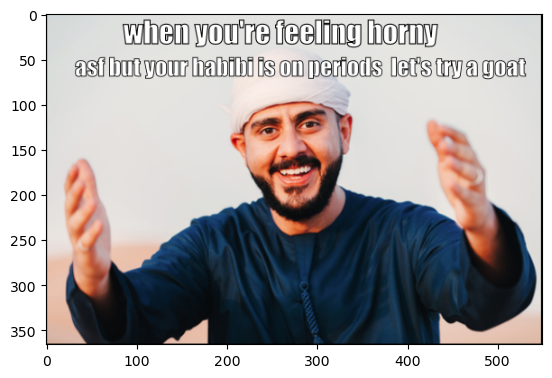

In [24]:
plt.imshow(Image.open(os.path.join(data_dir, 'img', image_name)).convert('RGB'))

In [10]:
# raw EasyOCR detction result
# Создает файл ocr.json в котором находятся распознанный текст и его координаты
detect(data_dir)

Find 10000 images!
0/10000
1/10000
2/10000
3/10000
4/10000
5/10000
6/10000
7/10000
8/10000
9/10000
10/10000
11/10000
12/10000
13/10000
14/10000
15/10000
16/10000
17/10000
18/10000
19/10000
20/10000
21/10000
22/10000
23/10000
24/10000
25/10000
26/10000
27/10000
28/10000
29/10000
30/10000
31/10000
32/10000
33/10000
34/10000
35/10000
36/10000
37/10000
38/10000
39/10000
40/10000
41/10000
42/10000
43/10000
44/10000
45/10000
46/10000
47/10000
48/10000
49/10000
50/10000
51/10000
52/10000
53/10000
54/10000
55/10000
56/10000
57/10000
58/10000
59/10000
60/10000
61/10000
62/10000
63/10000
64/10000
65/10000
66/10000
67/10000
68/10000
69/10000
70/10000
71/10000
72/10000
73/10000
74/10000
75/10000
76/10000
77/10000
78/10000
79/10000
80/10000
81/10000
82/10000
83/10000
84/10000
85/10000
86/10000
87/10000
88/10000
89/10000
90/10000
91/10000
92/10000
93/10000
94/10000
95/10000
96/10000
97/10000
98/10000
99/10000
100/10000
101/10000
102/10000
103/10000
104/10000
105/10000
106/10000
107/10000
108/10000
1

829/10000
830/10000
831/10000
832/10000
833/10000
834/10000
835/10000
836/10000
837/10000
838/10000
839/10000
840/10000
841/10000
842/10000
843/10000
844/10000
845/10000
846/10000
847/10000
848/10000
849/10000
850/10000
851/10000
852/10000
853/10000
854/10000
855/10000
856/10000
857/10000
858/10000
859/10000
860/10000
861/10000
862/10000
863/10000
864/10000
865/10000
866/10000
867/10000
868/10000
869/10000
870/10000
871/10000
872/10000
873/10000
874/10000
875/10000
876/10000
877/10000
878/10000
879/10000
880/10000
881/10000
882/10000
883/10000
884/10000
885/10000
886/10000
887/10000
888/10000
889/10000
890/10000
891/10000
892/10000
893/10000
894/10000
895/10000
896/10000
897/10000
898/10000
899/10000
900/10000
901/10000
902/10000
903/10000
904/10000
905/10000
906/10000
907/10000
908/10000
909/10000
910/10000
911/10000
912/10000
913/10000
914/10000
915/10000
916/10000
917/10000
918/10000
919/10000
920/10000
921/10000
922/10000
923/10000
924/10000
925/10000
926/10000
927/10000
928/10000


1590/10000
1591/10000
1592/10000
1593/10000
1594/10000
1595/10000
1596/10000
1597/10000
1598/10000
1599/10000
1600/10000
1601/10000
1602/10000
1603/10000
1604/10000
1605/10000
1606/10000
1607/10000
1608/10000
1609/10000
1610/10000
1611/10000
1612/10000
1613/10000
1614/10000
1615/10000
1616/10000
1617/10000
1618/10000
1619/10000
1620/10000
1621/10000
1622/10000
1623/10000
1624/10000
1625/10000
1626/10000
1627/10000
1628/10000
1629/10000
1630/10000
1631/10000
1632/10000
1633/10000
1634/10000
1635/10000
1636/10000
1637/10000
1638/10000
1639/10000
1640/10000
1641/10000
1642/10000
1643/10000
1644/10000
1645/10000
1646/10000
1647/10000
1648/10000
1649/10000
1650/10000
1651/10000
1652/10000
1653/10000
1654/10000
1655/10000
1656/10000
1657/10000
1658/10000
1659/10000
1660/10000
1661/10000
1662/10000
1663/10000
1664/10000
1665/10000
1666/10000
1667/10000
1668/10000
1669/10000
1670/10000
1671/10000
1672/10000
1673/10000
1674/10000
1675/10000
1676/10000
1677/10000
1678/10000
1679/10000
1680/10000

2336/10000
2337/10000
2338/10000
2339/10000
2340/10000
2341/10000
2342/10000
2343/10000
2344/10000
2345/10000
2346/10000
2347/10000
2348/10000
2349/10000
2350/10000
2351/10000
2352/10000
2353/10000
2354/10000
2355/10000
2356/10000
2357/10000
2358/10000
2359/10000
2360/10000
2361/10000
2362/10000
2363/10000
2364/10000
2365/10000
2366/10000
2367/10000
2368/10000
2369/10000
2370/10000
2371/10000
2372/10000
2373/10000
2374/10000
2375/10000
2376/10000
2377/10000
2378/10000
2379/10000
2380/10000
2381/10000
2382/10000
2383/10000
2384/10000
2385/10000
2386/10000
2387/10000
2388/10000
2389/10000
2390/10000
2391/10000
2392/10000
2393/10000
2394/10000
2395/10000
2396/10000
2397/10000
2398/10000
2399/10000
2400/10000
2401/10000
2402/10000
2403/10000
2404/10000
2405/10000
2406/10000
2407/10000
2408/10000
2409/10000
2410/10000
2411/10000
2412/10000
2413/10000
2414/10000
2415/10000
2416/10000
2417/10000
2418/10000
2419/10000
2420/10000
2421/10000
2422/10000
2423/10000
2424/10000
2425/10000
2426/10000

3083/10000
3084/10000
3085/10000
3086/10000
3087/10000
3088/10000
3089/10000
3090/10000
3091/10000
3092/10000
3093/10000
3094/10000
3095/10000
3096/10000
3097/10000
3098/10000
3099/10000
3100/10000
3101/10000
3102/10000
3103/10000
3104/10000
3105/10000
3106/10000
3107/10000
3108/10000
3109/10000
3110/10000
3111/10000
3112/10000
3113/10000
3114/10000
3115/10000
3116/10000
3117/10000
3118/10000
3119/10000
3120/10000
3121/10000
3122/10000
3123/10000
3124/10000
3125/10000
3126/10000
3127/10000
3128/10000
3129/10000
3130/10000
3131/10000
3132/10000
3133/10000
3134/10000
3135/10000
3136/10000
3137/10000
3138/10000
3139/10000
3140/10000
3141/10000
3142/10000
3143/10000
3144/10000
3145/10000
3146/10000
3147/10000
3148/10000
3149/10000
3150/10000
3151/10000
3152/10000
3153/10000
3154/10000
3155/10000
3156/10000
3157/10000
3158/10000
3159/10000
3160/10000
3161/10000
3162/10000
3163/10000
3164/10000
3165/10000
3166/10000
3167/10000
3168/10000
3169/10000
3170/10000
3171/10000
3172/10000
3173/10000

3828/10000
3829/10000
3830/10000
3831/10000
3832/10000
3833/10000
3834/10000
3835/10000
3836/10000
3837/10000
3838/10000
3839/10000
3840/10000
3841/10000
3842/10000
3843/10000
3844/10000
3845/10000
3846/10000
3847/10000
3848/10000
3849/10000
3850/10000
3851/10000
3852/10000
3853/10000
3854/10000
3855/10000
3856/10000
3857/10000
3858/10000
3859/10000
3860/10000
3861/10000
3862/10000
3863/10000
3864/10000
3865/10000
3866/10000
3867/10000
3868/10000
3869/10000
3870/10000
3871/10000
3872/10000
3873/10000
3874/10000
3875/10000
3876/10000
3877/10000
3878/10000
3879/10000
3880/10000
3881/10000
3882/10000
3883/10000
3884/10000
3885/10000
3886/10000
3887/10000
3888/10000
3889/10000
3890/10000
3891/10000
3892/10000
3893/10000
3894/10000
3895/10000
3896/10000
3897/10000
3898/10000
3899/10000
3900/10000
3901/10000
3902/10000
3903/10000
3904/10000
3905/10000
3906/10000
3907/10000
3908/10000
3909/10000
3910/10000
3911/10000
3912/10000
3913/10000
3914/10000
3915/10000
3916/10000
3917/10000
3918/10000

4574/10000
4575/10000
4576/10000
4577/10000
4578/10000
4579/10000
4580/10000
4581/10000
4582/10000
4583/10000
4584/10000
4585/10000
4586/10000
4587/10000
4588/10000
4589/10000
4590/10000
4591/10000
4592/10000
4593/10000
4594/10000
4595/10000
4596/10000
4597/10000
4598/10000
4599/10000
4600/10000
4601/10000
4602/10000
4603/10000
4604/10000
4605/10000
4606/10000
4607/10000
4608/10000
4609/10000
4610/10000
4611/10000
4612/10000
4613/10000
4614/10000
4615/10000
4616/10000
4617/10000
4618/10000
4619/10000
4620/10000
4621/10000
4622/10000
4623/10000
4624/10000
4625/10000
4626/10000
4627/10000
4628/10000
4629/10000
4630/10000
4631/10000
4632/10000
4633/10000
4634/10000
4635/10000
4636/10000
4637/10000
4638/10000
4639/10000
4640/10000
4641/10000
4642/10000
4643/10000
4644/10000
4645/10000
4646/10000
4647/10000
4648/10000
4649/10000
4650/10000
4651/10000
4652/10000
4653/10000
4654/10000
4655/10000
4656/10000
4657/10000
4658/10000
4659/10000
4660/10000
4661/10000
4662/10000
4663/10000
4664/10000

5321/10000
5322/10000
5323/10000
5324/10000
5325/10000
5326/10000
5327/10000
5328/10000
5329/10000
5330/10000
5331/10000
5332/10000
5333/10000
5334/10000
5335/10000
5336/10000
5337/10000
5338/10000
5339/10000
5340/10000
5341/10000
5342/10000
5343/10000
5344/10000
5345/10000
5346/10000
5347/10000
5348/10000
5349/10000
5350/10000
5351/10000
5352/10000
5353/10000
5354/10000
5355/10000
5356/10000
5357/10000
5358/10000
5359/10000
5360/10000
5361/10000
5362/10000
5363/10000
5364/10000
5365/10000
5366/10000
5367/10000
5368/10000
5369/10000
5370/10000
5371/10000
5372/10000
5373/10000
5374/10000
5375/10000
5376/10000
5377/10000
5378/10000
5379/10000
5380/10000
5381/10000
5382/10000
5383/10000
5384/10000
5385/10000
5386/10000
5387/10000
5388/10000
5389/10000
5390/10000
5391/10000
5392/10000
5393/10000
5394/10000
5395/10000
5396/10000
5397/10000
5398/10000
5399/10000
5400/10000
5401/10000
5402/10000
5403/10000
5404/10000
5405/10000
5406/10000
5407/10000
5408/10000
5409/10000
5410/10000
5411/10000

6067/10000
6068/10000
6069/10000
6070/10000
6071/10000
6072/10000
6073/10000
6074/10000
6075/10000
6076/10000
6077/10000
6078/10000
6079/10000
6080/10000
6081/10000
6082/10000
6083/10000
6084/10000
6085/10000
6086/10000
6087/10000
6088/10000
6089/10000
6090/10000
6091/10000
6092/10000
6093/10000
6094/10000
6095/10000
6096/10000
6097/10000
6098/10000
6099/10000
6100/10000
6101/10000
6102/10000
6103/10000
6104/10000
6105/10000
6106/10000
6107/10000
6108/10000
6109/10000
6110/10000
6111/10000
6112/10000
6113/10000
6114/10000
6115/10000
6116/10000
6117/10000
6118/10000
6119/10000
6120/10000
6121/10000
6122/10000
6123/10000
6124/10000
6125/10000
6126/10000
6127/10000
6128/10000
6129/10000
6130/10000
6131/10000
6132/10000
6133/10000
6134/10000
6135/10000
6136/10000
6137/10000
6138/10000
6139/10000
6140/10000
6141/10000
6142/10000
6143/10000
6144/10000
6145/10000
6146/10000
6147/10000
6148/10000
6149/10000
6150/10000
6151/10000
6152/10000
6153/10000
6154/10000
6155/10000
6156/10000
6157/10000

6815/10000
6816/10000
6817/10000
6818/10000
6819/10000
6820/10000
6821/10000
6822/10000
6823/10000
6824/10000
6825/10000
6826/10000
6827/10000
6828/10000
6829/10000
6830/10000
6831/10000
6832/10000
6833/10000
6834/10000
6835/10000
6836/10000
6837/10000
6838/10000
6839/10000
6840/10000
6841/10000
6842/10000
6843/10000
6844/10000
6845/10000
6846/10000
6847/10000
6848/10000
6849/10000
6850/10000
6851/10000
6852/10000
6853/10000
6854/10000
6855/10000
6856/10000
6857/10000
6858/10000
6859/10000
6860/10000
6861/10000
6862/10000
6863/10000
6864/10000
6865/10000
6866/10000
6867/10000
6868/10000
6869/10000
6870/10000
6871/10000
6872/10000
6873/10000
6874/10000
6875/10000
6876/10000
6877/10000
6878/10000
6879/10000
6880/10000
6881/10000
6882/10000
6883/10000
6884/10000
6885/10000
6886/10000
6887/10000
6888/10000
6889/10000
6890/10000
6891/10000
6892/10000
6893/10000
6894/10000
6895/10000
6896/10000
6897/10000
6898/10000
6899/10000
6900/10000
6901/10000
6902/10000
6903/10000
6904/10000
6905/10000

7560/10000
7561/10000
7562/10000
7563/10000
7564/10000
7565/10000
7566/10000
7567/10000
7568/10000
7569/10000
7570/10000
7571/10000
7572/10000
7573/10000
7574/10000
7575/10000
7576/10000
7577/10000
7578/10000
7579/10000
7580/10000
7581/10000
7582/10000
7583/10000
7584/10000
7585/10000
7586/10000
7587/10000
7588/10000
7589/10000
7590/10000
7591/10000
7592/10000
7593/10000
7594/10000
7595/10000
7596/10000
7597/10000
7598/10000
7599/10000
7600/10000
7601/10000
7602/10000
7603/10000
7604/10000
7605/10000
7606/10000
7607/10000
7608/10000
7609/10000
7610/10000
7611/10000
7612/10000
7613/10000
7614/10000
7615/10000
7616/10000
7617/10000
7618/10000
7619/10000
7620/10000
7621/10000
7622/10000
7623/10000
7624/10000
7625/10000
7626/10000
7627/10000
7628/10000
7629/10000
7630/10000
7631/10000
7632/10000
7633/10000
7634/10000
7635/10000
7636/10000
7637/10000
7638/10000
7639/10000
7640/10000
7641/10000
7642/10000
7643/10000
7644/10000
7645/10000
7646/10000
7647/10000
7648/10000
7649/10000
7650/10000

8307/10000
8308/10000
8309/10000
8310/10000
8311/10000
8312/10000
8313/10000
8314/10000
8315/10000
8316/10000
8317/10000
8318/10000
8319/10000
8320/10000
8321/10000
8322/10000
8323/10000
8324/10000
8325/10000
8326/10000
8327/10000
8328/10000
8329/10000
8330/10000
8331/10000
8332/10000
8333/10000
8334/10000
8335/10000
8336/10000
8337/10000
8338/10000
8339/10000
8340/10000
8341/10000
8342/10000
8343/10000
8344/10000
8345/10000
8346/10000
8347/10000
8348/10000
8349/10000
8350/10000
8351/10000
8352/10000
8353/10000
8354/10000
8355/10000
8356/10000
8357/10000
8358/10000
8359/10000
8360/10000
8361/10000
8362/10000
8363/10000
8364/10000
8365/10000
8366/10000
8367/10000
8368/10000
8369/10000
8370/10000
8371/10000
8372/10000
8373/10000
8374/10000
8375/10000
8376/10000
8377/10000
8378/10000
8379/10000
8380/10000
8381/10000
8382/10000
8383/10000
8384/10000
8385/10000
8386/10000
8387/10000
8388/10000
8389/10000
8390/10000
8391/10000
8392/10000
8393/10000
8394/10000
8395/10000
8396/10000
8397/10000

9054/10000
9055/10000
9056/10000
9057/10000
9058/10000
9059/10000
9060/10000
9061/10000
9062/10000
9063/10000
9064/10000
9065/10000
9066/10000
9067/10000
9068/10000
9069/10000
9070/10000
9071/10000
9072/10000
9073/10000
9074/10000
9075/10000
9076/10000
9077/10000
9078/10000
9079/10000
9080/10000
9081/10000
9082/10000
9083/10000
9084/10000
9085/10000
9086/10000
9087/10000
9088/10000
9089/10000
9090/10000
9091/10000
9092/10000
9093/10000
9094/10000
9095/10000
9096/10000
9097/10000
9098/10000
9099/10000
9100/10000
9101/10000
9102/10000
9103/10000
9104/10000
9105/10000
9106/10000
9107/10000
9108/10000
9109/10000
9110/10000
9111/10000
9112/10000
9113/10000
9114/10000
9115/10000
9116/10000
9117/10000
9118/10000
9119/10000
9120/10000
9121/10000
9122/10000
9123/10000
9124/10000
9125/10000
9126/10000
9127/10000
9128/10000
9129/10000
9130/10000
9131/10000
9132/10000
9133/10000
9134/10000
9135/10000
9136/10000
9137/10000
9138/10000
9139/10000
9140/10000
9141/10000
9142/10000
9143/10000
9144/10000

9801/10000
9802/10000
9803/10000
9804/10000
9805/10000
9806/10000
9807/10000
9808/10000
9809/10000
9810/10000
9811/10000
9812/10000
9813/10000
9814/10000
9815/10000
9816/10000
9817/10000
9818/10000
9819/10000
9820/10000
9821/10000
9822/10000
9823/10000
9824/10000
9825/10000
9826/10000
9827/10000
9828/10000
9829/10000
9830/10000
9831/10000
9832/10000
9833/10000
9834/10000
9835/10000
9836/10000
9837/10000
9838/10000
9839/10000
9840/10000
9841/10000
9842/10000
9843/10000
9844/10000
9845/10000
9846/10000
9847/10000
9848/10000
9849/10000
9850/10000
9851/10000
9852/10000
9853/10000
9854/10000
9855/10000
9856/10000
9857/10000
9858/10000
9859/10000
9860/10000
9861/10000
9862/10000
9863/10000
9864/10000
9865/10000
9866/10000
9867/10000
9868/10000
9869/10000
9870/10000
9871/10000
9872/10000
9873/10000
9874/10000
9875/10000
9876/10000
9877/10000
9878/10000
9879/10000
9880/10000
9881/10000
9882/10000
9883/10000
9884/10000
9885/10000
9886/10000
9887/10000
9888/10000
9889/10000
9890/10000
9891/10000

In [18]:
#Пример работы 
reader = easyocr.Reader(['en'])
pred = reader.readtext(os.path.join(data_dir, 'img', image_name))
print(pred)
result = cast_pred_type(pred)#меняет тип
print(result)

[([[81, 2], [441, 2], [441, 43], [81, 43]], 'when you"re feeling [orty', 0.1467968358049227), ([[27, 41], [539, 41], [539, 79], [27, 79]], 'asilbugou (abibi[s 0. [erfods llets (yagoad', 0.15825469926049332)]
[([[81, 2], [441, 2], [441, 43], [81, 43]], 'when you"re feeling [orty', 0.1467968358049227), ([[27, 41], [539, 41], [539, 79], [27, 79]], 'asilbugou (abibi[s 0. [erfods llets (yagoad', 0.15825469926049332)]


In [ ]:
#Что записывается в файл
#"01235.png": [[[[81, 2], [441, 2], [441, 43], [81, 43]], "when you\"re feeling [orty", 0.1467968358049227], [[[27, 41], [539, 41], [539, 79], [27, 79]], "asilbugou (abibi[s 0. [erfods llets (yagoad", 0.15825469926049332]]

In [13]:
with open(os.path.join(data_dir, 'ocr.json'), 'r') as f:
    ocr_anno = json.load(f)
    
for k, v in ocr_anno.items():
    img_ocr_infos = []
    for txt_info in v:
        coord, txt, score = txt_info
        xmin = min([p[0] for p in coord])
        xmax = max([p[0] for p in coord])
        ymin = min([p[1] for p in coord])
        ymax = max([p[1] for p in coord])
        box = [xmin, ymin, xmax, ymax]
        img_ocr_infos.append([box, txt, score])
    print(img_ocr_infos)
    break

[[[81, 2, 441, 43], 'when you"re feeling [orty', 0.1467968358049227], [[27, 41, 539, 79], 'asilbugou (abibi[s 0. [erfods llets (yagoad', 0.15825469926049332]]


In [14]:
#Создает файл ocr.box.json
#Пересохраняет данные в другом формате
point_to_box(os.path.join(data_dir, 'ocr.json'))
# Результат ocr.box.json


In [ ]:
#Что записывается в файл
#"01235.png": [[[81, 2, 441, 43], "when you\"re feeling [orty", 0.1467968358049227], [[27, 41, 539, 79], "asilbugou (abibi[s 0. [erfods llets (yagoad", 0.15825469926049332]],

In [16]:
#Убирает надписи с картинки и создает файл с маской
generate_mask(
    os.path.join(data_dir, 'ocr.box.json'),
    os.path.join(data_dir, 'img'),
    os.path.join(data_dir, 'img_mask_3px')
    )

/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/02457.png/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/03845.png/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/01235.png/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/05283.png/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/06582.png/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/07825.png/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/09352.png/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/10659.png/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/13276.png


/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/16097.png

/media/alex/Sto

0 slice(0, 547, None)  3108960pure_white 
pure_white 1503990
1879296 
[(0, 0), (0, 3), (0, 0)]  /media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/13285.pngslice(3, 825, None) 1871955slice(3, 366, None) 
2934528
pure_white slice(3, 533, None)     slice(0, 550, None)
5157120526slice(0, 800, None)slice(3, 800, None)2923065


 
6621346[(0, 3), (0, 0), (0, 0)]slice(3, 712, None)slice(0, 549, None)
[(0, 0), (0, 3), (0, 0)][(0, 3), (0, 0), (0, 0)]pure_white 
slice(0, 400, None)  pure_white 
 slice(0, 267, None) 5136975 slice(0, 400, None) 1772544 222028810736642234  slice(0, 822, None)  
1765620slice(0, 267, None)22116151069470[(0, 3), (0, 3), (0, 0)]




 pure_white slice(0, 363, None)
slice(0, 530, None)   slice(0, 160, None) slice(0, 547, None)slice(0, 319, None)[(0, 0), (0, 0), (0, 0)]3992183slice(0, 550, None)
2537628  
[(0, 0), (0, 0), (0, 0)] 
0[(0, 0), (0, 0), (0, 0)]
pure_white /media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hatefu

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



slice(0, 550, None)pure_white 


 [(3, 0), (0, 3), (0, 0)]/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/10682.png[(0, 3), (0, 3), (0, 0)] [(0, 3), (0, 0), (0, 0)] [(0, 3), (0, 0), (0, 0)]25128963570354 slice(0, 484, None) 
 3158337920 2503080 slice(0, 797, None)2383740  
336600

slice(0, 522, None)
slice(0, 797, None)
slice(0, 363, None) slice(0, 601, None)


3536595slice(0, 363, None)slice(0, 797, None) slice(0, 822, None)
 [(3, 0), (3, 0), (0, 0)]pure_white  slice(0, 550, None)
slice(3, 400, None) [(0, 0), (3, 0), (0, 0)]slice(0, 550, None)pure_white [(3, 0), (3, 0), (0, 0)] slice(0, 600, None) 3234048 2608128 
1537 253593637693001344[(0, 0), (3, 0), (0, 0)]

  
3221415  slice(0, 366, None)2597940252603029896203512064
[(3, 0), (0, 0), (0, 0)] pure_white  
 
3498345 2046720
slice(3, 484, None)slice(0, 550, None)  
1841
slice(0, 393, None)slice(3, 549, None)2038725 

slice(0, 797, None)slice(0, 800, None)[(0, 0), (0, 0), (0, 0)] pure_white sli

14772 /media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/20371.png
slice(0, 357, None)/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/24309.png2971392slice(3, 400, None)
 
 slice(3, 533, None)slice(0, 245, None)pure_white 2959785slice(0, 546, None)

 
pure_white  0 slice(0, 797, None)[(0, 3), (0, 0), (0, 0)]4084
 7715
[(0, 3), (3, 0), (0, 0)][(0, 3), (3, 0), (0, 0)]
slice(0, 625, None) 4129536 slice(0, 825, None) 0
 
slice(3, 825, None)  pure_white slice(0, 399, None)20605441460736[(3, 0), (3, 0), (0, 0)] 
   pure_white  20524957545
1455030

1620090slice(0, 796, None)
slice(3, 277, None) [(3, 0), (0, 3), (0, 0)] slice(3, 611, None)8603

slice(0, 397, None)4113405 pure_white  1319625 slice(0, 245, None)
[(3, 0), (0, 3), (0, 0)] pure_white 
 pure_white slice(0, 530, None)
 pure_white 
 7375
118901883136[(3, 0), (0, 0), (0, 0)] [(0, 0), (0, 3), (0, 0)]27661875780
  36979204822 
3683475[(0, 0), (0, 0), (0, 0)]



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



slice(3, 266, None)slice(0, 397, None)20344320slice(0, 546, None)
2490075  [(0, 0), (3, 0), (0, 0)] 
slice(3, 266, None)2026485slice(0, 825, None)[(3, 0), (0, 3), (0, 0)]

 
slice(3, 659, None)[(0, 0), (0, 0), (0, 0)] 1693872 2315520slice(3, 800, None)  pure_white [(3, 0), (0, 3), (0, 0)]2306475slice(3, 330, None)
 [(3, 0), (0, 0), (0, 0)]
0
 
[(0, 3), (0, 0), (0, 0)]slice(0, 822, None)  1348
 0

[(0, 3), (0, 3), (0, 0)]slice(0, 482, None)
slice(3, 366, None) slice(0, 366, None)  1941816pure_white slice(3, 366, None) 3056046slice(3, 550, None)1074063   
 slice(3, 550, None)  28932308265976140

[(0, 3), (3, 0), (0, 0)]1601910slice(0, 825, None)
[(0, 3), (0, 3), (0, 0)] 
 slice(0, 550, None)
1233180[(0, 0), (0, 3), (0, 0)]
slice(3, 800, None)2943744
  slice(0, 397, None) 5808384 [(0, 3), (0, 0), (0, 0)][(3, 0), (0, 0), (0, 0)]29322452343936
  slice(0, 397, None)slice(0, 363, None)  
 slice(0, 327, None)1420032 5785695slice(0, 800, None)35865602334780
 
  
slice(0, 550, None)3572550slice(

  1953024slice(0, 363, None)2452590 slice(3, 366, None)0 

 
slice(0, 363, None)[(0, 0), (3, 0), (0, 0)] 1945395[(0, 0), (0, 3), (0, 0)]slice(0, 547, None) slice(3, 550, None) 
slice(0, 550, None)[(3, 0), (3, 0), (0, 0)]
5140224
  0
5120145[(0, 3), (0, 3), (0, 0)]slice(3, 400, None)[(3, 0), (0, 0), (0, 0)]   [(3, 0), (3, 0), (0, 0)]
920064slice(0, 322, None)

2166528  slice(0, 469, None) /media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/07852.pngslice(0, 800, None) 2160624[(0, 3), (3, 0), (0, 0)]
916470   
20180702138880slice(0, 656, None)
slice(3, 366, None)
 2130525 
slice(0, 547, None)3581184slice(0, 397, None)3874560
 slice(3, 800, None) [(0, 0), (3, 0), (0, 0)]3567195  
385942546049282966784 slice(0, 797, None) 4586940 2955195

slice(0, 563, None)
slice(3, 800, None) slice(0, 659, None)/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/10725.png


[(3, 0), (0, 0), (0, 0)]slice(3, 800, None) 
slice(3, 325,

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



31380481883136slice(0, 347, None)slice(0, 366, None)
3191808 slice(0, 366, None)slice(0, 797, None)
 slice(3, 550, None)  1875780slice(0, 550, None)

[(0, 0), (0, 0), (0, 0)]slice(3, 800, None) 3179340
 
[(0, 0), (0, 0), (0, 0)]0 /media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/01269.png  3125790slice(3, 289, None)slice(0, 363, None)
0slice(0, 330, None)0
[(0, 0), (0, 3), (0, 0)] 
pure_white 
 
3318528slice(0, 400, None) slice(3, 550, None) slice(0, 400, None)0[(3, 0), (0, 3), (0, 0)]4324  
 
slice(3, 347, None)33055651430322[(0, 3), (0, 0), (0, 0)]3623424slice(0, 366, None)

 pure_white 1307385 slice(0, 549, None) 
slice(0, 615, None)pure_white  [(0, 0), (0, 3), (0, 0)]slice(3, 550, None)slice(0, 397, None)   2431488
   slice(0, 825, None)slice(0, 822, None)3000slice(0, 286, None)2678016slice(0, 562, None)



 [(0, 0), (0, 3), (0, 0)]
 2666 slice(3, 266, None)
[(3, 0), (3, 0), (0, 0)]5467392
 pure_white  pure_white [(3, 0), (0, 0), (0, 0)][(3, 0

slice(0, 555, None)3917568 slice(3, 533, None)pure_white [(0, 0), (0, 3), (0, 0)][(0, 3), (0, 3), (0, 0)] 197068838600[(0, 3), (0, 3), (0, 0)]     [(3, 0), (0, 0), (0, 0)]
3902265slice(3, 800, None) 4455114 96991962990

[(3, 0), (3, 0), (0, 0)]pure_white 3405312 
/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/07895.png  slice(0, 800, None)2320896
0
slice(0, 601, None)  1261824738225
 2668320slice(3, 366, None)3392010   
slice(0, 419, None)
[(0, 3), (0, 3), (0, 0)]
09147648 slice(0, 825, None)
1256895[(3, 0), (0, 0), (0, 0)] slice(3, 366, None)


  slice(3, 550, None)
slice(3, 800, None)2311830slice(0, 825, None) slice(3, 550, None) 4794624
pure_white 
slice(0, 800, None)
3460608slice(0, 366, None)[(0, 0), (3, 0), (0, 0)]9111915slice(0, 530, None)  [(0, 0), (0, 0), (0, 0)]  
slice(3, 800, None)
2103[(0, 3), (0, 3), (0, 0)] 4775895 
slice(3, 800, None) 
slice(0, 547, None)0 
[(0, 3), (0, 0), (0, 0)]slice(0, 400, None)    [(0, 3), (0, 3), (0, 0)]s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[(0, 3), (0, 3), (0, 0)][(0, 0), (0, 0), (0, 0)]pure_white slice(0, 530, None)slice(0, 822, None)  
 
[(0, 3), (0, 0), (0, 0)] [(0, 0), (0, 0), (0, 0)]slice(3, 800, None)slice(3, 300, None) [(0, 0), (3, 0), (0, 0)][(0, 3), (3, 0), (0, 0)] 0

slice(0, 825, None)   slice(3, 825, None)
2352384018355200
  2343195 

1828350pure_white 
[(3, 0), (0, 3), (0, 0)]slice(0, 800, None)[(0, 3), (0, 0), (0, 0)] slice(0, 546, None)slice(3, 800, None) slice(3, 588, None)[(0, 0), (0, 3), (0, 0)] [(0, 3), (0, 3), (0, 0)] 0 
   5676
slice(0, 533, None)331622435189762818560slice(3, 825, None)
  

slice(0, 800, None)3303270 pure_white 2807550
4992000  [(0, 0), (0, 3), (0, 0)] slice(3, 366, None)3505230 slice(3, 533, None) 3705


 2323200 [(0, 3), (0, 0), (0, 0)]
 slice(0, 547, None)5295360 slice(3, 400, None)2314125
 
19944964972500pure_white   
14991365274675 slice(0, 530, None) [(0, 3), (3, 0), (0, 0)]
slice(0, 800, None) 73481493280  59

slice(0, 530, None)2843904
slice(0, 585, None)slice(0, 549, None) 


[(0, 3), (3, 0), (0, 0)][(0, 3), (3, 0), (0, 0)]06823680 slice(0, 530, None)  [(0, 0), (3, 0), (0, 0)]  1316940slice(0, 800, None) 4711680  
pure_white 1266075[(3, 0), (3, 0), (0, 0)]67970254442880 
 
 32822266368slice(0, 396, None)4425525slice(3, 583, None) 
 
 [(3, 0), (0, 0), (0, 0)] slice(3, 313, None)
4693275slice(3, 800, None)slice(0, 800, None)
40078352257515

5930 
pure_white [(3, 0), (0, 3), (0, 0)]
 slice(0, 797, None) 3333pure_white slice(3, 800, None)1197312   
  
pure_white 0slice(0, 557, None)slice(3, 643, None)slice(0, 439, None)594[(0, 3), (0, 0), (0, 0)] 
 

 slice(0, 768, None)
/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/06749.png1192635slice(0, 550, None)1590 
slice(0, 533, None)
pure_white 3996672
4919808  [(0, 3), (0, 0), (0, 0)]
slice(0, 800, None)  slice(0, 366, None)39810605945 3568896  
slice(3, 800, None)slice(0, 533, None)
4900590
slice(0, 800, None)
 slice(0, 550, None)
[(0, 0), (0, 0), (0, 0)] 0slice(3, 533, None

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




0  [(0, 0), (0, 3), (0, 0)]2311830
0
/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/13476.pngslice(3, 623, None)pure_white 
  slice(0, 822, None)4531 
2927616slice(0, 546, None)  pure_white  29161801173393slice(0, 822, None) 
1140615
slice(0, 397, None) slice(3, 266, None)[(3, 0), (3, 0), (0, 0)]
 1604352 pure_white [(3, 0), (0, 3), (0, 0)]
/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/03947.png pure_white 
1065336pure_white  /media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/01295.png /media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/02536.png0 1598085
8965808418060[(0, 3), (3, 0), (0, 0)]


  80869243pure_white 3037488slice(0, 649, None)
 pure_white  3613 slice(3, 825, None)
pure_white 2515 
 
4575pure_white 
pure_white   1515
pure_white 
9098


pure_white  slice(0, 397, None)slice(0, 355, None)[(0, 0), (0, 3), (0, 0)] 4736

slice(0, 530, None)pure_white 64 1015155slice(0, 800, None) 


pure_white  [(3, 0), (0, 0), (0, 0)]
0 0
[(0, 0), (3, 0), (0, 0)]1744896[(0, 0), (3, 0), (0, 0)]2011 pure_white 1738080  
50419200 
pure_white 
slice(3, 549, None)5022225 pure_white slice(3, 800, None)pure_white  
slice(3, 825, None)6208slice(3, 800, None)
[(0, 3), (0, 0), (0, 0)] 
  slice(0, 597, None)
pure_white   495744045252524[(0, 3), (3, 0), (0, 0)]
 
 4938075  2974200
pure_white pure_white  0 3694080 slice(0, 530, None)2310300
2875 6422
3679650

pure_white 
slice(0, 366, None)slice(0, 533, None) slice(0, 400, None)pure_white pure_white slice(3, 800, None)
 3748
 slice(3, 287, None) 
slice(0, 550, None)

slice(0, 800, None)[(0, 0), (0, 3), (0, 0)][(0, 3), (0, 0), (0, 0)][(0, 3), (0, 3), (0, 0)]  slice(0, 797, None)slice(0, 580, None)  [(0, 0), (0, 0), (0, 0)] 
 40273921037 0
4011660 slice(0, 800, None)
0 [(0, 0), (0, 0), (0, 0)]
 slice(0, 555, None)slice(0, 797, None) slice(3, 600, None) slice(0, 800, None)
slice(0, 3

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[(3, 0), (0, 0), (0, 0)] 
[(0, 0), (0, 3), (0, 0)] 2473728[(0, 3), (0, 0), (0, 0)]pure_white slice(0, 400, None)1947690    
246406512057603602688slice(3, 366, None)    [(3, 0), (3, 0), (0, 0)]2366976
71861761201050  3588615slice(0, 547, None) slice(3, 281, None)slice(0, 323, None)

21427207158105 

 14233718665
 
slice(3, 505, None)2134350slice(0, 546, None)[(0, 3), (3, 0), (0, 0)][(0, 0), (0, 0), (0, 0)]slice(0, 547, None)  
slice(0, 676, None) slice(0, 822, None) 
 0slice(0, 825, None)
1945344slice(0, 822, None)  slice(3, 351, None) 

2357730 995328pure_white 
 1937745[(0, 3), (3, 0), (0, 0)] 991440slice(3, 550, None)
0slice(0, 550, None)
[(3, 0), (0, 0), (0, 0)]pure_white [(0, 3), (3, 0), (0, 0)] 
slice(0, 363, None) 3634176  1145856slice(0, 797, None)slice(3, 550, None)   2219520slice(0, 533, None)[(0, 3), (0, 0), (0, 0)]
3619980
1141380 [(0, 0), (3, 0), (0, 0)] 

9542210850slice(3, 520, None) 2325504[(3, 0), (0, 3), (0, 0)]  
slice(3, 825, None) 2316420
slice(0, 278, None)1779456


 slice(0, 822, None)1242360 /media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/04135.pngslice(0, 800, None)
958545 

slice(0, 465, None)
slice(0, 530, None)

slice(0, 797, None) 
slice(0, 800, None)slice(3, 550, None) slice(3, 366, None)
[(0, 3), (3, 0), (0, 0)]slice(0, 533, None) pure_white  
slice(0, 825, None) [(0, 3), (3, 0), (0, 0)]slice(3, 491, None)[(3, 0), (3, 0), (0, 0)]slice(3, 550, None)1653165 2863
 
slice(0, 289, None)
6775296
3896679  slice(0, 397, None)pure_white pure_white slice(0, 547, None)6748830[(0, 0), (0, 0), (0, 0)]
 [(0, 3), (0, 3), (0, 0)][(0, 0), (0, 3), (0, 0)] 
3265    slice(3, 308, None)3842595 4673280
1684992/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/10857.png

0[(3, 0), (0, 0), (0, 0)][(3, 0), (3, 0), (0, 0)] 3690240/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/06852.png
   slice(0, 530, None)  
16784104655025 [(3, 0), (0, 3), (0,

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 
[(0, 3), (3, 0), (0, 0)] pure_white 2778480  0 44782088331[(3, 0), (0, 0), (0, 0)] 02125824  0


 4460715pure_white slice(0, 477, None)2117520
    slice(0, 800, None)slice(3, 825, None)5475870slice(0, 362, None)

 0
slice(3, 550, None)
[(0, 0), (0, 0), (0, 0)]pure_white  0 [(3, 0), (0, 3), (0, 0)]
 [(0, 3), (0, 3), (0, 0)]0slice(3, 533, None)5443584/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/16439.png   05422320  slice(3, 800, None)

35296170
 slice(0, 600, None)
34383363292560/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/08219.png
  pure_white 

3424905slice(3, 800, None)[(3, 0), (0, 3), (0, 0)] slice(3, 546, None)[(0, 3), (0, 3), (0, 0)]  

4043484  slice(3, 366, None)36341764018545  
slice(3, 550, None)3619980
slice(0, 362, None) 
0slice(0, 822, None)
slice(3, 533, None)
[(0, 3), (0, 3), (0, 0)]   
slice(0, 547, None)slice(0, 797, None)3782628pure_white pure_white 
slice(0, 546, None)   5155461

 slice(0, 799, None)  1870848 slice(3, 550, None)[(0, 0), (0, 3), (0, 0)]slice(0, 409, None)  slice(3, 800, None)14315520 4570110
  slice(0, 586, None)slice(3, 550, None) 

7297536

2327580slice(3, 225, None)
 1425960slice(0, 550, None)[(0, 0), (0, 3), (0, 0)]slice(3, 438, None) 7269030
2260575slice(0, 400, None)


 slice(3, 549, None)1863540[(0, 0), (0, 3), (0, 0)][(0, 3), (0, 3), (0, 0)] slice(3, 280, None) slice(0, 800, None)  [(0, 3), (0, 3), (0, 0)][(0, 0), (0, 0), (0, 0)]
3812352slice(0, 550, None)2505339 [(3, 0), (0, 0), (0, 0)]   
[(0, 0), (0, 3), (0, 0)] 7965696179584803797460 2331720

   
  
/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/05617.png2542080slice(3, 366, None)slice(0, 530, None)16394947934580slice(0, 797, None)[(0, 3), (0, 0), (0, 0)]16608150slice(0, 366, None)
slice(3, 366, None)  
 
  

 2532150slice(3, 550, None)slice(0, 825, None)pure_white  3228672slice(3, 591, None)slice(0, 533, None)1585845slice(0, 547, None)
 
sli

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




60228452842368
 
2831265 slice(0, 546, None)  pure_white slice(0, 822, None) [(0, 3), (3, 0), (0, 0)]slice(0, 550, None)
10672pure_white 

 [(3, 0), (0, 0), (0, 0)]pure_white 3401  
13728
pure_white 2175744  6560 2167245


pure_white slice(0, 546, None)   pure_white 4018slice(0, 825, None)1433856
[(3, 0), (3, 0), (0, 0)] 
 slice(0, 800, None)14282551527  /media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/20736.png4222464slice(0, 381, None) 
[(3, 0), (0, 0), (0, 0)]

 2067456slice(3, 366, None)[(0, 0), (0, 0), (0, 0)]  4205970 2059380pure_white 
0slice(3, 550, None)
 /media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/19075.png
7359 

0slice(3, 549, None)
 [(0, 3), (0, 3), (0, 0)]slice(3, 825, None)pure_white slice(0, 800, None)slice(3, 282, None)   
24866136842 
slice(0, 825, None)slice(3, 381, None)


[(3, 0), (0, 3), (0, 0)]pure_white 2433465pure_white 3530496 
1533630slice(3, 366, None)  [(0, 0), (0, 3), (0,

7163460[(0, 3), (0, 3), (0, 0)]slice(3, 400, None) 3235185slice(0, 822, None)[(0, 0), (0, 3), (0, 0)]
[(3, 0), (0, 0), (0, 0)]
 slice(3, 412, None)5526528  
slice(0, 547, None)5504940pure_white  
 slice(0, 800, None)slice(0, 550, None) 2729472pure_white 
 5576
  slice(0, 693, None)2718810slice(0, 800, None)

slice(0, 546, None)[(0, 3), (3, 0), (0, 0)]
slice(3, 366, None)5273 
 [(0, 3), (0, 0), (0, 0)]  2602767
 slice(3, 550, None)pure_white slice(0, 825, None)[(0, 0), (3, 0), (0, 0)] 2401335 
 0

slice(0, 561, None)48883202615040

 slice(0, 409, None)[(0, 3), (0, 3), (0, 0)]2604825[(3, 0), (0, 0), (0, 0)][(0, 0), (3, 0), (0, 0)] pure_white   
  4869225 1516800
slice(0, 397, None)3282432[(0, 0), (3, 0), (0, 0)]8668slice(3, 550, None)1853184 
 
  slice(3, 800, None) /media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/02768.pngslice(0, 550, None)slice(0, 366, None)15108751845945

4598784 
pure_white  

slice(0, 550, None) slice(3, 336, None) 3269610
31

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 
slice(3, 800, None) 
[(3, 0), (0, 3), (0, 0)]slice(0, 310, None)[(3, 0), (0, 0), (0, 0)]
 
slice(3, 662, None)  8626
slice(0, 533, None)/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/12039.png 
slice(0, 366, None)

913920 slice(0, 550, None)[(3, 0), (0, 0), (0, 0)]slice(0, 550, None)[(0, 0), (3, 0), (0, 0)]
slice(0, 547, None)   910350slice(0, 800, None)1072128

[(3, 0), (0, 0), (0, 0)]slice(3, 400, None) [(0, 3), (0, 3), (0, 0)] 
 16373763396096slice(3, 265, None)pure_white 
[(0, 0), (0, 0), (0, 0)] [(0, 0), (3, 0), (0, 0)]     3382830[(0, 3), (0, 3), (0, 0)]3282432475161614376961630980 5755  

11274240pure_white 4733055/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/02816.png
1432080  pure_white slice(3, 544, None)  


slice(3, 800, None) 741832696100 1123020 
1853slice(3, 800, None)slice(3, 531, None)



 slice(0, 400, None)slice(0, 550, None)slice(3, 400, None)  [(0, 0), (0, 0), (0, 0)] slice(3, 55

 [(3, 0), (0, 0), (0, 0)] slice(0, 550, None)slice(0, 800, None)629/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/20837.png 


2731050
[(3, 0), (0, 0), (0, 0)][(3, 0), (0, 0), (0, 0)]1632000 pure_white  0/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/16704.png slice(0, 530, None) 
1475685slice(0, 550, None)

slice(0, 533, None)


[(0, 0), (3, 0), (0, 0)]
slice(3, 400, None)


 pure_white slice(0, 549, None)pure_white  slice(0, 397, None)slice(3, 400, None) 5977344
0  slice(0, 547, None)[(0, 3), (0, 0), (0, 0)]
5953995[(0, 3), (3, 0), (0, 0)] [(0, 0), (3, 0), (0, 0)][(0, 3), (0, 0), (0, 0)] 
slice(3, 266, None)pure_white 
3210240  
7244 12372484161
slice(3, 549, None)  slice(3, 825, None)[(0, 3), (3, 0), (0, 0)]
 10255872pure_white pure_white  [(0, 3), (0, 3), (0, 0)]0slice(0, 367, None)
slice(0, 825, None)3197700   3715584 
 

1021581042721259pure_white 1859328
slice(0, 550, None)
slice(0, 797, None)
36

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)





  1630215[(3, 0), (0, 0), (0, 0)]slice(0, 362, None)

slice(0, 533, None)7535250
pure_white [(0, 3), (3, 0), (0, 0)]
  4014048slice(0, 530, None)[(3, 0), (0, 0), (0, 0)] 587 [(3, 0), (0, 0), (0, 0)]2022144
    3452160slice(3, 800, None) 20142451061055 2161920
2936064
  pure_white slice(3, 549, None) slice(0, 547, None) 2153475 9082slice(3, 825, None)



slice(0, 797, None) [(3, 0), (3, 0), (0, 0)]slice(0, 366, None)slice(0, 424, None)  [(0, 3), (0, 3), (0, 0)]slice(0, 550, None)
22709763438675 2277888
3925215 
2956800
2268990slice(0, 397, None)  [(3, 0), (0, 3), (0, 0)]slice(0, 797, None) slice(0, 263, None)2262105 6915072
[(3, 0), (3, 0), (0, 0)] slice(3, 800, None) [(3, 0), (3, 0), (0, 0)]2161920   slice(3, 592, None)2945250
1108224

[(0, 0), (0, 0), (0, 0)] [(3, 0), (0, 3), (0, 0)]0

 2153475  1103895
slice(3, 549, None)
3037440 2924595slice(0, 822, None)6888060 slice(3, 800, None)
0/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/04372.png 

pure_white slice(0, 825, None)slice(3, 800, None) slice(3, 400, None)[(0, 0), (0, 3), (0, 0)] 
[(0, 3), (0, 3), (0, 0)][(0, 3), (3, 0), (0, 0)]   7456  slice(0, 214, None)6514713
2830062
15881403995319
  
slice(0, 366, None) 64305902814435[(0, 3), (0, 0), (0, 0)]6445890
17939253245895[(0, 0), (0, 3), (0, 0)] 
slice(0, 546, None) [(3, 0), (0, 0), (0, 0)]1510875 


 3063060slice(0, 400, None)slice(3, 365, None) 993162slice(0, 797, None)slice(3, 366, None)slice(0, 825, None)6188544 slice(3, 549, None)     
slice(0, 379, None) slice(0, 547, None)slice(3, 460, None)slice(3, 550, None)6341856164370
slice(0, 825, None)




slice(0, 550, None)[(0, 0), (3, 0), (0, 0)]
slice(0, 397, None)slice(0, 532, None)[(0, 3), (3, 0), (0, 0)][(3, 0), (0, 0), (0, 0)]
    slice(0, 214, None)3665664
[(0, 3), (0, 0), (0, 0)]2745678   

3651345[(3, 0), (0, 3), (0, 0)]255969014499845626368[(0, 0), (0, 0), (0, 0)]  
[(0, 3), (0, 3), (0, 0)][(3, 0), (0, 0), (0, 0)]3550278
   [(0, 0), (0, 0), (0, 0)] slice(0, 362, N

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[(0, 3), (3, 0), (0, 0)][(0, 3), (3, 0), (0, 0)]   2347452434201148350314530330pure_white  slice(0, 800, None)4740705


  [(0, 3), (0, 3), (0, 0)] 4258755slice(0, 797, None)slice(0, 360, None) 1865835 
10810368slice(0, 417, None)pure_white  slice(0, 712, None)slice(0, 529, None)
 10768140slice(0, 530, None)
slice(3, 550, None)
   

slice(0, 800, None)slice(3, 532, None)[(3, 0), (0, 0), (0, 0)]slice(3, 800, None)slice(0, 379, None)
  2754048[(0, 0), (0, 0), (0, 0)]slice(0, 547, None)[(3, 0), (0, 3), (0, 0)]  
  2743290slice(0, 797, None)3443712slice(0, 366, None)  [(3, 0), (0, 3), (0, 0)] 
3430260 [(3, 0), (3, 0), (0, 0)]
slice(3, 800, None)3217725  0slice(0, 547, None)42342327277slice(3, 417, None) 

slice(0, 360, None) 
0
 pure_white 1793160
slice(0, 547, None)
[(0, 0), (3, 0), (0, 0)]
slice(0, 800, None)  slice(3, 712, None)[(0, 3), (3, 0), (0, 0)] 2189568 
 [(3, 0), (3, 0), (0, 0)] 3155625 9848832
[(0, 3), (0, 3), (0, 0)]265267214685  
slice(0, 529, None)2642310pure_white   2181015


slice(0, 309, None) 
slice(0, 491, None)2023302 
 slice(3, 550, None)[(0, 3), (3, 0), (0, 0)]1919385 
 2488320[(0, 0), (0, 3), (0, 0)][(0, 0), (0, 3), (0, 0)]2025984slice(3, 825, None)0   [(0, 0), (0, 3), (0, 0)] 247860045237127977984 
0  
[(0, 0), (0, 0), (0, 0)]
4359735slice(0, 361, None)7946820   3009792slice(0, 533, None)0
  slice(3, 800, None) 2018070[(0, 0), (0, 3), (0, 0)]slice(3, 550, None)

2998035 

slice(0, 797, None)
3181056 slice(0, 309, None)slice(0, 407, None)
  [(3, 0), (0, 3), (0, 0)] slice(0, 362, None)slice(0, 547, None)slice(0, 822, None) 3168630
2151936
 
2143530[(0, 0), (0, 3), (0, 0)][(0, 0), (3, 0), (0, 0)]slice(0, 549, None) 
 slice(0, 550, None) /media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/13906.png
8358912slice(0, 361, None)
1385472
    8326260slice(0, 547, None)slice(0, 822, None)[(3, 0), (0, 0), (0, 0)]/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/02971.png
[(3, 0), (3, 0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  15651135slice(3, 533, None)3654405[(3, 0), (0, 0), (0, 0)]5506470 slice(0, 822, None)

   13355522432256slice(3, 549, None) slice(3, 800, None)  1330335
263424 2422755
slice(0, 825, None)slice(0, 476, None)

slice(0, 306, None)4655790slice(3, 366, None) 
0  slice(0, 550, None)slice(3, 550, None)slice(3, 800, None)[(0, 3), (0, 0), (0, 0)][(0, 3), (3, 0), (0, 0)]
 262395  03141636pure_white 
slice(3, 731, None)




 slice(3, 400, None)
3065355[(3, 0), (0, 0), (0, 0)] slice(0, 797, None)[(0, 3), (0, 3), (0, 0)] slice(3, 366, None)slice(0, 366, None)  
 5001slice(3, 531, None) 1251840slice(3, 240, None) 13680384slice(3, 550, None)
 slice(3, 550, None) 
3779328/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/19406.png[(0, 3), (0, 3), (0, 0)]1246950

13626945 
 pure_white [(0, 3), (3, 0), (0, 0)]3764565
6570180
 
slice(3, 309, None)[(0, 3), (0, 3), (0, 0)][(0, 0), (0, 3), (0, 0)]
slice(0, 546, None)8614slice(3, 366, None)     
  slice(3, 550, None)11

 0[(3, 0), (0, 0), (0, 0)]
66560[(0, 3), (3, 0), (0, 0)]pure_white  [(3, 0), (0, 0), (0, 0)]pure_white  
 
slice(0, 348, None)2159622 /media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/12536.png 656640  
5067 1188096 01957635
slice(0, 550, None)  


11834553827654075
pure_white slice(0, 366, None)slice(0, 364, None)
/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/16904.png 
 slice(3, 400, None)slice(3, 550, None)
slice(3, 550, None) slice(3, 438, None)

 slice(3, 311, None)slice(0, 514, None)slice(0, 547, None)slice(3, 825, None)
pure_white [(0, 0), (0, 3), (0, 0)] 

[(3, 0), (0, 3), (0, 0)] 7564[(0, 3), (0, 3), (0, 0)][(3, 0), (3, 0), (0, 0)]slice(3, 825, None)
   slice(0, 366, None)[(0, 3), (0, 3), (0, 0)]1665024pure_white 2013549    2542965slice(0, 550, None)80486412621383120
 
[(0, 0), (0, 0), (0, 0)] slice(0, 364, None)1587375
 6091776 801720
0 6067980 
pure_white  0 slice(3, 438, None)4816 
slice(0, 54

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




slice(3, 366, None)
slice(3, 426, None)3754620   
slice(0, 547, None)slice(0, 550, None)[(0, 0), (0, 0), (0, 0)]
 01238535[(0, 3), (0, 0), (0, 0)]pure_white 
slice(0, 797, None)slice(3, 800, None)  3803904
slice(0, 288, None)
slice(0, 800, None)slice(0, 772, None)[(3, 0), (3, 0), (0, 0)][(0, 3), (3, 0), (0, 0)]   3789045 slice(0, 366, None)slice(0, 822, None)1325637 
5424384 slice(0, 547, None)
 

slice(0, 363, None) [(0, 0), (3, 0), (0, 0)]94783554031956610

 slice(0, 366, None)slice(0, 797, None)3070464   slice(0, 550, None)  3058470
slice(3, 291, None)/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/03178.png
0
 slice(0, 540, None)slice(3, 366, None)slice(0, 550, None)
 
[(0, 0), (0, 0), (0, 0)][(3, 0), (0, 3), (0, 0)]slice(0, 550, None)
 

 [(3, 0), (0, 0), (0, 0)]11758080 [(0, 0), (3, 0), (0, 0)]  346521611712157190016  
34516807161930
slice(0, 797, None)
 slice(3, 366, None)slice(0, 288, None) 
slice(3, 550, None)
[(3, 0), (3, 0), (0, 0)][

/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/10384.png  2243328
[(0, 0), (0, 0), (0, 0)]10118655 [(0, 0), (0, 3), (0, 0)]
0 slice(0, 363, None)0 
 slice(0, 550, None)slice(0, 549, None)

slice(0, 800, None) slice(0, 550, None)[(3, 0), (0, 0), (0, 0)] 2234565 [(0, 0), (3, 0), (0, 0)]pure_white 
slice(0, 822, None)slice(3, 534, None) 
 
[(0, 0), (0, 0), (0, 0)]1844131488003390720

slice(3, 800, None) 3377475 
[(0, 0), (0, 3), (0, 0)]0slice(3, 366, None) [(0, 0), (3, 0), (0, 0)] 7858944  0 slice(3, 550, None)4328448 
7828245[(0, 3), (0, 3), (0, 0)]  slice(0, 460, None)4071936

pure_white   40560303136500 5264640slice(0, 602, None)

4311540slice(3, 366, None)  63518719872slice(0, 547, None)

[(0, 3), (3, 0), (0, 0)]slice(3, 366, None)  
[(0, 3), (3, 0), (0, 0)]2078976  slice(0, 354, None) /media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/03185.png52440752070855 

slice(3, 550, None)

slice(0, 364, None)  sli

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



slice(0, 550, None)slice(0, 417, None)[(3, 0), (0, 0), (0, 0)]
 slice(3, 366, None)  
[(0, 0), (0, 0), (0, 0)]8839slice(3, 550, None)
 slice(0, 575, None)[(3, 0), (3, 0), (0, 0)]
slice(0, 800, None)0 [(3, 0), (0, 0), (0, 0)]  2348544  1257984[(0, 0), (0, 3), (0, 0)]pure_white 2339370   
125307029573917208
 
slice(3, 366, None)0 2900880slice(0, 825, None)
pure_white 
 slice(3, 550, None)slice(3, 550, None)slice(0, 800, None)slice(0, 417, None)
slice(0, 800, None)
 0 679680 
slice(0, 317, None) slice(0, 547, None) [(0, 3), (0, 3), (0, 0)]7759
 slice(3, 550, None)[(0, 3), (0, 3), (0, 0)]
 
slice(3, 532, None)
slice(0, 645, None)1506816slice(0, 553, None)

 slice(0, 800, None)[(0, 0), (3, 0), (0, 0)]
[(0, 0), (0, 3), (0, 0)] [(0, 0), (3, 0), (0, 0)]/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/10453.png[(0, 0), (0, 0), (0, 0)]  15009302172672 [(0, 0), (0, 0), (0, 0)] 4788480 888576 0 2164185[(0, 0), (0, 0), (0, 0)]0 
 0
 slice(3, 417, None)
0/medi

4585728[(3, 0), (0, 3), (0, 0)] 0 [(0, 3), (0, 0), (0, 0)] pure_white 7622/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/10458.png
  2815488 
 4073
45678150slice(0, 366, None)0/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/12647.png
 

slice(0, 550, None)pure_white  [(3, 0), (0, 3), (0, 0)]

slice(0, 549, None)2222325 slice(0, 800, None) 
  [(0, 0), (0, 0), (0, 0)]70548824322804490 slice(3, 825, None)

0 
slice(0, 547, None)
 pure_white slice(0, 619, None)slice(0, 800, None)878985 

 3102 2629305pure_white pure_white [(0, 0), (3, 0), (0, 0)]slice(3, 401, None)0

[(0, 0), (0, 3), (0, 0)] 
  slice(0, 615, None)pure_white 44636162205  2359296 
16411 2894pure_white  3642624
  
[(0, 0), (0, 3), (0, 0)]pure_white    slice(0, 800, None)
44461802350080pure_white 3628395
slice(0, 330, None)472012820054284  slice(0, 366, None)
 
slice(0, 533, None)
  slice(0, 549, None)4701690
3746slice(0, 554, None)slice(0, 547,

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  4346880[(0, 3), (3, 0), (0, 0)][(0, 3), (3, 0), (0, 0)]1720485[(0, 3), (0, 3), (0, 0)] 
  43299001026048slice(3, 549, None)2379264 
  1022040slice(0, 363, None)2369970slice(0, 822, None) 
slice(3, 550, None)



slice(3, 549, None)slice(0, 397, None)
[(3, 0), (0, 3), (0, 0)]4050432[(0, 3), (3, 0), (0, 0)]   [(0, 3), (3, 0), (0, 0)]4034610 slice(0, 822, None)3654144slice(3, 300, None)

 
3639870  562176 [(0, 3), (3, 0), (0, 0)]2588928 2578815
2633247   
23723521395360 slice(0, 363, None)2363085 
slice(0, 547, None)slice(0, 546, None)
pure_white  [(3, 0), (3, 0), (0, 0)] slice(3, 825, None)17149 
3628032
 slice(0, 363, None)5474304slice(0, 363, None)3613860 
 [(3, 0), (0, 3), (0, 0)]
pure_white slice(0, 547, None)[(3, 0), (0, 3), (0, 0)]559980 
 10298/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/85916.png5452920 
2234880[(3, 0), (3, 0), (0, 0)]
slice(0, 546, None)
    slice(3, 357, None)slice(0, 550, None)2305314   slice(3, 550, None)
100377614

/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/25361.png
0
[(3, 0), (3, 0), (0, 0)] slice(0, 797, None)
[(3, 0), (0, 3), (0, 0)] 0  
slice(3, 566, None)2387496

 1933155slice(0, 549, None)slice(0, 400, None)[(0, 3), (0, 3), (0, 0)]   slice(3, 825, None)2391552slice(0, 397, None)pure_white  
[(3, 0), (0, 3), (0, 0)]
 
2382210 
pure_white 6415 slice(3, 800, None)
 110235867520 slice(0, 438, None)[(0, 0), (0, 3), (0, 0)]2567424pure_white 
slice(3, 550, None)
  
2557395
1243392slice(3, 533, None)[(3, 0), (0, 3), (0, 0)] [(0, 3), (3, 0), (0, 0)]  1238535 pure_white  2397696
3304slice(3, 800, None)  slice(0, 363, None)
1164027
12992388330 slice(0, 366, None)slice(0, 547, None)
 
1093185pure_white slice(0, 797, None)
  [(0, 3), (0, 3), (0, 0)]2894slice(0, 363, None)pure_white  
 
slice(3, 441, None)  3540480slice(0, 550, None)8947slice(0, 464, None)slice(0, 547, None) 
  

4593408/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_me

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 [(0, 3), (0, 3), (0, 0)]2805504 [(0, 0), (0, 0), (0, 0)]  27945450
1638912 2959020 
slice(3, 533, None)0 

slice(0, 797, None)
6888060slice(0, 547, None)slice(0, 549, None)
 slice(0, 822, None)

pure_white slice(0, 797, None)[(0, 3), (3, 0), (0, 0)] [(0, 3), (3, 0), (0, 0)]1632510slice(3, 533, None) 2873088 2861865
5214240 19882355362


slice(0, 530, None)slice(3, 468, None)slice(0, 363, None)  pure_white   slice(3, 800, None)slice(0, 550, None) 
slice(0, 547, None)
3163

slice(0, 400, None)[(0, 0), (3, 0), (0, 0)] slice(0, 311, None)[(3, 0), (3, 0), (0, 0)][(3, 0), (0, 3), (0, 0)]
   2214501

2517504  slice(3, 400, None)2507670 24069121711305
/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/14296.pngslice(0, 264, None)


slice(0, 363, None) [(0, 3), (3, 0), (0, 0)]slice(0, 462, None)slice(3, 550, None)
 [(0, 0), (0, 0), (0, 0)]1604838[(3, 0), (0, 3), (0, 0)]  slice(3, 825, None)[(3, 0), (0, 3), (0, 0)]1540608  15269401534590
 
 
28807686590823 

[(0, 0), (0, 3), (0, 0)]pure_white  3263232 3250485 
0 slice(0, 800, None)9960
 slice(0, 709, None)

 2744 
pure_white slice(0, 263, None)
pure_white   2754[(3, 0), (3, 0), (0, 0)]
 915330pure_white slice(3, 825, None)slice(0, 400, None)  
011947
slice(0, 300, None)[(0, 0), (3, 0), (0, 0)]
 pure_white [(0, 3), (0, 3), (0, 0)]/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/23851.png3038208[(0, 0), (0, 0), (0, 0)] 
 
19468800  1939275slice(0, 533, None)
0 slice(0, 800, None)
pure_white 
 slice(3, 549, None)5619  slice(0, 822, None) 
[(0, 0), (0, 0), (0, 0)] 
0slice(0, 366, None)  0slice(0, 550, None)

[(0, 3), (3, 0), (0, 0)]  3026340slice(0, 533, None)[(0, 0), (0, 0), (0, 0)]
16880647489 
slice(3, 800, None)slice(3, 800, None)slice(0, 366, None)pure_white slice(0, 400, None) 
684675  slice(0, 712, None)slice(0, 550, None)


 [(0, 0), (0, 3), (0, 0)][(0, 0), (0, 0), (0, 0)]   5078111360000
[(0, 3), (0, 0), (0, 0)]    /media/alex/Storage/coding/Him

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 873630slice(3, 550, None) [(3, 0), (3, 0), (0, 0)]slice(0, 825, None)slice(3, 550, None)
 

[(0, 0), (0, 3), (0, 0)]1520640
 [(0, 0), (0, 3), (0, 0)]slice(0, 363, None) 1439232[(3, 0), (0, 0), (0, 0)][(0, 0), (0, 3), (0, 0)] 
1514700[(0, 0), (0, 0), (0, 0)]
  143361017292573105024slice(0, 800, None)[(0, 3), (0, 3), (0, 0)] 
 /media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/04975.png  10664103092895
slice(0, 400, None) 3194814 

 51294720slice(3, 190, None)2970495  slice(0, 534, None) 0

5109435

slice(3, 383, None)
 slice(0, 444, None)
 slice(0, 355, None) slice(0, 549, None)[(0, 0), (0, 0), (0, 0)]/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/19740.pngslice(0, 547, None) 
slice(3, 550, None)
slice(0, 822, None)[(0, 3), (3, 0), (0, 0)]slice(0, 365, None)[(0, 0), (0, 3), (0, 0)] /media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/02143.png3174429
   28442702150400
 sl

  13437slice(3, 825, None)pure_white 1386slice(3, 550, None)slice(3, 500, None)pure_white 
slice(0, 822, None)
[(0, 0), (0, 0), (0, 0)]
  slice(0, 549, None) slice(0, 800, None)
0pure_white  
 [(3, 0), (0, 3), (0, 0)]slice(0, 825, None)986
 20067
[(0, 3), (0, 0), (0, 0)]  slice(0, 441, None) [(0, 3), (3, 0), (0, 0)]  slice(3, 825, None)0 131277491072
[(0, 0), (0, 0), (0, 0)]

4061184 slice(0, 547, None)2649054  slice(0, 399, None) 
40453200slice(0, 383, None)7461810 2500020
  [(0, 3), (0, 3), (0, 0)]

slice(3, 550, None)
[(3, 0), (3, 0), (0, 0)]slice(0, 550, None)

slice(0, 363, None)0slice(0, 497, None)slice(0, 546, None)    0 
[(0, 0), (0, 0), (0, 0)]slice(0, 550, None)slice(3, 825, None)pure_white 
1539072  
slice(0, 800, None)slice(0, 547, None)
[(0, 0), (0, 3), (0, 0)]slice(0, 549, None)27098
   
1533060slice(3, 825, None)slice(0, 366, None)slice(3, 533, None)


0
[(3, 0), (0, 3), (0, 0)]slice(3, 549, None)    329520603914496
[(0, 0), (0, 3), (0, 0)]slice(0, 550, None) [(0, 0), (0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 3304704 3291795 

[(0, 3), (3, 0), (0, 0)]slice(3, 800, None)2190195 [(0, 0), (3, 0), (0, 0)]3780081
 3248640[(0, 0), (3, 0), (0, 0)]  3235950
1805568slice(3, 366, None)   1798515

slice(0, 363, None)  slice(3, 400, None)slice(3, 593, None) 
 slice(0, 267, None)[(3, 0), (0, 0), (0, 0)]
2395980 /media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/19824.png 2850816slice(3, 550, None) [(0, 3), (0, 3), (0, 0)]
2839680 

4181760 slice(3, 533, None)4165425 
[(0, 3), (0, 0), (0, 0)]slice(3, 800, None)slice(3, 550, None)
[(3, 0), (0, 3), (0, 0)] /media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/12967.png 1512960
slice(0, 797, None)
2725146   slice(3, 800, None)slice(3, 800, None)2591055 

[(3, 0), (0, 3), (0, 0)]slice(0, 363, None)slice(0, 590, None) 9481968slice(0, 550, None) 
9310815[(3, 0), (0, 3), (0, 0)]
[(0, 3), (0, 0), (0, 0)]slice(0, 381, None)2049747   pure_white 3544320slice(0, 822, None)2030310  
1392
353047

4173075slice(0, 366, None)  2437290 slice(0, 797, None)4807680 
slice(0, 463, None)4112  9000225 
/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/15902.pngslice(0, 598, None) 
slice(0, 547, None)4788900slice(0, 797, None)/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/18397.pngpure_white 
 slice(0, 547, None) slice(3, 550, None)slice(0, 363, None)
[(3, 0), (3, 0), (0, 0)]  
slice(0, 825, None)6855930


slice(3, 800, None)  slice(0, 624, None)2834slice(3, 550, None)
 slice(0, 384, None)[(0, 0), (3, 0), (0, 0)]

[(0, 0), (0, 3), (0, 0)] [(3, 0), (3, 0), (0, 0)]
 2608896 32939521547856
2422272 slice(0, 549, None)[(3, 0), (0, 3), (0, 0)]   [(0, 0), (0, 0), (0, 0)]slice(0, 519, None) slice(3, 800, None)14320803281085slice(0, 822, None)2582784
 


 slice(3, 599, None)2598705 
2572695slice(0, 366, None)
 slice(0, 547, None) 2412810[(0, 3), (0, 0), (0, 0)]pure_white slice(0, 547, None)pure_white 
  
pure_white   

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 805545 
46981714395690
1378530  
slice(0, 397, None)1439730 2114460
[(0, 3), (0, 3), (0, 0)]slice(3, 533, None)slice(0, 800, None)[(3, 0), (3, 0), (0, 0)]  slice(0, 800, None)   2092032  1277952 slice(0, 400, None)4564755
slice(0, 800, None)slice(3, 825, None)

slice(3, 637, None)slice(0, 555, None) 


slice(0, 392, None)

1272960slice(3, 366, None)slice(3, 400, None)
  [(3, 0), (0, 0), (0, 0)]2083860[(0, 3), (0, 0), (0, 0)] [(0, 0), (0, 0), (0, 0)][(3, 0), (0, 3), (0, 0)][(0, 0), (0, 3), (0, 0)]slice(3, 266, None)
    slice(0, 547, None) 771840013140097041024slice(3, 547, None)
slice(3, 550, None)     
26849287013520slice(0, 822, None)
768825[(0, 3), (3, 0), (0, 0)] 
pure_white 

[(0, 3), (0, 3), (0, 0)]6704[(3, 0), (0, 3), (0, 0)]  0
12330  

4240734slice(0, 800, None) 1152768[(0, 3), (3, 0), (0, 0)]slice(3, 400, None) slice(0, 800, None) 3792870  2674440 slice(3, 555, None)1148265pure_white 
/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/14

02968200 [(0, 0), (3, 0), (0, 0)]slice(0, 825, None)
slice(3, 533, None) slice(0, 800, None)0
slice(0, 399, None) 3062016
2175744 pure_white slice(0, 659, None)  slice(0, 388, None)
3050055 slice(0, 398, None)2151168

slice(3, 366, None)3674
2167245  
  
slice(0, 546, None)slice(0, 800, None)2142765
slice(3, 550, None)slice(3, 604, None)slice(3, 257, None)
slice(3, 400, None)
 [(0, 0), (0, 0), (0, 0)]  [(0, 3), (0, 0), (0, 0)] slice(0, 825, None)/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/09827.pngslice(0, 371, None)  
[(0, 0), (0, 3), (0, 0)] slice(0, 800, None)
 4281600

2354688 [(0, 3), (0, 0), (0, 0)]  [(3, 0), (0, 0), (0, 0)]23454904264875[(0, 3), (0, 0), (0, 0)]slice(0, 550, None)slice(0, 550, None)
  


slice(0, 399, None)28216323634176   slice(0, 254, None)28106103619980[(0, 3), (0, 0), (0, 0)]


[(0, 0), (0, 0), (0, 0)] 0 slice(3, 549, None)slice(0, 772, None)slice(0, 530, None)0[(0, 0), (3, 0), (0, 0)]982272       slice(3, 825, Non

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 
 0[(0, 0), (0, 3), (0, 0)]slice(3, 400, None)[(0, 0), (3, 0), (0, 0)]slice(0, 822, None) 

  320764567499525050368
slice(0, 797, None)  6723585slice(0, 546, None)slice(0, 600, None)
[(0, 0), (3, 0), (0, 0)]pure_white 

 slice(0, 400, None)slice(3, 422, None)slice(3, 528, None)slice(3, 825, None)slice(0, 549, None)

   [(3, 0), (0, 0), (0, 0)] [(3, 0), (3, 0), (0, 0)]slice(0, 547, None)slice(3, 825, None) 
 
883200slice(0, 825, None) 3235989[(3, 0), (0, 3), (0, 0)]slice(3, 549, None)3624570
879750   3131145 
slice(3, 384, None)2625024slice(3, 825, None)3005952 2614770[(0, 3), (0, 0), (0, 0)] 5030640
slice(3, 400, None)
slice(0, 546, None)  
 [(0, 3), (3, 0), (0, 0)]4111872[(0, 3), (0, 3), (0, 0)]slice(0, 822, None) 
2810298 31295 
slice(0, 550, None) [(0, 3), (0, 3), (0, 0)]
1181952  [(3, 0), (3, 0), (0, 0)]2479872pure_white 1177335  
[(0, 3), (0, 0), (0, 0)]256204813812   
24701852552040 pure_white 

4095810/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/i

 slice(0, 400, None)slice(0, 525, None) slice(0, 797, None) /media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/16053.png
slice(0, 266, None)
2492370
slice(0, 546, None)[(0, 3), (0, 0), (0, 0)]  
3381504 slice(3, 366, None)slice(0, 825, None)3368295 
slice(0, 547, None)
1941504slice(0, 797, None)slice(0, 550, None) 
  slice(0, 700, None)slice(0, 525, None)
1933920

[(0, 3), (3, 0), (0, 0)][(3, 0), (0, 0), (0, 0)]

[(3, 0), (3, 0), (0, 0)][(0, 0), (0, 0), (0, 0)]
pure_white   0 slice(0, 546, None)2456064 [(0, 3), (0, 3), (0, 0)][(0, 3), (0, 0), (0, 0)]3797760  /media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/28561.png/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/25816.png 2446470  

0
/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/06531.png 3313slice(0, 363, None)

3782925 [(3, 0), (0, 0), (0, 0)]
  2645760
slice(0, 400, None)s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/37806.png 1850880   4078980
  slice(3, 658, None)slice(0, 547, None)4688
[(0, 0), (0, 0), (0, 0)]1843650
0
 2739369 slice(0, 366, None)   slice(0, 263, None) 1505178slice(0, 547, None)
pure_white  
2111559 693090 3307
[(0, 3), (3, 0), (0, 0)]
 [(0, 0), (3, 0), (0, 0)]1991295pure_white 1307988pure_white 
  132052446slice(0, 797, None)

 slice(0, 709, None)pure_white  
 pure_white 11291402727
slice(0, 397, None)
slice(0, 340, None) 2706570[(3, 0), (3, 0), (0, 0)]slice(0, 365, None)slice(0, 550, None) 
8715[(0, 3), (0, 0), (0, 0)]slice(3, 400, None)

  slice(0, 397, None)
pure_white  [(0, 3), (3, 0), (0, 0)]slice(3, 366, None)12506   25605122927616 
[(0, 0), (0, 0), (0, 0)]2550510  
slice(0, 547, None)0/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/45978.png[(0, 3), (0, 3), (0, 0)]slice(0, 397, None)  pure_white  
 1937664
0slice(3, 266, None) 
291618015565sli

[(3, 0), (0, 3), (0, 0)]2666496slice(0, 330, None)  slice(3, 366, None)slice(3, 549, None)pure_white 
29716742656080   slice(3, 550, None)
slice(0, 822, None)
2836620


slice(0, 363, None)[(0, 0), (3, 0), (0, 0)] pure_white  slice(0, 363, None)  2651slice(0, 547, None)[(0, 3), (0, 3), (0, 0)]2338560
slice(0, 366, None) 
[(0, 3), (3, 0), (0, 0)] 49053730749pure_white  3926016 
slice(0, 547, None) [(3, 0), (3, 0), (0, 0)]36666451077
 pure_white  
 1670400 
2621952slice(3, 366, None) slice(0, 547, None) 1663875 pure_white [(0, 0), (3, 0), (0, 0)]
 2513790
slice(0, 547, None)  2277

 1284096
slice(0, 546, None)slice(0, 360, None)[(3, 0), (3, 0), (0, 0)] [(0, 3), (3, 0), (0, 0)] 2547pure_white 2815  26117101279080
3774720

slice(0, 400, None)    slice(3, 366, None) slice(3, 825, None)slice(3, 550, None)7284 37599752329425slice(0, 289, None)

 

2783598
slice(0, 550, None) [(0, 0), (0, 0), (0, 0)]pure_white 
[(3, 0), (0, 3), (0, 0)]2670615
7326slice(0, 363, None)  
  39106800pure_white 
2827

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



6172416/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/30247.png slice(0, 550, None)
4562688slice(0, 825, None)
 0 61483054544865

[(0, 0), (0, 0), (0, 0)]3187755slice(3, 366, None)slice(3, 549, None)pure_white 
/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/39408.png  

 2087685slice(0, 533, None) 
slice(0, 825, None)slice(0, 546, None)slice(0, 397, None)
 [(0, 0), (0, 0), (0, 0)] slice(0, 264, None)pure_white 4259slice(0, 822, None) 
 021701 
0slice(0, 800, None)

[(0, 3), (0, 0), (0, 0)]  [(3, 0), (3, 0), (0, 0)]slice(0, 549, None)5256192slice(0, 533, None)   
3098880slice(3, 825, None)5235660 

3086775 
slice(0, 546, None)slice(0, 550, None) [(0, 0), (0, 0), (0, 0)]
 slice(0, 825, None) slice(3, 800, None)
[(0, 0), (0, 3), (0, 0)]
 0[(0, 3), (0, 0), (0, 0)]
[(3, 0), (0, 0), (0, 0)][(0, 0), (0, 3), (0, 0)]pure_white    28807687679232 
 2869515pure_white  
7649235 
5956slice(0, 363, None)
slice(0, 549,

[(0, 0), (3, 0), (0, 0)]6208740 slice(0, 363, None)9250560
 9214425slice(3, 800, None)
 slice(0, 529, None)slice(3, 800, None)[(0, 0), (0, 3), (0, 0)]
   7295232 7266735pure_white /media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/31652.png[(0, 3), (3, 0), (0, 0)]
[(0, 3), (0, 0), (0, 0)]slice(0, 666, None)pure_white 
 
 42900484235 
4273290pure_white 
 slice(0, 800, None)6662 [(0, 3), (0, 3), (0, 0)]slice(0, 797, None)  2393856  5512 slice(3, 532, None)2384505
5823924

 slice(0, 540, None)5651820pure_white 
slice(0, 670, None)
  slice(0, 825, None)[(3, 0), (0, 3), (0, 0)]slice(3, 549, None)25239064155
   [(0, 0), (3, 0), (0, 0)]/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/34056.png36295682384505 
slice(0, 822, None)  
64381448179203615390  slice(0, 363, None) 


6412995[(3, 0), (0, 0), (0, 0)]814725slice(0, 550, None)slice(0, 797, None)
 
pure_white 
 slice(3, 400, None) slice(0, 529, None)
slice(3, 800,

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 2386671pure_white 
slice(0, 381, None)  
slice(0, 357, None)23080057469[(3, 0), (0, 0), (0, 0)]

 [(0, 3), (3, 0), (0, 0)]slice(3, 366, None)1479168pure_white     slice(3, 550, None)1473390
3528
slice(0, 547, None)

2519250
pure_white slice(0, 423, None)slice(3, 400, None)pure_white    1821 [(0, 3), (0, 3), (0, 0)]slice(0, 547, None)slice(3, 374, None)
 3754 

2967129
 2367675 slice(0, 511, None)[(0, 3), (3, 0), (0, 0)]slice(0, 550, None)pure_white [(0, 0), (3, 0), (0, 0)]2653020 
 

slice(0, 800, None)  321484839098883469 [(3, 0), (0, 0), (0, 0)]slice(3, 366, None) 
pure_white [(0, 3), (0, 3), (0, 0)] 32022903894615  1263360

slice(0, 547, None)7087
slice(0, 341, None)
slice(3, 423, None)

/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/34059.png    slice(0, 346, None)pure_white 
1258425[(0, 3), (3, 0), (0, 0)]slice(0, 550, None)591345slice(3, 550, None)   
4793490
slice(3, 550, None)
 4668003181635
pure_white slice(0, 549, None) slice(0, 562,

856035slice(0, 800, None)4268

[(3, 0), (0, 0), (0, 0)] 
[(3, 0), (0, 0), (0, 0)]slice(3, 549, None)  07158870slice(0, 600, None)  20769752065152 slice(3, 825, None)2245632slice(3, 400, None)

 
 slice(0, 800, None)2057085slice(0, 363, None)2236860 slice(3, 533, None)

slice(0, 600, None) 0
 slice(3, 550, None)

slice(0, 797, None)
slice(3, 800, None)
slice(0, 400, None) slice(3, 533, None)slice(3, 549, None)
slice(3, 400, None)  [(3, 0), (0, 3), (0, 0)]slice(0, 825, None)[(0, 0), (0, 0), (0, 0)][(0, 0), (0, 0), (0, 0)]slice(3, 397, None) [(0, 3), (0, 3), (0, 0)]

 2042112[(0, 3), (0, 3), (0, 0)] [(0, 3), (3, 0), (0, 0)]8293632    0 0 slice(3, 224, None) 2034135 7156224 
1197990 02897664
[(0, 3), (0, 3), (0, 0)][(0, 3), (0, 0), (0, 0)]8261235slice(3, 284, None)
slice(0, 363, None)
 [(0, 3), (0, 3), (0, 0)] 
 slice(0, 363, None) slice(0, 547, None) [(0, 0), (0, 3), (0, 0)]0
  slice(0, 550, None)4426752

28863452379264 [(3, 0), (3, 0), (0, 0)]4409460slice(0, 600, None) 
 [(3, 0), (0, 0),

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



slice(0, 397, None) slice(0, 588, None)5279
 
 slice(0, 547, None)2168064

  2055168slice(0, 596, None) slice(0, 263, None)slice(3, 550, None)[(0, 3), (3, 0), (0, 0)] slice(3, 533, None) 1223721
 
86949902159595 

slice(3, 825, None)2369280
slice(3, 800, None) pure_white 1429785

904230
[(0, 3), (0, 3), (0, 0)][(0, 0), (0, 3), (0, 0)] slice(0, 530, None)
2047140 
  236002516550402909slice(0, 397, None)5573376
   
 1648575slice(0, 541, None)slice(0, 264, None)[(3, 0), (0, 3), (0, 0)]slice(0, 583, None)[(0, 3), (0, 3), (0, 0)]slice(0, 800, None)5551605[(0, 3), (3, 0), (0, 0)] slice(3, 800, None)

  [(0, 0), (3, 0), (0, 0)] 
slice(3, 550, None)
slice(0, 800, None)6805857 
slice(0, 719, None)
 slice(0, 366, None)[(3, 0), (3, 0), (0, 0)]2428416
 5008128 slice(3, 345, None)
6738885  1229850 24189304988565
slice(3, 550, None)
slice(0, 596, None) [(3, 0), (0, 3), (0, 0)]slice(3, 549, None)
 [(3, 0), (0, 3), (0, 0)]5067264 slice(0, 822, None) slice(0, 796, None) slice(0, 547, None)  slice(0, 82

2163420[(0, 3), (3, 0), (0, 0)]/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/41037.pngslice(3, 541, None)slice(0, 822, None)
slice(0, 400, None)  


7358208  slice(3, 296, None)7329465

slice(3, 557, None)[(3, 0), (0, 3), (0, 0)]1637877[(3, 0), (3, 0), (0, 0)][(0, 0), (0, 3), (0, 0)]   /media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/34127.png3645696slice(0, 825, None) 3651072 

1334016 36314553636810

slice(0, 797, None)
 [(0, 3), (0, 0), (0, 0)]slice(0, 530, None) slice(0, 538, None) 
slice(3, 800, None)
7401375pure_white pure_white [(3, 0), (3, 0), (0, 0)] 
[(3, 0), (0, 3), (0, 0)]   5629 0/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/31765.png1328805
3571200

5534976 slice(0, 400, None)pure_white  3557250 5513355 
slice(0, 293, None)5108

slice(0, 530, None)slice(0, 366, None)  slice(0, 797, None)slice(3, 533, None)
 slice(0, 800, None)

 
pure_white [(3, 0)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 1322685
slice(0, 366, None)
0
 
slice(0, 363, None)[(3, 0), (0, 0), (0, 0)]slice(3, 550, None)slice(0, 800, None) [(0, 3), (0, 0), (0, 0)] 
 slice(0, 550, None)  
slice(3, 547, None)8577792
2181888 2280192 [(3, 0), (0, 0), (0, 0)]85442852173365 



 pure_white 2271285slice(0, 363, None)/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/41058.png pure_white 
slice(0, 550, None)[(0, 0), (0, 3), (0, 0)][(0, 0), (0, 3), (0, 0)]   9117633283547392
   pure_white 17564403113533535 

0
pure_white slice(0, 570, None)slice(0, 800, None)
 /media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/27498.png 1172736319slice(0, 822, None)slice(0, 366, None) 

1168155 slice(3, 287, None)



/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/34152.pngslice(3, 366, None) 
pure_white slice(3, 550, None) 
[(0, 0), (3, 0), (0, 0)] [(3, 0), (0, 0), (0, 0)]pure_white slice(3, 550, None)  565 
7368960
2

 1973760slice(0, 363, None)slice(0, 625, None)1381590slice(3, 400, None)  [(3, 0), (0, 3), (0, 0)][(0, 3), (0, 0), (0, 0)]
 1966050slice(3, 550, None)  [(0, 0), (0, 0), (0, 0)]

2180352
2155269   slice(3, 800, None)0[(0, 3), (0, 0), (0, 0)]2018070slice(3, 294, None)2171835  [(3, 0), (0, 3), (0, 0)]
 
slice(0, 367, None)
140467295750 slice(0, 397, None) slice(3, 563, None) 

27642541399185
 
[(0, 3), (0, 3), (0, 0)]slice(0, 550, None) slice(0, 297, None) pure_white 
1834470slice(0, 797, None)[(0, 0), (0, 3), (0, 0)]
 slice(0, 533, None)4090455 
 
 4514slice(0, 712, None)[(0, 3), (0, 3), (0, 0)]57285121745664slice(0, 363, None)
[(3, 0), (0, 0), (0, 0)]
[(3, 0), (3, 0), (0, 0)]   5706135 slice(0, 797, None)1738845pure_white 
 1786368slice(0, 547, None)
  slice(0, 365, None) 3400704  

1779390 slice(0, 547, None)slice(0, 625, None)1658874slice(0, 366, None)3387420
  
slice(3, 400, None)
[(3, 0), (3, 0), (0, 0)]
  1455795slice(0, 547, None)[(0, 0), (3, 0), (0, 0)]slice(3, 800, None)1965312s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



slice(0, 400, None)2529024[(0, 3), (0, 0), (0, 0)][(0, 3), (0, 0), (0, 0)]  
[(0, 0), (0, 0), (0, 0)]   2519145 19559280 
slice(0, 529, None)25459200 2895525  1905615
[(0, 3), (3, 0), (0, 0)]slice(0, 397, None) 0
  slice(0, 546, None)0
2826801slice(0, 363, None)slice(0, 300, None) 
slice(0, 517, None)  slice(0, 825, None)slice(0, 550, None)2763180pure_white  



slice(0, 546, None)[(3, 0), (0, 0), (0, 0)]slice(3, 825, None) [(3, 0), (0, 0), (0, 0)]  slice(0, 800, None)
slice(3, 825, None)slice(3, 400, None) [(3, 0), (0, 0), (0, 0)]  
2409138
38811784796 slice(3, 712, None)
 2379915
[(0, 0), (0, 3), (0, 0)]1768680[(0, 0), (0, 3), (0, 0)]pure_white  3849984[(3, 0), (0, 3), (0, 0)] 5806848
 4154 slice(3, 366, None) 
3834945 
  slice(3, 550, None)244761624537605784165
  4300800
24441752438055[(0, 3), (0, 3), (0, 0)]
 slice(0, 517, None)
2535975slice(0, 391, None)4284000 
 slice(3, 549, None)slice(0, 822, None)slice(0, 550, None)slice(0, 363, None) 

slice(3, 825, None) 
[(0, 0), (0, 0), (0

   
5885184105654150[(3, 0), (0, 3), (0, 0)]  
 slice(3, 800, None)58621956556368 slice(0, 533, None)
  slice(3, 506, None)6518565pure_white slice(0, 797, None)

 
0
1593

0slice(0, 800, None)pure_white [(0, 3), (3, 0), (0, 0)][(0, 3), (0, 3), (0, 0)][(0, 0), (3, 0), (0, 0)] 
4421631  pure_white 107654274055  
0
slice(3, 678, None)
slice(0, 371, None)
 pure_white slice(0, 550, None) slice(0, 363, None)8764 
slice(3, 550, None)
[(0, 0), (0, 3), (0, 0)] slice(0, 533, None)slice(0, 558, None)
slice(0, 797, None)    [(3, 0), (0, 3), (0, 0)]5750784slice(0, 530, None)9490176slice(0, 797, None) slice(0, 800, None) 
[(0, 0), (0, 0), (0, 0)]40742015728320
  04048380 
0[(3, 0), (3, 0), (0, 0)]

slice(0, 363, None) 
[(0, 0), (0, 0), (0, 0)]6335232slice(0, 371, None)  slice(0, 800, None)  slice(0, 547, None)6310485 
 0[(0, 0), (3, 0), (0, 0)]slice(0, 675, None) 2889slice(3, 550, None)  



/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/41280.png05647872pur

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




3350700[(0, 0), (0, 3), (0, 0)]33058923572550[(0, 0), (0, 0), (0, 0)]
 1727370
   
203719502040576[(0, 3), (0, 0), (0, 0)] 2229210
   4331430
4052205slice(0, 400, None)slice(0, 363, None)slice(3, 667, None)421438220326050
3358350 [(0, 3), (3, 0), (0, 0)]slice(0, 546, None)3445

3717135

slice(0, 544, None)pure_white [(0, 0), (0, 0), (0, 0)]
 pure_white    slice(0, 628, None)/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/47598.png  60020
slice(3, 825, None) [(0, 0), (0, 0), (0, 0)]0
slice(0, 822, None)

2471145slice(3, 825, None) 
[(3, 0), (3, 0), (0, 0)]2052060 pure_white  slice(0, 366, None)  2034900 2390625 [(3, 0), (0, 3), (0, 0)][(3, 0), (0, 3), (0, 0)]
1283/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/31985.png
 62562683392

 slice(0, 397, None)slice(0, 404, None)3091968
3238656   slice(0, 365, None) slice(3, 327, None)307989026729103226005slice(0, 547, None)pure_white 

  


slice(0, 550, None)s

slice(0, 400, None)[(3, 0), (0, 0), (0, 0)]7686720 

 [(3, 0), (3, 0), (0, 0)]/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/38215.pngslice(0, 400, None)slice(0, 530, None) slice(0, 550, None)
[(0, 3), (0, 0), (0, 0)]
 [(0, 3), (0, 0), (0, 0)] 9738241925376  [(0, 3), (0, 0), (0, 0)]3202560slice(3, 800, None) 970020  1917855 slice(0, 382, None)

2811648 3190050 
slice(0, 547, None)2800665
slice(0, 397, None)
[(3, 0), (0, 3), (0, 0)] slice(0, 269, None)5382390[(0, 0), (3, 0), (0, 0)] 
 slice(0, 550, None) 4838625

[(3, 0), (0, 0), (0, 0)]slice(0, 530, None)1752216[(3, 0), (0, 0), (0, 0)]  
 
16072652690304slice(0, 797, None) slice(0, 363, None)


pure_white  11521


pure_white slice(3, 533, None)  slice(0, 797, None)
7085
pure_white  pure_white 7338[(0, 3), (3, 0), (0, 0)] 0
 7488slice(0, 533, None)5319936 
 pure_white  slice(3, 550, None)0
3520
pure_white  pure_white 10 
5299155slice(0, 800, None) slice(0, 533, None)
5867
[(0, 0), (0, 0), (0, 0)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



slice(0, 547, None) 7173120
 3805440 71451006211800

[(0, 0), (3, 0), (0, 0)]
[(0, 3), (0, 3), (0, 0)]  slice(3, 533, None)slice(3, 505, None) slice(0, 536, None)12894722687232 1346400  slice(0, 800, None)
slice(3, 800, None)2676735


slice(0, 400, None)slice(3, 366, None)   slice(0, 296, None)[(0, 3), (0, 0), (0, 0)]slice(0, 550, None)
[(3, 0), (0, 3), (0, 0)]5287
 
3386112[(0, 0), (3, 0), (0, 0)]  [(0, 3), (0, 0), (0, 0)]pure_white 3372885 
 2302464pure_white 784896
   slice(0, 536, None)2293470slice(0, 400, None)781830  


 slice(0, 263, None)slice(3, 400, None)slice(0, 363, None)pure_white 7045  
 6624slice(0, 550, None)slice(0, 299, None)pure_white 


 
2435328slice(0, 797, None)pure_white [(0, 3), (0, 0), (0, 0)]
 4819   2357[(0, 0), (3, 0), (0, 0)]24258151284435
 1524480 1518525[(3, 0), (3, 0), (0, 0)]
 slice(3, 800, None) slice(3, 400, None)4293720
3390720   slice(0, 266, None)42342753377475[(3, 0), (0, 0), (0, 0)]


 [(0, 3), (0, 3), (0, 0)]slice(0, 530, None)
1818624 
709632 

2224128  34513924174 [(0, 3), (0, 3), (0, 0)]
 3437910slice(0, 518, None) 
2215440 
[(3, 0), (3, 0), (0, 0)] 1949952 slice(0, 550, None)slice(0, 825, None) 
1109

[(0, 0), (3, 0), (0, 0)]2711808slice(3, 729, None)   48760322908398[(0, 0), (0, 0), (0, 0)]  [(0, 0), (0, 0), (0, 0)]
 017166604856985
 slice(3, 825, None)
  slice(3, 365, None)pure_white 
1429785 1942335 
slice(0, 550, None)5821
slice(0, 360, None)
 
slice(3, 550, None)pure_white slice(3, 366, None)
 0[(3, 0), (0, 3), (0, 0)]
 1209600  slice(0, 366, None) 0 slice(0, 547, None)0

  slice(0, 518, None)2701215slice(3, 550, None)  
slice(3, 825, None)[(0, 3), (0, 0), (0, 0)]
 [(0, 3), (3, 0), (0, 0)]3458304[(0, 0), (0, 3), (0, 0)] 
44544006165
[(0, 3), (0, 3), (0, 0)][(0, 0), (0, 3), (0, 0)] pure_white   269739037539846045
 
3739320slice(0, 363, None)41593054175616   pure_white 
  16496641643220
1204875slice(0, 363, None)slice(3, 550, None)
 
slice(0, 360, None)slice(0, 518, None) /media/alex/Storage/coding/HimariO/HatefulMemesC

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



5137152slice(0, 659, None)2532915slice(0, 550, None)7328256

  


 slice(0, 825, None)7299630slice(0, 363, None)slice(3, 365, None)5117085
slice(0, 797, None)[(0, 3), (0, 3), (0, 0)]

  [(0, 3), (0, 0), (0, 0)] [(0, 3), (0, 0), (0, 0)]slice(3, 554, None) 1571310slice(0, 547, None) 

 slice(0, 547, None)2986752
 slice(0, 546, None) 2975085 slice(0, 363, None)slice(0, 363, None)[(3, 0), (3, 0), (0, 0)]slice(0, 822, None)slice(3, 600, None)slice(0, 825, None) 
   
 slice(0, 547, None)slice(0, 547, None)
1228032slice(0, 550, None)2867712
slice(0, 797, None)

  [(0, 3), (3, 0), (0, 0)]2856510 slice(0, 533, None)
 [(3, 0), (3, 0), (0, 0)]3773184[(0, 3), (0, 0), (0, 0)]1223235
[(3, 0), (0, 0), (0, 0)][(0, 0), (3, 0), (0, 0)][(0, 0), (0, 0), (0, 0)][(3, 0), (3, 0), (0, 0)]   
 1477632 3758445   239385647331844958208
slice(0, 363, None)4722432 1471860 4714695[(3, 0), (0, 3), (0, 0)]
slice(3, 800, None)  /media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/345

 slice(0, 533, None) 
slice(0, 530, None)
slice(0, 822, None) [(0, 0), (0, 3), (0, 0)] slice(0, 363, None)[(3, 0), (3, 0), (0, 0)]pure_white slice(3, 800, None)1336  slice(0, 363, None) 
slice(0, 547, None) 1341slice(0, 547, None)5872128

 
 slice(0, 547, None)slice(0, 549, None)1190340
[(0, 0), (0, 3), (0, 0)]5849190[(0, 3), (3, 0), (0, 0)][(3, 0), (3, 0), (0, 0)]
[(0, 0), (3, 0), (0, 0)]   slice(0, 543, None) [(3, 0), (3, 0), (0, 0)]2535390  slice(0, 825, None)6187008 slice(0, 800, None)  936960slice(3, 825, None)

 2740758
1411425 6162840933300
 
18903151269504 [(3, 0), (0, 0), (0, 0)][(0, 0), (0, 0), (0, 0)]
[(3, 0), (0, 3), (0, 0)]
 
slice(0, 365, None)1754880 0    slice(0, 547, None)441753617480250 

11089924400280[(3, 0), (3, 0), (0, 0)]
  slice(0, 549, None)419328slice(3, 533, None)1104660  slice(3, 825, None)417690



slice(0, 543, None)slice(3, 373, None)  slice(0, 822, None)slice(0, 550, None)[(0, 0), (0, 3), (0, 0)]

 2457600 
 slice(0, 533, None) slice(3, 800, None) [(3, 0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)





6471135[(3, 0), (0, 3), (0, 0)] [(0, 0), (0, 3), (0, 0)]
1660815 pure_white   82306352466852
 2271285slice(3, 571, None)
 slice(0, 363, None)slice(0, 549, None)slice(0, 797, None)
slice(0, 530, None) /media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/34671.png
2114034   slice(0, 797, None)
2037195

slice(0, 822, None)[(0, 3), (3, 0), (0, 0)]
slice(0, 363, None)  6775734slice(3, 550, None) [(3, 0), (3, 0), (0, 0)]
6665445 [(0, 0), (3, 0), (0, 0)]slice(0, 797, None)6205440
slice(0, 456, None)[(3, 0), (0, 3), (0, 0)]  6181200slice(0, 568, None)slice(0, 825, None) 
  slice(3, 800, None)
slice(0, 547, None)
 pure_white 4101888
6305280   40858656280650
[(0, 0), (0, 0), (0, 0)][(3, 0), (3, 0), (0, 0)]
  433627592010579slice(3, 549, None)  [(3, 0), (0, 3), (0, 0)]
 
 slice(0, 825, None)pure_white 6369747
1406070  pure_white 
63334351598  slice(0, 421, None)
1604 slice(0, 547, None)[(0, 3), (0, 0), (0, 0)]
 2558802slice(3, 800, None)

 [(0, 0), (3, 0), (0

3578112pure_white    slice(0, 550, None) slice(0, 547, None)6513975 slice(0, 800, None)5521770[(3, 0), (3, 0), (0, 0)]3564135
  

2798592 slice(0, 549, None)pure_white slice(0, 533, None)2787660 
 
slice(0, 644, None)[(3, 0), (0, 0), (0, 0)]7578 

1933824 
[(0, 3), (3, 0), (0, 0)]pure_white   30327847176 
2618595[(0, 0), (3, 0), (0, 0)]
 6875136slice(0, 822, None) 
2580
 6848280
slice(0, 800, None) [(0, 3), (0, 0), (0, 0)]slice(0, 558, None) slice(0, 363, None)

2420736slice(0, 797, None)[(0, 0), (3, 0), (0, 0)] 
 slice(3, 800, None)slice(3, 550, None) 2411280

slice(0, 363, None)4784640/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/35902.png[(3, 0), (0, 3), (0, 0)]1926270 [(0, 0), (3, 0), (0, 0)] 

 25788485377536slice(3, 800, None) pure_white  2349315 5356530 
slice(0, 550, None)9831
slice(3, 480, None)
slice(0, 363, None)

slice(3, 533, None)  [(3, 0), (0, 0), (0, 0)]slice(0, 547, None) slice(0, 800, None)
2115840[(0, 3), (0, 3), (0, 0)]
  2

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



slice(0, 400, None) 
slice(0, 240, None)slice(0, 363, None)0slice(3, 696, None)
 
[(0, 0), (0, 0), (0, 0)] 0[(0, 0), (0, 3), (0, 0)]
 
 0slice(0, 628, None)
 slice(0, 400, None)[(0, 3), (0, 0), (0, 0)]1757970slice(0, 550, None)9129216slice(3, 825, None)  
 43476489093555 
[(3, 0), (0, 0), (0, 0)]
slice(0, 800, None)
  10851844330665 
slice(0, 693, None)slice(3, 550, None)

[(3, 0), (0, 3), (0, 0)]/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/35948.pngslice(0, 800, None) 
1060608slice(3, 240, None)slice(0, 397, None)[(0, 0), (3, 0), (0, 0)]
 
 /media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/46785.png 4995072slice(0, 312, None)[(0, 0), (0, 3), (0, 0)]
 
 19215364975560[(3, 0), (0, 0), (0, 0)]pure_white  
 [(0, 0), (0, 3), (0, 0)] 1914030slice(3, 800, None)
 1573632slice(0, 400, None)slice(0, 696, None) 
 10564651567485

/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3

 slice(0, 400, None)pure_white slice(0, 797, None) 6951 /media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/38621.pngslice(0, 241, None)


slice(0, 797, None)pure_white  [(0, 3), (0, 0), (0, 0)]
 [(0, 0), (0, 0), (0, 0)] 1405920113817908  
13272750slice(0, 800, None)
  [(3, 0), (3, 0), (0, 0)]0 
slice(0, 533, None)
slice(0, 400, None)3428352slice(0, 423, None)
 slice(0, 638, None)slice(0, 550, None)
 [(0, 0), (0, 0), (0, 0)][(0, 3), (0, 0), (0, 0)]3414960[(3, 0), (0, 0), (0, 0)]
pure_white    1718190slice(3, 825, None)
61950

slice(0, 363, None) 74112002422755slice(0, 404, None)slice(0, 529, None)slice(0, 201, None)  [(0, 0), (3, 0), (0, 0)] 

7382250 slice(0, 800, None)slice(3, 825, None)[(3, 0), (3, 0), (0, 0)]

5802240 [(3, 0), (0, 0), (0, 0)][(0, 3), (3, 0), (0, 0)]/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/30958.png 
838656slice(0, 366, None) 
 2691840[(3, 0), (0, 0), (0, 0)] 835380  
[(3, 0), (0, 3

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 [(0, 0), (0, 0), (0, 0)]  slice(0, 550, None) pure_white 3582264[(0, 3), (0, 0), (0, 0)]
 0
4561695 slice(3, 550, None)
 19921922712576pure_white 4242
0 slice(0, 530, None)[(3, 0), (0, 0), (0, 0)] 
3062295[(0, 3), (0, 0), (0, 0)]   4954[(0, 3), (0, 3), (0, 0)]slice(0, 800, None)1983744

 2701980
 1466112 pure_white  19759959427  1460385
22154405127


slice(0, 366, None)

[(3, 0), (0, 0), (0, 0)]slice(3, 366, None)slice(3, 388, None)   slice(3, 550, None) pure_white slice(3, 550, None)pure_white slice(0, 547, None)

4327680 
  853034021508352[(0, 3), (0, 3), (0, 0)]

 slice(0, 366, None) slice(0, 549, None)
2997504[(0, 3), (3, 0), (0, 0)] /media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/34785.png4310775  

slice(0, 550, None)2985795pure_white   

slice(3, 533, None)19844101511838 slice(0, 825, None) 
4095[(0, 0), (0, 0), (0, 0)]  1502460 
slice(3, 366, None)slice(3, 800, None)
14160150
pure_white 
  slice(0, 546, None)  slice(0, 547, None)5558sli

88972804067328
 slice(0, 366, None)4051440 
slice(3, 550, None)slice(3, 533, None)
 slice(3, 800, None)3702600

[(0, 0), (0, 3), (0, 0)] slice(3, 607, None)3977472 slice(0, 797, None)
[(0, 3), (0, 3), (0, 0)]1890957   88625255603328 
[(0, 3), (3, 0), (0, 0)]17243105581440slice(3, 581, None)
 
6930
slice(3, 533, None)slice(0, 549, None) slice(0, 797, None) 
 slice(3, 800, None) 3312384slice(0, 549, None)
pure_white slice(0, 534, None)  slice(3, 800, None)
 slice(0, 822, None)32994457024slice(0, 825, None)




slice(0, 604, None)
[(0, 3), (0, 3), (0, 0)] pure_white slice(3, 800, None)slice(0, 363, None) [(0, 0), (3, 0), (0, 0)] 
3961935 
733440 slice(0, 366, None)[(0, 3), (3, 0), (0, 0)] [(0, 0), (0, 0), (0, 0)]11207424730575  slice(0, 547, None)5307648 
11163645 
5286915
[(0, 0), (3, 0), (0, 0)][(3, 0), (0, 3), (0, 0)] slice(3, 581, None)slice(0, 530, None)   3045888slice(0, 797, None) slice(3, 800, None) 
3313152
3033990 
 3300210[(0, 3), (0, 0), (0, 0)]slice(0, 604, None) slice(3, 550

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 slice(0, 825, None)
2156544pure_white 
 3359[(3, 0), (3, 0), (0, 0)] 
 2484[(3, 0), (3, 0), (0, 0)] pure_white 1485276
[(3, 0), (0, 0), (0, 0)]5783484   slice(0, 800, None)147033056785952148120 

 slice(0, 538, None)
  
[(0, 0), (0, 0), (0, 0)] slice(3, 825, None)1640448117044169 

slice(0, 384, None)1634040
 
0 
2861568slice(3, 565, None)0pure_white  slice(0, 555, None)2850390  13204slice(0, 797, None)

slice(0, 800, None) slice(0, 363, None)
[(0, 0), (3, 0), (0, 0)] 5438976 slice(0, 703, None)slice(3, 366, None)
  slice(0, 547, None)/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/34806.pngslice(3, 825, None)[(0, 0), (0, 0), (0, 0)]
5417730
 
0slice(3, 555, None) 0  
slice(0, 550, None)[(0, 3), (0, 3), (0, 0)]  

2659584slice(0, 800, None) /media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/41823.png2649195[(0, 0), (0, 0), (0, 0)][(0, 3), (3, 0), (0, 0)] slice(0, 530, None)[(0, 0), (3, 0), (0, 0)] [(3, 0), 

pure_white /media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/49650.png[(0, 0), (3, 0), (0, 0)]pure_white 
  2017536  [(0, 0), (0, 3), (0, 0)] [(0, 0), (0, 3), (0, 0)]
2101248208471356 8550 
 
[(0, 0), (0, 3), (0, 0)] 4988928804864[(0, 0), (0, 3), (0, 0)]
2093040 pure_white slice(0, 547, None) slice(0, 400, None)
 8381952 
2503680801720   slice(3, 800, None)4924pure_white  83492104969440[(3, 0), (3, 0), (0, 0)]  

2009655slice(0, 472, None)
 11663
slice(0, 400, None)

24906243994065slice(0, 800, None)
  pure_white  slice(0, 366, None)
slice(3, 800, None)2480895 slice(0, 256, None) [(0, 3), (0, 0), (0, 0)]
2493900 
slice(0, 547, None)pure_white 8489 
 2916864[(0, 0), (3, 0), (0, 0)]pure_white 3657 [(0, 0), (3, 0), (0, 0)]628992slice(0, 266, None) 
 1949952
626535
 slice(0, 356, None) 
 slice(0, 800, None)slice(3, 533, None)slice(3, 400, None)[(0, 0), (0, 0), (0, 0)]pure_white  1942335slice(0, 547, None) slice(0, 259, None) 


11163slice(3, 366, None

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)






 slice(0, 547, None) 

slice(3, 365, None)0[(3, 0), (0, 3), (0, 0)][(0, 3), (0, 0), (0, 0)] 0
[(0, 0), (0, 0), (0, 0)]slice(0, 550, None)
 slice(0, 366, None)[(0, 3), (3, 0), (0, 0)]5640/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/36107.png  
 4059648
1979661slice(0, 336, None)
0 0slice(0, 364, None) 
pure_white  slice(0, 550, None) slice(0, 400, None)40437901910205
 [(0, 3), (0, 0), (0, 0)]/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/38756.png
0 
 slice(3, 400, None)
[(0, 0), (0, 0), (0, 0)]
slice(0, 366, None)  45211980slice(3, 550, None) slice(3, 550, None)[(0, 0), (0, 3), (0, 0)] 01288
 

2945280 slice(0, 336, None)[(0, 0), (0, 3), (0, 0)]pure_white [(0, 0), (0, 3), (0, 0)]    2933775 slice(3, 550, None)slice(3, 550, None)
 1659648

4303890slice(0, 363, None)3230118
pure_white slice(0, 400, None)
  [(0, 0), (0, 3), (0, 0)]slice(3, 550, None) slice(0, 362, None)9009 
slice(0, 397, None)  [(0, 

  slice(0, 800, None)7940352slice(0, 530, None)slice(0, 536, None)  

 7909335/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/31657.pngpure_white 
slice(3, 599, None)
slice(3, 549, None)
slice(0, 363, None)[(0, 0), (0, 0), (0, 0)]  [(3, 0), (3, 0), (0, 0)]slice(0, 825, None)slice(0, 822, None) slice(3, 550, None)slice(3, 505, None)2800413
slice(3, 800, None)

 [(0, 0), (0, 3), (0, 0)]   slice(0, 825, None)[(3, 0), (0, 3), (0, 0)]20815651214208 

 [(0, 3), (0, 0), (0, 0)]14615041209465[(0, 0), (3, 0), (0, 0)]/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/41923.png   
14557955105664466944[(0, 3), (0, 0), (0, 0)] 
slice(0, 800, None)
  5085720 
4651201367808slice(0, 363, None)
 slice(0, 596, None)slice(0, 365, None) 447 slice(0, 546, None)
 
 
slice(0, 547, None)slice(0, 825, None)slice(3, 536, None)
 1362465slice(0, 800, None)[(0, 0), (3, 0), (0, 0)]slice(0, 825, None)
 
pure_white 
 516096slice(0, 502, No

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



21318395553135[(0, 0), (0, 0), (0, 0)]  01115370
 slice(0, 676, None)pure_white  /media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/45691.png

 slice(0, 533, None)
slice(0, 547, None)0 slice(0, 363, None) 06134  slice(0, 547, None)

0slice(3, 550, None)


slice(0, 519, None)[(3, 0), (3, 0), (0, 0)]slice(0, 800, None)slice(0, 532, None)   [(3, 0), (0, 3), (0, 0)]slice(0, 593, None)[(3, 0), (3, 0), (0, 0)] slice(3, 800, None)slice(3, 800, None)
  
31810561896192
 1888785
[(0, 0), (3, 0), (0, 0)]4122624[(0, 0), (0, 0), (0, 0)][(3, 0), (3, 0), (0, 0)] [(0, 0), (0, 3), (0, 0)]2126070
     4598784629068831686300  pure_white 4580820
 62661150
[(0, 0), (0, 3), (0, 0)]

slice(3, 366, None) slice(0, 797, None) 6206976
slice(0, 550, None)slice(0, 800, None)  slice(0, 532, None) 
  /media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/48236.png61827301399950slice(3, 593, None)
slice(0, 797, None)
[(0, 3), (0, 0), (0, 0)][(0, 

3374592 slice(0, 529, None)slice(0, 797, None)3361410  [(0, 0), (0, 3), (0, 0)]
slice(0, 822, None)
slice(3, 800, None)
 [(3, 0), (0, 0), (0, 0)]slice(3, 533, None)slice(3, 377, None)slice(3, 586, None)[(0, 3), (3, 0), (0, 0)] 

532724913921440000
pure_white 
   pure_white  878592  slice(3, 800, None) 5960[(3, 0), (0, 3), (0, 0)]
10644[(3, 0), (3, 0), (0, 0)][(3, 0), (0, 3), (0, 0)]
875160
pure_white  
slice(0, 800, None)  0slice(0, 375, None)slice(0, 599, None)
 [(0, 3), (0, 3), (0, 0)]22625281434375 
  slice(3, 550, None)slice(0, 549, None)
5404416 pure_white  slice(0, 825, None)slice(3, 549, None) 
5383305 11196
[(0, 0), (0, 0), (0, 0)]slice(3, 825, None)2505216
  slice(3, 586, None) slice(0, 533, None)
 slice(0, 550, None)0[(0, 0), (0, 0), (0, 0)]  
2495430slice(0, 800, None) 
0
2253690slice(0, 797, None) [(0, 3), (0, 3), (0, 0)]3219456slice(0, 529, None)[(0, 3), (0, 0), (0, 0)]02481660    2701824 slice(0, 797, None)16335360[(0, 0), (0, 0), (0, 0)]  

269127016271553206880


slice(

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



slice(0, 547, None)slice(0, 797, None)4638720
[(0, 0), (0, 3), (0, 0)][(0, 3), (3, 0), (0, 0)][(3, 0), (0, 0), (0, 0)]  32578562445312 [(3, 0), (3, 0), (0, 0)]   272790032451302655228[(0, 3), (0, 3), (0, 0)]
  27081001538415slice(0, 366, None)/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/32714.png
 

 slice(0, 547, None)slice(0, 363, None)0
 0
[(0, 0), (3, 0), (0, 0)]2435760  slice(0, 366, None)
30412800  slice(3, 550, None)slice(3, 384, None) 

  slice(3, 550, None)0 /media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/45792.png
[(0, 0), (0, 3), (0, 0)] 
3963648
 [(0, 0), (3, 0), (0, 0)]3661056slice(0, 400, None)slice(3, 550, None)4620600  7142361

36467559308928 
 7104555slice(0, 549, None)
 9272565 slice(0, 366, None)
slice(0, 822, None) slice(3, 800, None)
slice(0, 547, None) slice(3, 700, None) 
slice(0, 691, None) 3948165
slice(0, 800, None)
[(0, 0), (3, 0), (0, 0)][(0, 3), (0, 3), (0, 0)]
pure_white s

/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/31479.png slice(0, 547, None)
3415296
10191360 slice(0, 822, None)3401955 
[(3, 0), (3, 0), (0, 0)] slice(0, 549, None)1891584  [(3, 0), (3, 0), (0, 0)]1884195
 10151550 
2522112888 
2512260slice(0, 533, None)[(0, 0), (3, 0), (0, 0)]slice(0, 370, None)   slice(0, 797, None)slice(0, 550, None)pure_white 

3145728  pure_white 31334405968 

15463
slice(3, 549, None)
 pure_white /media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/39106.pngslice(0, 549, None)[(0, 0), (0, 0), (0, 0)]slice(0, 825, None)   

07906[(0, 0), (3, 0), (0, 0)]
 
[(0, 3), (0, 0), (0, 0)]slice(0, 825, None) [(0, 3), (0, 0), (0, 0)] 02708100
 pure_white 
1787136  17801553273


[(0, 0), (0, 0), (0, 0)]slice(0, 546, None)pure_white slice(0, 370, None)  7365slice(3, 550, None)
pure_white /media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/36401.png slice(3, 800,

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[(3, 0), (3, 0), (0, 0)]  slice(0, 550, None)[(0, 3), (3, 0), (0, 0)]pure_white slice(3, 800, None)[(0, 3), (3, 0), (0, 0)]32183550 


 4188672

 13349slice(0, 533, None)slice(3, 366, None) 4172310 [(3, 0), (0, 0), (0, 0)]/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/50124.pngslice(3, 800, None)[(3, 0), (0, 3), (0, 0)]


slice(3, 550, None) slice(0, 546, None) 2102016
 2392320slice(3, 825, None)pure_white  
 2382975[(0, 3), (0, 3), (0, 0)]
pure_white   
 141583217920373 slice(0, 625, None)
[(3, 0), (0, 3), (0, 0)]/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/50187.png3205350
pure_white 
  
[(0, 0), (0, 3), (0, 0)]3946752slice(3, 366, None)209slice(0, 547, None)slice(0, 546, None) pure_white  
 5151744
 slice(3, 825, None)pure_white  10082
slice(0, 547, None) [(0, 3), (3, 0), (0, 0)]
5131620 slice(0, 797, None) 679pure_white  2435166

3931335  
23845052716[(3, 0), (0, 3), (0, 0)]
 
2169600slice(0, 363,

[(0, 0), (0, 3), (0, 0)] slice(0, 800, None)   [(3, 0), (0, 3), (0, 0)]slice(0, 822, None)3351465 [(3, 0), (0, 3), (0, 0)]
 
4915890 slice(3, 597, None)1653963
slice(3, 364, None)2499519
  1569015 slice(0, 550, None)/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/59410.png

2408220slice(0, 549, None)slice(0, 397, None)[(0, 0), (0, 3), (0, 0)][(0, 0), (3, 0), (0, 0)] 
[(0, 3), (0, 0), (0, 0)]   714240 1990656slice(0, 276, None)slice(0, 822, None) 2016000
 711450
 1982880


2008125[(3, 0), (3, 0), (0, 0)]slice(0, 363, None)
slice(3, 615, None)   1508214slice(0, 800, None)[(0, 0), (3, 0), (0, 0)]slice(0, 361, None)slice(0, 547, None)slice(0, 825, None)    

44874241467270slice(0, 550, None)

9233[(3, 0), (3, 0), (0, 0)][(3, 0), (0, 0), (0, 0)]
[(0, 3), (0, 0), (0, 0)]slice(0, 594, None) slice(0, 800, None)pure_white  
845568 843264  slice(0, 533, None) 16193842265839970




slice(0, 362, None)pure_white slice(0, 612, None)  [(0, 0), (0, 0), (0, 0)]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




997560slice(3, 800, None)
3058176[(0, 3), (0, 0), (0, 0)]
slice(3, 359, None)1883430
    
/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/50263.pngslice(3, 300, None)2304768
[(3, 0), (0, 3), (0, 0)]slice(0, 400, None)
slice(0, 397, None)  5673216slice(3, 294, None)[(3, 0), (0, 0), (0, 0)]  
slice(0, 550, None)5651055 

slice(0, 530, None)[(0, 0), (0, 3), (0, 0)]  slice(0, 797, None)
08182272
 
8150310[(0, 3), (0, 3), (0, 0)]2470656[(0, 3), (0, 0), (0, 0)]slice(0, 400, None)/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/64087.png  
pure_white 
[(3, 0), (3, 0), (0, 0)]2461005    1856709slice(0, 533, None)
3648690  1769445slice(3, 250, None)3419550


slice(3, 800, None)slice(0, 363, None) 
 [(0, 0), (0, 3), (0, 0)]slice(0, 297, None)slice(0, 550, None)
 
2016000  2295765slice(3, 366, None)2008125[(3, 0), (0, 0), (0, 0)] [(3, 0), (0, 3), (0, 0)]
[(0, 3), (3, 0), (0, 0)]
  slice(0, 244, None)slice(3, 550, No

  [(3, 0), (0, 0), (0, 0)]slice(0, 400, None)slice(0, 517, None)slice(0, 550, None)  2899slice(0, 300, None)

[(0, 3), (3, 0), (0, 0)][(0, 0), (0, 3), (0, 0)]  [(3, 0), (0, 0), (0, 0)]5279877[(3, 0), (0, 0), (0, 0)]2722560
pure_white 
  pure_white  5228010 1873920[(0, 0), (0, 0), (0, 0)]1248000[(0, 0), (0, 0), (0, 0)] 
27119252385270[(0, 0), (0, 0), (0, 0)] 1870848   
19491841866600 00 slice(0, 358, None)  50801941570 0

slice(0, 547, None)0



slice(0, 366, None) slice(0, 546, None)slice(0, 400, None) 1243125  slice(0, 550, None)slice(3, 799, None)slice(0, 549, None)

slice(3, 825, None)
 slice(3, 267, None)slice(3, 400, None)
slice(3, 825, None) 
slice(3, 427, None)
slice(3, 300, None)[(0, 0), (0, 0), (0, 0)][(0, 0), (0, 3), (0, 0)] [(3, 0), (0, 3), (0, 0)]1494
 /media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/73426.png slice(3, 550, None) 0
1894656
2201856[(0, 0), (3, 0), (0, 0)]
slice(0, 400, None)    [(0, 3), (0, 3), (0, 0)]1887255 21932550 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 2459136

1335552
2926890[(0, 0), (3, 0), (0, 0)] slice(0, 267, None)slice(3, 365, None)  34631551427
 [(0, 3), (0, 0), (0, 0)]233233524495300
slice(0, 547, None) 

  
1330335slice(3, 366, None)23026501756416
slice(0, 800, None)slice(3, 533, None) 
slice(0, 397, None)   1749555slice(0, 550, None)slice(3, 800, None)slice(3, 800, None)slice(0, 347, None)

 

slice(0, 400, None)slice(0, 397, None)slice(0, 233, None)[(3, 0), (0, 0), (0, 0)][(0, 3), (0, 0), (0, 0)]    11450881661952slice(0, 400, None)slice(3, 400, None)[(0, 3), (0, 3), (0, 0)]   
 1140615
16554603683328 
slice(3, 550, None)slice(0, 414, None)[(0, 0), (0, 3), (0, 0)]
slice(3, 400, None)
 

  
slice(0, 363, None)[(3, 0), (0, 0), (0, 0)] [(0, 0), (3, 0), (0, 0)][(0, 0), (3, 0), (0, 0)] slice(0, 800, None) slice(0, 550, None)1635840 
1841664 slice(0, 247, None) 1629450
1834470[(3, 0), (0, 0), (0, 0)]

slice(3, 267, None)[(0, 3), (0, 0), (0, 0)]   [(0, 0), (0, 0), (0, 0)]  23362561596672slice(0, 356, None)slice(3, 400, None)   


   
pure_white 20922755592915pure_white 2528325 
1989120pure_white 
 
  63254425slice(3, 600, None)
pure_white slice(3, 800, None)11375551981350slice(0, 412, None)2272 
  


slice(3, 533, None)slice(0, 546, None)slice(0, 550, None)slice(3, 400, None)pure_white 
 pure_white  slice(0, 825, None)  
2683slice(0, 253, None)0 7369

[(0, 3), (0, 3), (0, 0)]pure_white pure_white slice(0, 800, None)/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/56930.png
slice(3, 800, None)  

  slice(0, 800, None)[(3, 0), (0, 0), (0, 0)]/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/62804.png1270
 
 

1863936slice(0, 800, None) 0[(0, 3), (0, 0), (0, 0)]slice(3, 533, None) 
pure_white 1856655[(0, 0), (0, 0), (0, 0)]slice(0, 600, None)

  slice(0, 594, None)

slice(3, 549, None)
8879 pure_white [(0, 3), (0, 3), (0, 0)] slice(3, 825, None) pure_white  
2862336[(0, 0), (0, 0), (0, 0)]0[(0, 0), (0, 0), (0, 0)]4175   

002851155 
[(0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




 pure_white slice(3, 400, None)2876160 [(0, 0), (0, 0), (0, 0)] 885  slice(0, 264, None)
2864925[(0, 0), (0, 3), (0, 0)]0
slice(0, 366, None)
 slice(0, 414, None)  slice(0, 363, None)  slice(0, 797, None)
[(0, 3), (3, 0), (0, 0)]  101760000 slice(3, 600, None)  
[(0, 3), (3, 0), (0, 0)]slice(0, 550, None) 
slice(0, 547, None)10136250slice(0, 600, None)2455494slice(0, 549, None)



  5236425
slice(0, 800, None)[(0, 0), (0, 0), (0, 0)]slice(0, 800, None)[(3, 0), (3, 0), (0, 0)] slice(3, 557, None)slice(3, 825, None)[(0, 0), (0, 3), (0, 0)]25742252106045 slice(0, 637, None)
  [(3, 0), (0, 0), (0, 0)]


3810048slice(0, 822, None) 

slice(0, 397, None) 2687232[(3, 0), (0, 0), (0, 0)]2585856 slice(3, 800, None)3795165   slice(3, 267, None)slice(3, 536, None)25757552959872

 [(0, 0), (3, 0), (0, 0)]
 [(3, 0), (0, 3), (0, 0)]
2948310 5915904
2126049  5892795slice(3, 417, None)1784745
 [(0, 3), (0, 3), (0, 0)]
slice(3, 800, None)/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hat

 [(3, 0), (0, 0), (0, 0)]slice(0, 547, None)pure_white  5793slice(0, 390, None)3880845[(0, 0), (3, 0), (0, 0)]slice(3, 400, None)
 slice(3, 800, None)

  1191936  35742275584 slice(0, 550, None)4794624
988 2185728slice(0, 799, None) 
 [(0, 0), (3, 0), (0, 0)]slice(3, 533, None) slice(0, 549, None)
slice(0, 366, None)2266695  47758951187280
slice(0, 400, None)slice(3, 377, None)  
[(3, 0), (0, 0), (0, 0)]
 

 slice(0, 550, None)2406144 slice(0, 825, None)2177190slice(3, 393, None)1903872
 slice(3, 800, None)pure_white 
 [(0, 3), (0, 3), (0, 0)]   2396745
slice(3, 550, None)[(0, 3), (0, 3), (0, 0)]1896435
 
slice(0, 572, None)slice(3, 366, None)
 slice(3, 384, None)3112242 
9371968384slice(3, 393, None)[(0, 3), (0, 3), (0, 0)]  slice(3, 550, None) [(0, 0), (0, 0), (0, 0)] 2397510slice(0, 550, None) 

 
1632768slice(3, 550, None)
slice(0, 264, None)1960695


0 slice(3, 400, None)[(0, 0), (0, 0), (0, 0)]
slice(0, 365, None)slice(0, 671, None)[(0, 3), (0, 0), (0, 0)]   pure_white  slice(0, 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



   [(3, 0), (3, 0), (0, 0)]slice(3, 460, None)29176323636810   
2906235slice(0, 550, None)
pure_white 
[(3, 0), (0, 0), (0, 0)]/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/58326.png 
2260224[(0, 0), (0, 3), (0, 0)]slice(0, 320, None)
 
  slice(0, 797, None)slice(0, 550, None)[(0, 0), (0, 0), (0, 0)]2251395[(0, 0), (3, 0), (0, 0)] 3806976
  slice(0, 530, None)
3792105 
slice(0, 363, None)pure_white 0slice(3, 366, None)

  slice(0, 547, None)slice(0, 800, None) 
 slice(3, 550, None)[(0, 0), (0, 0), (0, 0)] [(3, 0), (3, 0), (0, 0)]0
 [(3, 0), (3, 0), (0, 0)]2248
3628032 [(0, 3), (0, 3), (0, 0)]slice(0, 439, None) 3613860  
29320892903808slice(3, 550, None)  
 28924652886345
2108160
 [(0, 0), (0, 3), (0, 0)]8372099925slice(3, 366, None) 1592832

pure_white  slice(0, 457, None)1444


pure_white  pure_white   15866101966 742[(0, 0), (3, 0), (0, 0)]
0
slice(0, 800, None) slice(0, 400, None) 
0slice(0, 712, None)
slice(3, 400, None)
 slice(0, 417, No

slice(0, 362, None)[(0, 3), (0, 0), (0, 0)] slice(0, 550, None) [(3, 0), (3, 0), (0, 0)]2333952
  2324835
3635712 slice(0, 538, None)3621510[(3, 0), (3, 0), (0, 0)] 4290048[(3, 0), (0, 0), (0, 0)]
  42732901548288
 1542240
slice(3, 532, None) slice(0, 800, None)slice(3, 365, None)
  4347219 [(0, 3), (0, 0), (0, 0)]4026195 3466752
 slice(3, 800, None)3453210
slice(0, 529, None) slice(0, 800, None)  
slice(0, 675, None)slice(3, 550, None)
slice(0, 825, None)
[(3, 0), (0, 0), (0, 0)] 3346176[(0, 3), (0, 0), (0, 0)] [(3, 0), (0, 0), (0, 0)]3333105 
2167296
slice(3, 532, None) [(0, 3), (0, 3), (0, 0)] 2293248 2284290
slice(3, 365, None) slice(0, 547, None)
 2560512  25505102158830
slice(0, 797, None) 890460slice(0, 675, None)slice(3, 800, None)/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/72195.png

/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/57089.png
[(3, 0), (0, 0), (0, 0)]

[(0, 3), (3, 0), (0, 0)]/m

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



4198slice(0, 549, None)
 
 pure_white slice(0, 822, None)
 44792910060
slice(0, 400, None)[(3, 0), (0, 3), (0, 0)]  slice(0, 366, None)/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/64350.pngslice(0, 300, None)pure_white 3204381
 [(0, 0), (0, 0), (0, 0)]
  slice(3, 550, None) 2093805
[(0, 0), (0, 0), (0, 0)]
0  2623488
[(0, 0), (0, 3), (0, 0)]00  pure_white [(0, 0), (3, 0), (0, 0)]
2613240slice(3, 800, None)0  
slice(0, 797, None)slice(0, 559, None)  slice(0, 596, None)slice(3, 825, None)slice(3, 800, None)slice(3, 765, None)
 

slice(0, 621, None)
7557
[(3, 0), (3, 0), (0, 0)][(0, 0), (0, 3), (0, 0)] [(0, 3), (0, 0), (0, 0)] [(0, 3), (0, 3), (0, 0)]2284800 /media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/65892.png pure_white 320444140602929920  
 41241602275875
 8522
 
2918475slice(0, 366, None)
4108050slice(0, 400, None)  slice(0, 559, None) 2109105
slice(0, 550, None)
slice(0, 400, None)
/media/alex/St

906525slice(3, 366, None)slice(3, 508, None)[(0, 0), (0, 3), (0, 0)]  4001781 4188375 0 

slice(3, 550, None)4304640 
[(0, 3), (0, 3), (0, 0)][(3, 0), (0, 3), (0, 0)] 
0slice(0, 649, None)3918330 slice(0, 530, None) 
 4287825 
[(3, 0), (0, 3), (0, 0)]18743733304296[(0, 3), (0, 3), (0, 0)]slice(0, 366, None)slice(0, 822, None)
slice(0, 797, None)      26012162797605slice(0, 547, None)slice(3, 825, None)slice(3, 550, None) 1787040 




2591055
slice(0, 822, None)slice(3, 366, None)
slice(3, 400, None)
slice(0, 797, None)[(0, 0), (0, 3), (0, 0)]   [(0, 3), (0, 3), (0, 0)]slice(0, 797, None)slice(0, 572, None)6399744[(3, 0), (3, 0), (0, 0)]slice(0, 547, None)[(3, 0), (3, 0), (0, 0)] 
 
 slice(0, 505, None) 17733126374745
  2306475
1766385  
[(0, 3), (3, 0), (0, 0)]/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/60142.png3891456slice(0, 315, None)slice(0, 366, None)[(3, 0), (3, 0), (0, 0)]3111168[(0, 0), (3, 0), (0, 0)]
slice(3, 800, None) 
    31144

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



459264
slice(0, 547, None) slice(0, 800, None)
 45747065149445840
 
[(0, 0), (3, 0), (0, 0)]
slice(3, 439, None) pure_white pure_white  2482944 423  7736
6489495

pure_white slice(0, 549, None)slice(3, 549, None) slice(3, 400, None)  
  slice(0, 825, None)1066slice(0, 168, None)


pure_white [(0, 3), (3, 0), (0, 0)] [(0, 0), (0, 3), (0, 0)] [(0, 3), (0, 0), (0, 0)]13045630526  549423024732453366144

 3352995slice(3, 344, None)slice(0, 800, None)
 
 slice(0, 364, None)  slice(0, 436, None)slice(0, 546, None)466176
slice(0, 550, None)/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/54936.png 

slice(0, 825, None)slice(0, 550, None)slice(0, 825, None)

[(0, 0), (0, 0), (0, 0)]
 
0  [(3, 0), (0, 0), (0, 0)]3350016 [(0, 0), (3, 0), (0, 0)]3336930
 
slice(3, 549, None) [(0, 3), (0, 0), (0, 0)]464355 slice(0, 550, None)29414403351552  pure_white 
33384602929950
slice(3, 825, None)
/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_mem

14152501413918slice(0, 800, None)slice(0, 566, None)
  
1220940slice(0, 797, None)1380597 slice(3, 282, None)
 /media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/63104.png2971392 slice(0, 597, None)slice(0, 550, None)


1307385  
2959785
slice(0, 529, None)[(0, 3), (0, 0), (0, 0)] 
  slice(3, 550, None)8325121979820
[(3, 0), (0, 0), (0, 0)][(0, 0), (3, 0), (0, 0)]  3548160
2840064 [(3, 0), (3, 0), (0, 0)]slice(0, 394, None) slice(0, 550, None)
[(0, 0), (0, 3), (0, 0)]slice(0, 546, None)   4942080829260 1819392
 4922775pure_white 
[(3, 0), (3, 0), (0, 0)]1812285slice(0, 279, None)  6128
 slice(0, 550, None)1604352slice(0, 366, None)

  1598085slice(0, 547, None)

[(3, 0), (0, 0), (0, 0)] slice(3, 366, None) 820992 slice(3, 825, None)pure_white 
[(0, 0), (3, 0), (0, 0)] slice(0, 550, None)  
8177859773916992
 [(3, 0), (0, 3), (0, 0)]slice(0, 624, None)913410  2828970slice(0, 800, None)

[(3, 0), (0, 0), (0, 0)]3534300 
1785600slice(3, 800, None)slice

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[(3, 0), (3, 0), (0, 0)]
[(0, 0), (0, 3), (0, 0)]1178880  
 slice(3, 550, None)slice(3, 365, None)[(0, 3), (0, 3), (0, 0)]3886848

/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/74013.png1174275 [(0, 0), (0, 0), (0, 0)][(0, 0), (3, 0), (0, 0)]
  5690112  3871665[(0, 0), (0, 0), (0, 0)]851328086277120[(0, 0), (0, 3), (0, 0)]
      056678858480025085940103919866



  0slice(0, 532, None)slice(3, 521, None)slice(3, 567, None)
    
slice(0, 366, None)slice(0, 799, None)slice(0, 797, None)slice(0, 822, None)slice(0, 822, None)
slice(0, 530, None)slice(3, 366, None)slice(0, 550, None)
11069553903030

 
slice(3, 550, None)slice(0, 366, None)
[(0, 3), (0, 0), (0, 0)]slice(0, 533, None) [(0, 3), (3, 0), (0, 0)]slice(3, 400, None)  slice(0, 547, None) [(0, 3), (0, 3), (0, 0)]slice(3, 800, None) 

49551361959936   55872004935780 
1952280

5565375
slice(0, 362, None)[(0, 0), (0, 3), (0, 0)]
 [(0, 0), (3, 0), (0, 0)] pure_white  slice(0, 564, None)3863040sl

[(0, 0), (3, 0), (0, 0)]slice(3, 479, None) 2393088
[(0, 0), (0, 0), (0, 0)]
slice(0, 549, None)
    0[(0, 3), (0, 3), (0, 0)]6573312 slice(3, 800, None)4085760[(0, 3), (3, 0), (0, 0)]slice(0, 822, None)  238374011119275 [(3, 0), (3, 0), (0, 0)]40698001256448 

[(3, 0), (0, 3), (0, 0)] 02386944 
  

 17318401251540slice(0, 800, None)4778538 3197916 slice(0, 356, None)slice(0, 366, None) 1725075[(0, 0), (3, 0), (0, 0)] 
slice(0, 597, None)
4380390  3176280
slice(0, 530, None) slice(3, 549, None)slice(0, 547, None)2155776 slice(3, 550, None) slice(0, 800, None)2147355


  slice(3, 533, None)[(0, 0), (3, 0), (0, 0)]

slice(3, 549, None)[(0, 0), (0, 3), (0, 0)]2377620
slice(0, 825, None)  slice(0, 797, None)[(3, 0), (0, 0), (0, 0)]6547635[(0, 0), (3, 0), (0, 0)]


 slice(0, 825, None) 1996800
 3008256
slice(3, 549, None)[(0, 3), (0, 3), (0, 0)] slice(3, 298, None)  2996505
1969152
[(0, 3), (0, 0), (0, 0)]slice(0, 822, None) [(0, 3), (0, 0), (0, 0)]  2336256 
 slice(0, 797, None)19614601071

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[(0, 3), (0, 3), (0, 0)]  [(3, 0), (0, 0), (0, 0)]slice(0, 530, None)pure_white  0 slice(0, 533, None)[(3, 0), (0, 0), (0, 0)]  pure_white 
 3281664slice(3, 800, None)
6406 048184322991


slice(0, 366, None)slice(0, 822, None) 
pure_white  [(3, 0), (0, 3), (0, 0)]
 slice(0, 365, None) pure_white 4799610 [(0, 3), (3, 0), (0, 0)]4283904 pure_white slice(3, 550, None)  3719 
4267170
4236

 pure_white slice(0, 530, None)4527360pure_white [(0, 0), (0, 3), (0, 0)]  5570   35994509675

slice(0, 797, None)8386
slice(0, 417, None)

 slice(3, 625, None)slice(0, 550, None)slice(3, 550, None) 

slice(3, 800, None)

[(3, 0), (3, 0), (0, 0)]pure_white [(0, 0), (0, 3), (0, 0)][(0, 0), (0, 0), (0, 0)]  slice(3, 533, None)  239043092480pure_white  [(0, 3), (0, 0), (0, 0)]
     slice(3, 800, None)3268845[(0, 3), (0, 3), (0, 0)]4292415079322640384
 

 
57369605193765
slice(0, 417, None) slice(0, 800, None) 26300705714550 5117850slice(3, 548, None)2030592

slice(0, 351, None)
4495104  [(0, 3), (0, 3), (0,

pure_white slice(3, 800, None)3404250slice(0, 366, None)
 

7521861245 

[(0, 3), (3, 0), (0, 0)]slice(3, 550, None)[(0, 0), (3, 0), (0, 0)]pure_white [(3, 0), (0, 0), (0, 0)]

   104895622917121253slice(0, 572, None)   [(0, 0), (0, 3), (0, 0)]
 368870410113302282760
 [(0, 3), (0, 3), (0, 0)]slice(3, 673, None)slice(0, 547, None)slice(0, 822, None)
 
  
[(0, 3), (0, 3), (0, 0)]
pure_white 19591681571328 slice(3, 800, None)   719415 9711951515slice(0, 397, None)slice(3, 539, None) slice(0, 797, None)

 
[(0, 0), (3, 0), (0, 0)]665550 slice(3, 272, None)slice(0, 366, None)[(0, 3), (0, 3), (0, 0)]slice(3, 825, None)1565190 
slice(0, 638, None)
 

13831684162560slice(3, 400, None)3674295[(0, 3), (0, 3), (0, 0)] [(3, 0), (0, 3), (0, 0)]
   [(0, 3), (0, 0), (0, 0)] 1377765slice(0, 237, None) 4146300 slice(3, 549, None)
[(0, 0), (0, 3), (0, 0)]

slice(0, 547, None)24468481025280pure_white  
  slice(3, 572, None) slice(3, 800, None)2913024/media/alex/Storage/coding/HimariO/HatefulMemesChalleng

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1460slice(0, 550, None)slice(3, 825, None)[(0, 0), (3, 0), (0, 0)]
651780[(0, 0), (0, 3), (0, 0)]pure_white 
slice(3, 366, None)

 
  2804736[(0, 0), (0, 0), (0, 0)]slice(3, 366, None)slice(3, 550, None)4869120 pure_white   
 4827 27937800[(0, 0), (0, 3), (0, 0)]13664850100
  slice(0, 546, None)

4308480slice(3, 549, None)

0 pure_white  
slice(0, 366, None)slice(0, 363, None)pure_white  4291650 slice(0, 366, None) 4285 

slice(0, 550, None)1176 slice(0, 547, None)
slice(3, 550, None)slice(0, 549, None)pure_white 

pure_white   slice(0, 822, None)[(0, 0), (0, 3), (0, 0)]
 [(0, 0), (3, 0), (0, 0)] slice(0, 547, None)   217[(0, 3), (0, 3), (0, 0)]
4578000slice(0, 822, None)/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/68713.png[(0, 0), (3, 0), (0, 0)]
[(0, 3), (3, 0), (0, 0)]  
4547925pure_white   
3026688 
237 1787904slice(3, 366, None)
  30148653985920[(3, 0), (3, 0), (0, 0)]1780920slice(0, 550, None)pure_white 
  
1450 slice(0, 825, None)
422

 slice(0, 366, None)2807808slice(0, 397, None)[(0, 3), (3, 0), (0, 0)][(0, 0), (0, 3), (0, 0)] [(3, 0), (0, 3), (0, 0)]
   slice(0, 550, None) 
2796840slice(0, 530, None)1728000 
 slice(0, 547, None)/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/68715.png1721250 slice(0, 360, None)


644904 slice(0, 536, None)[(0, 0), (3, 0), (0, 0)]1179648slice(0, 547, None)slice(3, 267, None)  
slice(0, 797, None)
slice(3, 800, None)
[(0, 3), (3, 0), (0, 0)]3295488
  [(3, 0), (0, 3), (0, 0)]587520  2851584slice(0, 607, None)1138176 
 [(3, 0), (0, 3), (0, 0)]
 2840445
slice(0, 397, None)1133730 [(0, 0), (3, 0), (0, 0)] 
49420803360000slice(0, 363, None) pure_white  slice(0, 265, None)  [(3, 0), (3, 0), (0, 0)] 3282615
2446080slice(3, 550, None)4922775 slice(0, 397, None)1958


 
  [(3, 0), (3, 0), (0, 0)]2436525slice(0, 264, None)slice(3, 549, None)17740801175040
pure_white  [(3, 0), (0, 3), (0, 0)]

    slice(0, 536, None)slice(0, 397, None)5012657408slice(3,

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 
 3213765

slice(0, 797, None)0slice(0, 573, None) [(0, 0), (3, 0), (0, 0)]  slice(3, 591, None) 
0slice(3, 825, None)[(0, 3), (3, 0), (0, 0)]2924544
1284096 
 2913120slice(0, 800, None)slice(0, 546, None)1279080 

 3789312[(3, 0), (0, 3), (0, 0)] 3774510 
2846976[(3, 0), (0, 0), (0, 0)] 1375470[(3, 0), (0, 3), (0, 0)]slice(0, 546, None)2835855
 
  1161984 3270144slice(0, 573, None) 1157445 
 slice(0, 822, None)
slice(0, 825, None)slice(3, 825, None)[(0, 0), (3, 0), (0, 0)]3257370slice(3, 604, None)slice(3, 533, None)slice(3, 400, None)
 


slice(3, 549, None)slice(0, 825, None)slice(0, 797, None)[(3, 0), (3, 0), (0, 0)][(0, 0), (0, 3), (0, 0)] 
 slice(0, 825, None)[(3, 0), (0, 3), (0, 0)]
 3558144[(0, 3), (0, 0), (0, 0)] /media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/74230.png3544245
[(0, 3), (0, 0), (0, 0)] 
   1549056348825624445444517376 [(3, 0), (0, 0), (0, 0)] 1543005  
2434995  slice(0, 588, None)2362368slice(3, 400, None) 
 40135683474

 slice(0, 800, None)2740230slice(0, 549, None)0 7425 19097

6399slice(0, 738, None)
 

slice(0, 366, None)slice(0, 353, None)slice(0, 822, None)
slice(0, 533, None) 
pure_white pure_white   slice(3, 550, None)  slice(3, 550, None)slice(0, 800, None)
54818359



[(0, 0), (3, 0), (0, 0)]slice(0, 366, None)slice(0, 366, None)slice(0, 800, None)   [(3, 0), (0, 3), (0, 0)]slice(0, 550, None)6157824[(0, 0), (0, 0), (0, 0)] slice(0, 550, None)
[(0, 0), (0, 3), (0, 0)] 
 6133770
 [(0, 0), (0, 0), (0, 0)]slice(3, 407, None)0[(0, 0), (0, 0), (0, 0)]6526464 slice(3, 549, None)  0 0 6500970 0slice(0, 825, None)


slice(0, 366, None)slice(0, 533, None)  slice(3, 800, None)slice(0, 547, None)[(0, 0), (0, 0), (0, 0)]0 [(0, 3), (0, 0), (0, 0)]
 [(0, 3), (3, 0), (0, 0)]
 0 0slice(0, 366, None) 
  1263360[(0, 0), (3, 0), (0, 0)]4680192slice(0, 366, None)slice(3, 550, None)    
1258425slice(3, 550, None)50534404661910

 
slice(0, 363, None)[(0, 0), (0, 3), (0, 0)]slice(0, 546, None)   slice(3, 550, None)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[(0, 3), (0, 3), (0, 0)]slice(3, 800, None)1811520slice(0, 363, None)  
 [(0, 0), (0, 3), (0, 0)]1632741slice(3, 600, None) slice(0, 547, None) slice(3, 550, None) 4183296


1424430slice(3, 366, None) 
[(0, 3), (0, 3), (0, 0)][(3, 0), (3, 0), (0, 0)]/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/52496.png[(0, 3), (0, 3), (0, 0)] 
  3297240 2489856slice(3, 400, None)41669552436096slice(0, 550, None) 
  
slice(0, 261, None)2426580slice(0, 800, None)[(0, 0), (0, 0), (0, 0)]


2480130[(0, 3), (3, 0), (0, 0)]slice(0, 796, None)   [(0, 3), (0, 0), (0, 0)]1312473slice(0, 668, None)  
1102365
 0slice(0, 397, None) 0
[(3, 0), (3, 0), (0, 0)]slice(0, 522, None) slice(0, 400, None)
 slice(3, 347, None)
1993728[(0, 0), (3, 0), (0, 0)][(0, 0), (0, 3), (0, 0)]1059072  1985940 pure_white 3727872
1054935  
37133107986

slice(3, 800, None)slice(3, 800, None)   11481602949075slice(0, 525, None) 
1143675
slice(0, 363, None) [(0, 3), (0, 0), (0, 0)] 2360832slice(0

pure_white   0
slice(0, 611, None) 
 /media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/57826.pngslice(0, 647, None)
pure_white 
 [(0, 0), (0, 0), (0, 0)]0
2956725 0pure_white  0
slice(0, 799, None) 
 0slice(3, 611, None)
pure_white  125


pure_white  3505152pure_white   34914605328

slice(3, 288, None)pure_white [(0, 0), (0, 0), (0, 0)]   slice(0, 825, None)44250

pure_white  [(0, 3), (0, 0), (0, 0)]0   
slice(3, 533, None)240230406036480   slice(0, 800, None)23929206012900slice(0, 800, None)


  
slice(0, 589, None)slice(0, 285, None) 2413824slice(3, 639, None)
pure_white slice(0, 825, None)  
[(0, 3), (0, 0), (0, 0)]slice(0, 800, None)
5859[(0, 0), (0, 3), (0, 0)]slice(0, 800, None)[(3, 0), (0, 0), (0, 0)] [(0, 0), (0, 0), (0, 0)]  2404395slice(3, 647, None)


slice(0, 530, None) /media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/53901.pngslice(0, 800, None)[(0, 0), (0, 3), (0, 0)] 
[(0, 3), (0, 0), (0, 0)]


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 [(3, 0), (0, 3), (0, 0)]slice(3, 550, None)5605920

 
pure_white 3528[(3, 0), (0, 3), (0, 0)]slice(3, 559, None) 
0 
pure_white  
3199pure_white [(0, 3), (0, 3), (0, 0)]  033607682424576 2939526 2415105 3347640
2832030

slice(3, 533, None)slice(0, 423, None)   slice(0, 797, None)slice(0, 364, None)slice(0, 800, None)
 slice(0, 547, None)slice(0, 547, None)


/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/62108.png[(0, 3), (3, 0), (0, 0)]
 [(3, 0), (3, 0), (0, 0)]33797823848715  
[(3, 0), (3, 0), (0, 0)]pure_white slice(3, 367, None)   2337792slice(0, 550, None) 
2328660
[(0, 3), (0, 0), (0, 0)] [(0, 3), (0, 0), (0, 0)]2481264
 26803203319335pure_white 
 78
slice(0, 530, None)
slice(0, 547, None)  pure_white slice(3, 800, None) slice(0, 825, None)5453

 7843 2669850[(0, 0), (0, 0), (0, 0)] 
243499533208320slice(0, 364, None)pure_white    0slice(0, 550, None)


[(3, 0), (0, 0), (0, 0)]  slice(0, 547, None)pure_white /media/alex/Storage/coding/Hi

 slice(0, 800, None)15683220224 
 slice(0, 530, None)slice(0, 533, None)3207645
 slice(0, 747, None) [(0, 0), (0, 0), (0, 0)][(0, 0), (0, 3), (0, 0)]slice(0, 800, None) 
  
 978741003147264[(0, 0), (3, 0), (0, 0)]1025280 slice(0, 530, None)
 /media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/60917.pngslice(3, 825, None)slice(0, 549, None)

 [(3, 0), (0, 3), (0, 0)]slice(3, 825, None)
[(0, 0), (0, 3), (0, 0)]   slice(0, 281, None)  3782400slice(0, 547, None)slice(0, 800, None)
 
/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/71630.png
3767625[(0, 0), (0, 0), (0, 0)]

 [(0, 0), (0, 3), (0, 0)]0 [(0, 0), (0, 0), (0, 0)]
6756096 6729705slice(0, 529, None)
 slice(0, 549, None)slice(0, 797, None)  0slice(0, 822, None)


[(3, 0), (3, 0), (0, 0)]slice(0, 400, None)pure_white 7633920pure_white     slice(3, 281, None)46847604100[(0, 0), (3, 0), (0, 0)]


 [(3, 0), (3, 0), (0, 0)]slice(0, 462, None)[(0, 0), (0, 3), (0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[(3, 0), (0, 3), (0, 0)][(0, 3), (0, 3), (0, 0)][(0, 0), (3, 0), (0, 0)]  6314496  71831046289830
 slice(0, 797, None)3265785slice(0, 822, None)slice(3, 555, None)53542694825
 1881900pure_white 
 slice(0, 372, None)4728[(0, 0), (3, 0), (0, 0)]  
slice(0, 547, None)slice(0, 825, None)

[(3, 0), (3, 0), (0, 0)] [(0, 3), (0, 0), (0, 0)]2589243
 [(0, 3), (0, 0), (0, 0)] 
slice(0, 825, None) slice(3, 825, None)

  3040512 
1482570
slice(3, 825, None)
44966401215585 slice(0, 583, None)[(0, 3), (0, 0), (0, 0)]63191043028635[(0, 0), (0, 3), (0, 0)] 
 
 
 slice(0, 800, None)[(0, 0), (3, 0), (0, 0)][(0, 3), (0, 3), (0, 0)]
2114304 [(3, 0), (0, 0), (0, 0)] 
4479075 2601216slice(3, 800, None)62944205879040 [(3, 0), (0, 3), (0, 0)]
 5684736slice(0, 797, None)1857792 
 slice(0, 366, None)2591055[(0, 0), (0, 0), (0, 0)]   2106045slice(3, 533, None) slice(0, 395, None)slice(0, 536, None) slice(0, 797, None)1572864
 
5662530  slice(0, 550, None)

01566720slice(3, 410, None)  slice(0, 825, None)slice(3,

[(3, 0), (0, 3), (0, 0)]slice(0, 363, None) slice(3, 654, None) slice(0, 363, None) [(0, 3), (0, 3), (0, 0)]2654976
  pure_white slice(0, 547, None)2171136  2487552 
 11880968072  2162655
24778351183455[(0, 3), (0, 3), (0, 0)]
2644605[(3, 0), (3, 0), (0, 0)]
  
slice(0, 363, None)slice(3, 366, None)25501142244861    slice(0, 547, None)pure_white slice(3, 618, None)24349951259955
slice(0, 547, None)  


11046slice(0, 825, None)slice(3, 800, None)
[(3, 0), (3, 0), (0, 0)] 
 [(0, 3), (3, 0), (0, 0)]slice(3, 550, None)slice(0, 572, None)pure_white  [(0, 3), (0, 0), (0, 0)]slice(0, 651, None) 
slice(0, 288, None) 3792384 
 
slice(0, 800, None)2152704 [(3, 0), (0, 3), (0, 0)]
 37775701665024 [(3, 0), (3, 0), (0, 0)]2144295
2775552  [(0, 3), (0, 3), (0, 0)]
1658520 slice(3, 549, None)12951182764710 [(0, 0), (0, 0), (0, 0)] slice(3, 825, None) 1163565 
4180047
 0411876012944

 [(0, 3), (0, 3), (0, 0)]slice(3, 365, None)0  
slice(0, 547, None)slice(0, 800, None)
[(0, 3), (3, 0), (0, 0)] slice(0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 slice(3, 800, None)1290555[(0, 3), (0, 0), (0, 0)]slice(0, 397, None)  
  1637376 
1882368 26726402588160slice(0, 404, None)slice(3, 825, None)   slice(0, 261, None)slice(0, 546, None) 

18750151630980
2578050 1742670

slice(3, 825, None)


[(3, 0), (3, 0), (0, 0)]2662200[(0, 3), (3, 0), (0, 0)]slice(0, 363, None)slice(3, 549, None)slice(3, 800, None)  

1591[(3, 0), (0, 3), (0, 0)][(3, 0), (0, 3), (0, 0)]slice(3, 356, None)    
 slice(0, 800, None) slice(0, 550, None)slice(0, 681, None)[(0, 3), (3, 0), (0, 0)]2190960pure_white 3644160 

 1138944  slice(3, 550, None) slice(0, 541, None)1452288 
02145825
36299251134495 pure_white 

1446615 [(0, 3), (0, 0), (0, 0)]7954slice(0, 546, None)[(0, 3), (0, 3), (0, 0)]1002240slice(0, 797, None)[(3, 0), (0, 0), (0, 0)]
 
     [(0, 0), (3, 0), (0, 0)]slice(0, 822, None)2221056
slice(3, 407, None)slice(0, 397, None)9983252175744 
2446080 pure_white 
2501376 slice(0, 633, None) slice(0, 825, None)2212380   


12800slice(0, 822, None)2167245slice(3,

217497618854405558016 3181008 [(3, 0), (3, 0), (0, 0)]  slice(3, 800, None)slice(0, 797, None)12003842166480  
 1878075
1213224 3156390slice(3, 597, None)1195695
[(0, 3), (3, 0), (0, 0)] 

  5536305slice(3, 800, None)[(0, 0), (3, 0), (0, 0)]
  1968384slice(0, 546, None)1153620
slice(0, 797, None)3857664slice(0, 366, None)
[(0, 3), (0, 3), (0, 0)]   slice(0, 363, None)  1960695slice(0, 363, None)3842595 slice(3, 825, None)slice(0, 501, None)


 

slice(0, 547, None)slice(3, 539, None)
 slice(0, 797, None)slice(0, 800, None)slice(0, 550, None)[(0, 3), (3, 0), (0, 0)] [(3, 0), (0, 3), (0, 0)][(3, 0), (3, 0), (0, 0)][(0, 3), (3, 0), (0, 0)] slice(3, 639, None)
 
 3130368
 1231104  [(3, 0), (0, 0), (0, 0)]20098562712576 [(0, 3), (0, 0), (0, 0)]1226295  28343251639680
2002005[(3, 0), (0, 3), (0, 0)]  
 13785603118140 16332752873088
27019801373175slice(3, 489, None)
1870848 

   2861865slice(0, 546, None)slice(3, 400, None)slice(0, 530, None)2471331   slice(0, 547, None)slice(3, 800, None) 
1

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)





 10937856slice(3, 532, None)slice(0, 549, None)4066 
 pure_white [(0, 3), (0, 0), (0, 0)]10895130

 829slice(3, 400, None)slice(0, 531, None)

 slice(0, 825, None)[(0, 0), (0, 3), (0, 0)] pure_white pure_white slice(0, 557, None) slice(3, 800, None)slice(3, 133, None)/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/71845.png  

 slice(0, 822, None)7355136
15834198656 [(0, 3), (0, 3), (0, 0)]
 
 
7326405[(0, 0), (0, 3), (0, 0)] pure_white 
41822551734912[(0, 0), (3, 0), (0, 0)]     3142620slice(0, 800, None)slice(3, 800, None)7317504 6081
 

[(0, 0), (0, 0), (0, 0)]slice(0, 529, None)7288920 
7063296slice(0, 567, None)[(0, 0), (0, 3), (0, 0)]slice(0, 797, None)   703570505503 
9923328
slice(0, 648, None)  0slice(3, 557, None)9884565
pure_white 

  1728135slice(0, 531, None)slice(0, 549, None)[(3, 0), (0, 0), (0, 0)]
  
 pure_white slice(3, 825, None)slice(0, 797, None)slice(3, 400, None) 2521722

 slice(0, 621, None) 5597slice(0, 130, None) [(0,

/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/51397.pngslice(3, 366, None) pure_white 
  12
2890
slice(0, 550, None)
[(0, 3), (3, 0), (0, 0)]pure_white 
 
 569318433slice(0, 400, None)slice(0, 533, None)
 [(0, 3), (0, 0), (0, 0)] /media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/71906.pngslice(0, 800, None) pure_white slice(3, 297, None)
 3615744

  
3601620[(0, 0), (0, 3), (0, 0)]slice(0, 363, None)
0  
2123508slice(3, 550, None)pure_white [(0, 3), (0, 0), (0, 0)]slice(0, 549, None)pure_white  slice(0, 364, None) 
    56709452413056[(0, 0), (0, 0), (0, 0)] slice(0, 825, None)
pure_white  1772460slice(0, 550, None)721521121654137984 0 [(3, 0), (0, 3), (0, 0)] 
4008


 2403630slice(0, 797, None) 

slice(0, 400, None)4121820pure_white  [(3, 0), (0, 0), (0, 0)]   
pure_white slice(3, 531, None)slice(0, 294, None)[(0, 0), (0, 0), (0, 0)]26941449925  
 
32808960
24912683620

[(0, 0), (3, 0), (0, 0)]
slice(0, 3

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2602530slice(3, 533, None)slice(0, 550, None) 
 slice(0, 797, None)slice(3, 400, None)slice(0, 800, None)
 slice(0, 270, None)
[(0, 0), (0, 0), (0, 0)]
slice(0, 547, None) 
0 [(3, 0), (0, 0), (0, 0)][(3, 0), (3, 0), (0, 0)] 0 /media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/54210.png5325312

 slice(0, 366, None)2276598
5304510 
slice(3, 550, None)[(0, 3), (3, 0), (0, 0)]
 slice(3, 565, None)1055232[(0, 0), (0, 3), (0, 0)]   1051110pure_white 5862912slice(3, 800, None)  
 
2135115pure_white 5840010slice(0, 396, None) 5811

2087
slice(0, 366, None) pure_white  [(0, 3), (0, 3), (0, 0)]slice(0, 549, None)
slice(3, 277, None) 
 13486slice(0, 547, None)slice(0, 825, None)
pure_white 
[(3, 0), (0, 3), (0, 0)]
 
 slice(0, 800, None)[(0, 0), (3, 0), (0, 0)]944610  [(0, 3), (3, 0), (0, 0)] slice(0, 619, None) 933300[(0, 0), (0, 0), (0, 0)]43683844943616
  0slice(0, 396, None) 4924305  
4351320slice(0, 274, None)0[(0, 3), (0, 0), (0, 0)]

 slice(3, 366, Non

[(0, 3), (0, 3), (0, 0)][(0, 3), (0, 0), (0, 0)]  /media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/76143.png13916163828480
 2267904 28684801386180[(0, 3), (0, 3), (0, 0)] 3813525 2259045 
 

741120028572751344105  slice(0, 366, None)slice(3, 400, None)slice(0, 363, None)
 2790720slice(0, 547, None)
slice(0, 673, None)
slice(3, 800, None)  slice(3, 625, None)slice(0, 822, None)[(0, 0), (3, 0), (0, 0)]


7382250
slice(3, 533, None) [(0, 3), (0, 3), (0, 0)]slice(0, 797, None)
[(3, 0), (3, 0), (0, 0)] 
 42624002661120   42457502650725

slice(0, 397, None)[(0, 3), (3, 0), (0, 0)]pure_white  pure_white 
[(0, 3), (3, 0), (0, 0)]slice(0, 547, None) [(0, 3), (3, 0), (0, 0)]pure_white  
slice(0, 800, None)slice(3, 707, None)  [(0, 0), (0, 3), (0, 0)]3070662
 1906176 04109568  slice(0, 579, None)[(0, 3), (3, 0), (0, 0)] 82822523735 pure_white 30512641898730
 
/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/67852.png


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



slice(3, 400, None) 2871843 3075840slice(3, 549, None)slice(3, 400, None) 3853056 slice(0, 550, None)     106122739465 3063825slice(0, 822, None)
slice(0, 263, None)7471
slice(3, 267, None)
3838005



[(3, 0), (0, 0), (0, 0)]pure_white slice(0, 362, None)
slice(0, 365, None)[(0, 3), (3, 0), (0, 0)] pure_white slice(0, 800, None)  8817 [(0, 3), (3, 0), (0, 0)] [(0, 3), (0, 3), (0, 0)]slice(3, 550, None)747942
  14266
1473024  
slice(0, 550, None)2083584 1257081722160pure_white 
 
 [(3, 0), (0, 3), (0, 0)]slice(0, 535, None)/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/73206.png 
2075445slice(0, 533, None)   1217880
1467270[(3, 0), (0, 0), (0, 0)]slice(0, 397, None)7714
 slice(0, 800, None)2644884
slice(0, 618, None)  

slice(0, 800, None)
slice(3, 400, None) slice(0, 546, None)
2770176slice(3, 366, None)slice(3, 266, None)slice(0, 366, None)
2607120  
  
 slice(0, 550, None)2759355slice(3, 550, None)slice(0, 362, None)
[(0, 0), (0, 0), (0, 0)]s

[(0, 0), (0, 3), (0, 0)] slice(0, 549, None)57707522397165[(3, 0), (0, 3), (0, 0)]  /media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/75086.png 1372416 slice(0, 822, None)
5748210[(0, 0), (0, 3), (0, 0)]
/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/89534.pngslice(0, 541, None) 1367055
2252925
slice(3, 400, None)  
3117312slice(0, 339, None)[(0, 0), (3, 0), (0, 0)]


slice(0, 366, None) /media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/84360.png  slice(0, 797, None)pure_white [(0, 3), (0, 0), (0, 0)]slice(0, 547, None)3105135  

slice(0, 550, None)3346944
2894 
826200 [(0, 0), (3, 0), (0, 0)]
857088
3333870 slice(3, 800, None)
pure_white 853740 [(3, 0), (3, 0), (0, 0)] 
  slice(0, 397, None)slice(3, 549, None)269949152002267904
 
[(0, 0), (0, 0), (0, 0)]slice(0, 339, None)   
 slice(0, 825, None)0
4896000
slice(3, 366, None) [(0, 3), (0, 0), (0, 0)]slice(0, 550, None

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 
slice(0, 800, None)[(0, 3), (0, 0), (0, 0)]
  1982880slice(3, 353, None)569395220505602141184

1648575
 2034135slice(0, 547, None)slice(0, 775, None)
    slice(0, 365, None)
3506688

[(0, 0), (0, 3), (0, 0)] slice(0, 550, None)slice(0, 543, None)2132820 5671710 2042550[(0, 3), (0, 0), (0, 0)] slice(0, 397, None)slice(0, 822, None)slice(0, 346, None)
 
slice(0, 550, None)

3492990[(3, 0), (3, 0), (0, 0)] 
  slice(3, 825, None)5290752slice(0, 397, None) slice(3, 547, None)4577280slice(3, 300, None)slice(0, 550, None)slice(3, 533, None)
 
   
5270085slice(3, 279, None)4559400
[(0, 3), (0, 0), (0, 0)]


2697120[(3, 0), (0, 0), (0, 0)]
[(3, 0), (0, 3), (0, 0)][(0, 0), (3, 0), (0, 0)]  slice(0, 575, None)[(3, 0), (0, 3), (0, 0)]slice(0, 546, None)   slice(0, 366, None)24671251570974 [(3, 0), (0, 3), (0, 0)] 2338785slice(0, 797, None) 2772480
 slice(0, 800, None) 
slice(0, 825, None) 1743360 16163281474920

21917252761650
  

17365501335690slice(0, 397, None)slice(3, 349, None)slice(0, 350,

678912  [(0, 3), (3, 0), (0, 0)] slice(3, 549, None)slice(0, 800, None)828495   
676260
23518478408115
slice(0, 547, None) slice(3, 400, None)2206260/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/91065.png
slice(0, 363, None) slice(3, 825, None)
[(3, 0), (0, 0), (0, 0)]/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/82960.png
 [(3, 0), (0, 0), (0, 0)]
 slice(0, 464, None) slice(0, 409, None)[(3, 0), (3, 0), (0, 0)]1262592 
slice(3, 550, None)   
slice(0, 822, None)slice(3, 550, None)

4787712[(3, 0), (0, 3), (0, 0)][(0, 3), (0, 3), (0, 0)] 12576604769010[(3, 0), (0, 3), (0, 0)] 

  668550 
20482568616963109632[(0, 0), (3, 0), (0, 0)]slice(3, 365, None)slice(3, 533, None)3202290   pure_white  
slice(3, 268, None)2040255 slice(3, 550, None)  3097485slice(3, 800, None)slice(0, 366, None)3688

6554880


 slice(0, 409, None)
6529275pure_white 
[(0, 3), (0, 3), (0, 0)]858330 [(0, 3), (0, 3), (0, 0)]  slice(3, 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



slice(0, 549, None)8973 0
 1095936
2216205
1351680slice(0, 825, None)slice(0, 366, None)  
slice(0, 366, None) slice(0, 366, None) 
10916550slice(0, 572, None)slice(0, 550, None)1346400
[(0, 0), (0, 3), (0, 0)] 

 3854835
 slice(0, 546, None)slice(0, 550, None)slice(3, 825, None) 7686144

[(0, 0), (0, 0), (0, 0)]
slice(0, 822, None)slice(0, 363, None)  
[(0, 0), (0, 0), (0, 0)]  pure_white slice(3, 800, None)07656120pure_white slice(0, 550, None)[(0, 0), (0, 0), (0, 0)]   
 
slice(0, 762, None)02629 0[(3, 0), (3, 0), (0, 0)]

slice(3, 550, None)slice(0, 800, None)  
0[(3, 0), (0, 0), (0, 0)]14290slice(0, 366, None)1071360[(3, 0), (0, 3), (0, 0)]slice(0, 549, None)  
     
 slice(0, 533, None)10671750slice(0, 651, None)[(0, 3), (0, 0), (0, 0)]slice(3, 825, None)123724820375040[(0, 0), (0, 3), (0, 0)]

pure_white     
 
 slice(0, 800, None)410342420295454699392slice(0, 366, None)
slice(0, 366, None) 1232415  5562 4087395
[(0, 0), (0, 3), (0, 0)]
[(0, 0), (3, 0), (0, 0)]
slice(3, 550, Non

slice(3, 550, None)1728900slice(0, 412, None) 
[(0, 3), (0, 3), (0, 0)]
slice(3, 800, None) 0 slice(3, 550, None)slice(3, 400, None)


3022449 [(0, 3), (0, 3), (0, 0)] slice(3, 266, None)pure_white  1933920 3003492[(0, 0), (0, 3), (0, 0)]
0  
[(0, 0), (0, 3), (0, 0)]295213533653764612185[(0, 3), (0, 3), (0, 0)]
[(0, 3), (0, 3), (0, 0)]/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/84596.pngslice(3, 366, None)    


 335223020705287286784slice(0, 547, None)2075904pure_white  slice(3, 371, None) 
  2062440slice(0, 547, None)  /media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/76351.png2067795slice(0, 530, None)

slice(0, 363, None)slice(0, 547, None)[(0, 0), (3, 0), (0, 0)]
slice(3, 400, None) slice(0, 547, None)7258320
 slice(3, 550, None)  
[(0, 3), (3, 0), (0, 0)]slice(0, 412, None)

 slice(3, 366, None)slice(0, 797, None)
 2764374 
slice(0, 669, None) slice(0, 263, None)slice(0, 547, None)slice(0, 547, No

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 5129325 
4508910
slice(0, 549, None)slice(3, 800, None)  slice(0, 822, None)slice(0, 534, None)
  
0
[(0, 3), (0, 3), (0, 0)] 10978560slice(0, 800, None)[(0, 3), (3, 0), (0, 0)][(0, 0), (3, 0), (0, 0)]slice(3, 550, None)   slice(3, 300, None) 39452164356018slice(0, 797, None)  /media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/73251.png
39298054319190


slice(3, 549, None)
slice(0, 797, None)[(3, 0), (3, 0), (0, 0)]  pure_white  [(0, 0), (0, 3), (0, 0)]slice(0, 825, None)slice(3, 537, None) 3552768

 2940 18216963538890

 [(0, 3), (0, 0), (0, 0)][(3, 0), (0, 3), (0, 0)] [(3, 0), (0, 3), (0, 0)]3853056 1814580pure_white 897024
    550127801603838005893520
  

pure_white slice(0, 400, None)535500slice(0, 363, None)2769300 slice(0, 797, None)
  slice(0, 297, None) slice(0, 547, None)0

slice(0, 534, None)

[(0, 0), (3, 0), (0, 0)] [(3, 0), (3, 0), (0, 0)]1175808 pure_white [(3, 0), (3, 0), (0, 0)]  920832010935675 1171215 
3615744917235 

slice(3, 53

 927945  30435844587705[(0, 3), (0, 3), (0, 0)]
1240320 30051841989888  
  slice(3, 800, None)16008993031695 5376420 1235475pure_white  slice(3, 533, None)

 1982115 slice(0, 419, None)slice(0, 533, None)slice(3, 600, None) 5094
 
slice(3, 550, None)
slice(0, 800, None)
1497870pure_white 

 slice(3, 400, None)[(3, 0), (0, 3), (0, 0)] slice(3, 412, None)
pure_white   [(0, 3), (0, 0), (0, 0)]3954[(0, 0), (0, 0), (0, 0)]slice(0, 547, None)6730  pure_white 2993445
1087488 0
slice(0, 800, None)
[(0, 3), (0, 0), (0, 0)]0 

slice(0, 366, None)pure_white   pure_white   38822400 
0 [(0, 3), (3, 0), (0, 0)]3867075slice(0, 550, None)[(0, 3), (0, 0), (0, 0)]
 1083240/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/87451.png 
 
slice(0, 366, None)slice(0, 525, None)
3684096slice(0, 597, None)
 
 slice(0, 797, None)[(0, 0), (0, 0), (0, 0)]2499072pure_white 3669705slice(0, 797, None)9204    
0
2489310slice(0, 533, None)10944000

 slice(0, 309, None) pure_white 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)






 1787136
slice(0, 511, None) 8263563 1780155 8201565[(0, 3), (3, 0), (0, 0)][(0, 3), (3, 0), (0, 0)]

slice(0, 800, None)  637slice(3, 533, None)slice(0, 797, None) 50442241755648
  slice(3, 463, None) pure_white slice(0, 797, None) slice(0, 598, None)
 pure_white 5024520slice(0, 797, None)
1748790  

4083[(0, 3), (3, 0), (0, 0)]slice(0, 797, None)
[(0, 0), (0, 3), (0, 0)]

250 [(3, 0), (3, 0), (0, 0)]
slice(0, 797, None)2523648   2932224slice(0, 797, None)slice(3, 533, None)[(3, 0), (3, 0), (0, 0)]  pure_white [(3, 0), (0, 0), (0, 0)]
[(0, 3), (3, 0), (0, 0)]2920770  slice(3, 531, None) 2550528 5999pure_white 
251379064625671630464

  2540565[(3, 0), (0, 3), (0, 0)]6398460slice(0, 549, None)
slice(0, 400, None) 
  slice(0, 800, None)[(3, 0), (0, 3), (0, 0)] 1604352
 slice(0, 150, None)
 6878slice(0, 460, None)slice(0, 825, None)slice(0, 546, None)1598085 
 
slice(0, 530, None)
slice(3, 825, None) 
slice(3, 800, None)pure_white 3889920
  [(0, 0), (0, 0), (0, 0)]2322[(0, 0), (3, 0), 

[(0, 3), (0, 3), (0, 0)]1883904slice(0, 397, None)/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/98314.png  4177575slice(0, 263, None)  

4073625
1876545slice(3, 366, None)[(3, 0), (3, 0), (0, 0)]
 slice(0, 547, None)
 0pure_white   [(0, 3), (3, 0), (0, 0)]4685625  1717899
 slice(0, 797, None)slice(3, 581, None) 0
slice(3, 800, None)
slice(0, 800, None) 3866469 slice(3, 525, None)1291320 [(0, 3), (0, 3), (0, 0)]3746970
 pure_white 7117824 7090020[(0, 0), (0, 3), (0, 0)]
 9727488slice(3, 581, None)  9689490slice(0, 797, None)


slice(0, 363, None)slice(0, 800, None) slice(0, 522, None)slice(0, 420, None)[(0, 3), (3, 0), (0, 0)]
 6041856  6018255
slice(3, 550, None)

slice(0, 578, None)
pure_white [(3, 0), (0, 3), (0, 0)] /media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/92750.png  0

2011 
2937312pure_white   2462535pure_white 7740


 pure_white 0 
0slice(3, 800, None)
slice(0, 586, None) [(3, 0), (0, 0), (

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



5638815 4077450
1800810
[(0, 0), (0, 3), (0, 0)][(0, 3), (0, 3), (0, 0)]
pure_white slice(0, 530, None)  slice(0, 797, None)slice(3, 366, None)slice(0, 400, None)4055808       15223slice(3, 800, None)slice(3, 550, None)slice(0, 266, None)26181123618

4039965


slice(0, 618, None)
 pure_white  [(0, 0), (0, 0), (0, 0)][(0, 3), (0, 3), (0, 0)]slice(0, 800, None) 2607885slice(0, 549, None) [(3, 0), (0, 3), (0, 0)]  slice(0, 363, None)353712327 slice(0, 825, None)slice(0, 578, None) 

slice(0, 822, None)
slice(3, 550, None)
0slice(0, 525, None) 
pure_white 

 5231616   slice(0, 825, None)slice(3, 366, None) 03165[(0, 0), (0, 0), (0, 0)][(0, 0), (3, 0), (0, 0)][(3, 0), (0, 3), (0, 0)]2189271 
5211180
  slice(0, 547, None)
 slice(0, 366, None) 02105280
[(0, 0), (3, 0), (0, 0)]83466241452288[(0, 0), (0, 0), (0, 0)] slice(0, 530, None) 
  slice(0, 550, None) slice(0, 400, None) 83140201446615slice(3, 366, None)
0slice(0, 797, None)
0
   
 
slice(0, 363, None)/media/alex/Storage/coding/HimariO/H

slice(0, 550, None)slice(0, 550, None)slice(0, 547, None)

2825472
 
 slice(0, 363, None)
28781950750
slice(0, 800, None)2814435

[(0, 0), (0, 0), (0, 0)]
[(0, 0), (3, 0), (0, 0)]  pure_white [(0, 0), (0, 0), (0, 0)]slice(0, 533, None)0slice(0, 363, None)[(3, 0), (0, 0), (0, 0)][(0, 0), (0, 0), (0, 0)]  
    53975040 slice(0, 550, None)0 
2413056 
53764200 
slice(0, 640, None)
[(0, 0), (0, 0), (0, 0)]2403630 [(3, 0), (0, 0), (0, 0)]slice(0, 408, None) 
slice(3, 394, None)slice(3, 800, None)  slice(3, 549, None) 0
0slice(3, 362, None)
slice(0, 550, None)2580480slice(3, 550, None) 
  
slice(0, 825, None)2570400slice(3, 550, None)


pure_white [(0, 0), (0, 3), (0, 0)][(0, 3), (3, 0), (0, 0)] slice(3, 366, None)[(0, 0), (0, 3), (0, 0)]    0
slice(3, 550, None)pure_white [(0, 3), (0, 3), (0, 0)]4172  [(0, 3), (0, 0), (0, 0)]56885764696 
 
  slice(3, 550, None)
0
5666355[(0, 3), (0, 0), (0, 0)]08065pure_white 3926016pure_white  [(3, 0), (0, 3), (0, 0)]
   
6144000 
slice(0, 412, None)[(0, 3)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 
8861 
876288slice(0, 549, None)[(0, 0), (3, 0), (0, 0)]slice(0, 550, None)slice(0, 547, None)  1618176   8728655973120

1611855slice(0, 400, None)slice(0, 797, None)3112704    slice(0, 262, None)03100545slice(0, 615, None)


slice(3, 366, None)[(0, 0), (3, 0), (0, 0)]  slice(0, 550, None)676608

 [(3, 0), (3, 0), (0, 0)]673965
[(0, 3), (0, 0), (0, 0)] slice(3, 400, None)[(3, 0), (0, 0), (0, 0)]  0 slice(0, 265, None)
12170195730816
  slice(0, 549, None)1145970[(0, 3), (0, 0), (0, 0)]
5708430  
slice(3, 377, None)
609024  slice(3, 550, None)slice(3, 825, None)


 [(0, 3), (0, 3), (0, 0)][(0, 0), (3, 0), (0, 0)]  1558743 [(0, 0), (0, 3), (0, 0)]1477215 
46210562462208 slice(3, 377, None)slice(0, 825, None)46030056066454470528 
slice(3, 366, None)  2452590
[(0, 0), (0, 0), (0, 0)]
4453065slice(0, 549, None)
 slice(3, 270, None)slice(0, 363, None) slice(0, 822, None)  /media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/75294.png
slice(0, 547, None)sli

   1885725222294235pure_white slice(0, 550, None)2089728slice(0, 797, None)

slice(0, 822, None)
 pure_white pure_white  
 slice(0, 642, None)slice(3, 549, None)slice(0, 409, None)[(0, 3), (3, 0), (0, 0)]
20815655957  
 slice(3, 825, None)[(0, 3), (0, 0), (0, 0)]0 

 
7230720slice(0, 547, None)2080slice(3, 357, None)5339136
 [(0, 0), (3, 0), (0, 0)]

  pure_white  7202475slice(3, 366, None)slice(0, 550, None)pure_white 53182803622656 slice(0, 533, None)
 [(3, 0), (3, 0), (0, 0)] 

4669560  slice(0, 547, None)1106slice(0, 797, None)
02123520

  [(0, 3), (0, 0), (0, 0)]
[(0, 3), (0, 3), (0, 0)]slice(0, 797, None)pure_white  slice(3, 651, None) 2115225slice(0, 422, None)  3608505 [(0, 3), (3, 0), (0, 0)]
1312512
 slice(0, 529, None)24153601579 
slice(0, 550, None) 


2405925slice(3, 641, None)slice(0, 400, None)
1307385slice(0, 363, None) [(3, 0), (0, 3), (0, 0)]
[(0, 0), (0, 0), (0, 0)]slice(3, 549, None)  slice(0, 300, None) [(3, 0), (3, 0), (0, 0)] slice(0, 354, None) 35711780224slice(

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  slice(0, 597, None)164398554531388475



[(3, 0), (3, 0), (0, 0)]  slice(0, 572, None)slice(0, 397, None) 12748800 pure_white /media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/76810.png[(0, 0), (0, 0), (0, 0)]  slice(0, 822, None) 
slice(3, 267, None)33630

 03387870[(3, 0), (0, 3), (0, 0)]
 slice(3, 266, None) slice(0, 366, None)
4294710[(3, 0), (3, 0), (0, 0)]
 

1421663746551460
slice(3, 532, None)  
 slice(0, 800, None)
slice(0, 822, None)2379150/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/83547.png
pure_white [(0, 3), (0, 0), (0, 0)] 2933 
1931520 14415361923975pure_white  
1435905
 9541
slice(0, 549, None)

slice(0, 529, None)slice(0, 549, None)pure_white    208slice(0, 822, None)/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/75380.png 
slice(0, 800, None)slice(0, 800, None)

slice(0, 797, None)[(0, 0), (3, 0), (0, 0)] slice(0, 825, None)slice(3, 600, Non

slice(3, 533, None)20256999264151740288
/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/94236.png   slice(0, 530, None)1750320
[(3, 0), (0, 0), (0, 0)]1733490[(0, 3), (0, 0), (0, 0)]slice(0, 800, None) 
 

slice(3, 800, None)pure_white 20150101389312pure_white slice(0, 363, None)


slice(0, 530, None)      slice(0, 363, None)6052slice(0, 800, None)1318 [(0, 0), (0, 0), (0, 0)]
slice(3, 800, None) 1383885[(0, 3), (0, 3), (0, 0)]
slice(0, 523, None)0

slice(3, 550, None) 5234538slice(3, 800, None)pure_white  
  3212544[(3, 0), (0, 3), (0, 0)]0pure_white slice(3, 533, None) 4980915  
 
3199995[(3, 0), (0, 3), (0, 0)] 
1261

slice(0, 533, None) 4743936
 slice(0, 392, None)slice(3, 533, None)slice(0, 550, None)6228  slice(3, 800, None)[(0, 3), (0, 3), (0, 0)]  
4725405pure_white 

 [(3, 0), (0, 0), (0, 0)]
 2055168
 slice(0, 533, None)652[(3, 0), (0, 0), (0, 0)]1843974 slice(0, 530, None)1679616slice(3, 358, None)2047140  [(0, 0), (0, 3), (0, 0)]  16

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




   



slice(0, 597, None)3152565 1235712[(3, 0), (0, 3), (0, 0)]pure_white 
  [(0, 3), (0, 0), (0, 0)]7004
14605 slice(0, 549, None)2374656[(3, 0), (3, 0), (0, 0)]   0 3998208
slice(0, 825, None)
2998272 
pure_white 3982590slice(0, 359, None)  236538029865603655


[(0, 0), (0, 0), (0, 0)]slice(0, 797, None)  slice(3, 550, None)pure_white  
slice(0, 523, None)
 
slice(3, 605, None)10538 0
[(0, 0), (0, 3), (0, 0)]slice(0, 822, None)  
0[(3, 0), (3, 0), (0, 0)]
pure_white   slice(0, 549, None)239078412361 [(0, 3), (3, 0), (0, 0)] 
2381445 slice(0, 533, None)
3094263slice(0, 397, None)1230885 5042688 slice(0, 800, None)  
3079890slice(0, 822, None)


1682235/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/86451.pngslice(3, 825, None)

[(0, 0), (0, 0), (0, 0)][(0, 0), (3, 0), (0, 0)]
slice(0, 362, None) 2092800 20846255022990

slice(3, 397, None)slice(0, 359, None)  slice(0, 825, None)

[(0, 3), (0, 0), (0, 0)]  slice(0, 547, None)1431294slice(0, 79

slice(3, 550, None)[(0, 0), (3, 0), (0, 0)] slice(3, 366, None) [(0, 3), (0, 0), (0, 0)]
  4148736slice(3, 550, None)/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/93086.png[(0, 3), (0, 3), (0, 0)]852
3144192
   
12421383131910 
[(0, 3), (0, 3), (0, 0)]
333540 4132530slice(0, 546, None)3444480  [(0, 3), (3, 0), (0, 0)]pure_white 3431025slice(0, 825, None)
 
 2129664slice(0, 400, None)
slice(3, 366, None) 15098 slice(3, 366, None)2121345slice(0, 547, None)slice(0, 530, None)
 

[(3, 0), (0, 0), (0, 0)]/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/98564.pngslice(0, 380, None)pure_white slice(0, 281, None)  
 2766336
4270 [(0, 0), (3, 0), (0, 0)]
 [(0, 0), (0, 0), (0, 0)]2755530  slice(3, 550, None) 

17266050pure_white [(0, 3), (3, 0), (0, 0)]
 slice(3, 549, None)
 [(3, 0), (0, 3), (0, 0)]0 1221375 slice(3, 825, None)2405376 
  
30600019722242395980 slice(0, 400, None)19645204580

 
slice(3, 800, None)sl

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



slice(0, 800, None)slice(3, 366, None)   1204875slice(0, 649, None)slice(3, 550, None)


slice(0, 397, None) 
slice(0, 293, None)
slice(0, 618, None)
 slice(0, 363, None)slice(3, 825, None) [(3, 0), (3, 0), (0, 0)]
slice(3, 550, None) 3942045
1298571/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/97204.png 1263780[(3, 0), (0, 3), (0, 0)][(3, 0), (0, 3), (0, 0)]slice(3, 800, None)

[(0, 3), (0, 3), (0, 0)] 2557440  1662657 pure_white  [(0, 0), (3, 0), (0, 0)]slice(0, 712, None)2284032  
33911291008
 1285965
pure_white [(0, 3), (0, 0), (0, 0)]slice(3, 800, None)   20136963434slice(0, 652, None) 
2005830slice(0, 366, None)
 /media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/90278.png slice(0, 550, None)slice(0, 797, None)25474502275110 

slice(0, 712, None)


[(0, 0), (0, 0), (0, 0)]slice(0, 618, None)  0slice(0, 822, None) slice(0, 363, None)
0[(3, 0), (0, 0), (0, 0)] 
 slice(0, 547, None)1706496

 1699830[(3,

slice(0, 446, None)  slice(0, 547, None)slice(3, 800, None)2847330
 1318656  pure_white  slice(0, 563, None) slice(0, 547, None)
13135054476[(0, 3), (3, 0), (0, 0)]

 pure_white 
2635008slice(0, 533, None) pure_white  [(3, 0), (3, 0), (0, 0)][(0, 3), (3, 0), (0, 0)]pure_white 2624715

   04313856pure_white   87321360170 


10396 slice(0, 362, None)

pure_white [(0, 0), (0, 0), (0, 0)]4297005 pure_white  slice(3, 800, None)
0pure_white 
26066160
  slice(0, 797, None)  slice(3, 525, None)pure_white  3764 1627155 68760
slice(3, 566, None)
0



pure_white slice(0, 549, None)   slice(0, 800, None)pure_white  slice(0, 825, None)4398slice(3, 533, None) 

[(3, 0), (0, 3), (0, 0)]
pure_white slice(0, 800, None) 13039
slice(3, 366, None) 
[(0, 0), (0, 0), (0, 0)]slice(0, 547, None)3654912 [(0, 0), (0, 3), (0, 0)]  
 051763203640635

 pure_white pure_white slice(0, 397, None)5156100 [(0, 3), (0, 3), (0, 0)]0slice(0, 797, None)
 9130   1727232 slice(3, 267, None)slice(0, 800, None)
[(0, 3), (3, 0)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 slice(0, 797, None)   4404480slice(0, 591, None)1987170 
[(3, 0), (3, 0), (0, 0)]slice(0, 397, None)004387275    [(3, 0), (3, 0), (0, 0)]
 pure_white 
 
slice(3, 300, None)1874250 2260575pure_white 
0
 
 27361754112slice(3, 800, None)

1234  slice(0, 366, None)slice(3, 533, None)5336832slice(0, 363, None)1747260
[(3, 0), (3, 0), (0, 0)][(3, 0), (0, 3), (0, 0)]
 slice(0, 530, None)slice(0, 797, None)
   slice(0, 550, None)pure_white   53159852596608
 slice(3, 268, None)
1394
[(0, 3), (0, 3), (0, 0)] [(0, 0), (0, 0), (0, 0)]0 slice(3, 800, None)
[(3, 0), (0, 3), (0, 0)] 3710208
0  slice(0, 447, None)2586465  3695715 

1153536slice(3, 825, None)[(3, 0), (0, 3), (0, 0)]  11490303756288
 3741615slice(0, 797, None)0slice(3, 550, None)
889302slice(3, 800, None) slice(0, 530, None) 875160slice(0, 265, None) 

slice(0, 797, None)slice(0, 397, None) slice(0, 297, None)[(3, 0), (3, 0), (0, 0)]

[(3, 0), (0, 0), (0, 0)]  [(3, 0), (3, 0), (0, 0)]2618880  624384[(3, 0), (3, 0), (0, 0)]2608650  
368

[(3, 0), (0, 0), (0, 0)]  pure_white 3440205 slice(0, 547, None)[(3, 0), (0, 3), (0, 0)]
3882
/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/94560.png
slice(0, 366, None)

pure_white   slice(0, 397, None)
  [(0, 3), (3, 0), (0, 0)]36172800slice(0, 800, None) /media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/97320.png8979 slice(0, 797, None) slice(0, 547, None)1263360  slice(0, 264, None)

23776803603150 0slice(0, 633, None)
  slice(0, 561, None)

pure_white 
[(3, 0), (3, 0), (0, 0)]12584252356200slice(0, 533, None) [(3, 0), (0, 3), (0, 0)]

 
  5963 7464961545216[(3, 0), (3, 0), (0, 0)]slice(3, 825, None)slice(0, 355, None)

3537822 slice(0, 363, None) [(0, 0), (3, 0), (0, 0)] 743580slice(3, 412, None) 15391802911434[(0, 0), (0, 0), (0, 0)]  
  3359232 slice(3, 550, None)slice(3, 550, None)slice(0, 547, None) 2886345 



03346110[(0, 0), (3, 0), (0, 0)][(3, 0), (0, 3), (0, 0)]
[(0, 3), (0, 3), (0, 0)]  sli

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



slice(3, 366, None)8961975

 [(3, 0), (0, 0), (0, 0)]slice(0, 800, None)slice(3, 550, None)slice(0, 367, None) 
   slice(0, 547, None)0 10119
[(0, 3), (0, 3), (0, 0)]

/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/90468.png slice(0, 549, None)1808886[(0, 0), (3, 0), (0, 0)]
1152768    pure_white 1084005 3380535slice(0, 825, None)68505601148265

 
 slice(3, 510, None)slice(3, 533, None)
6823800 slice(3, 600, None)slice(3, 550, None)slice(3, 366, None)  [(0, 0), (0, 0), (0, 0)]


slice(0, 797, None)  00 
slice(3, 367, None)0[(0, 3), (0, 3), (0, 0)] 
 [(0, 0), (0, 3), (0, 0)] slice(0, 547, None)pure_white 
1449216 pure_white slice(0, 550, None)
slice(0, 549, None)   8003slice(3, 825, None)0

[(0, 3), (3, 0), (0, 0)]
0[(0, 3), (3, 0), (0, 0)] 

 pure_white 1704411pure_white  3434340  [(0, 3), (0, 0), (0, 0)]0[(0, 0), (0, 3), (0, 0)] 973080 pure_white  
 
144355580256029636103186225 54178955579520pure_white slice(0, 363, None)
 
 0 51140250 slice(0

/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/89162.pngslice(3, 550, None)

slice(0, 800, None)1188504
 [(0, 0), (0, 3), (0, 0)]slice(3, 366, None)slice(0, 600, None) 
  1092420slice(0, 547, None)7206144
 
slice(0, 397, None)7177995[(3, 0), (0, 3), (0, 0)] 
 slice(0, 293, None)[(0, 3), (3, 0), (0, 0)]1703292slice(0, 549, None)   9792001663110slice(0, 822, None) 

975375slice(0, 363, None)
 slice(0, 363, None)slice(0, 547, None)
 
slice(3, 550, None)[(0, 0), (3, 0), (0, 0)] 
 [(3, 0), (3, 0), (0, 0)]6369024[(3, 0), (3, 0), (0, 0)] 2250240[(0, 0), (0, 0), (0, 0)] [(3, 0), (0, 3), (0, 0)] 1152255 /media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/92457.png 63441451611354 2241450 [(0, 0), (0, 0), (0, 0)]
920832
1042695 slice(0, 400, None)32225280917235slice(0, 491, None) 
  
 
slice(0, 282, None)slice(0, 363, None)slice(0, 366, None)slice(0, 822, None) 
  
slice(3, 550, None)slice(0, 547, None)[(0, 0), (0, 0),

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



6702294slice(3, 550, None)[(3, 0), (3, 0), (0, 0)] 3699
4075 5690070
1283328
 slice(0, 366, None) pure_white 1278315slice(0, 797, None)1883430 slice(0, 550, None)2612475 
[(0, 0), (0, 3), (0, 0)] 4329135
3463 

4780800slice(0, 800, None)slice(3, 533, None)
slice(0, 359, None)
   [(0, 0), (0, 0), (0, 0)]4762125slice(0, 550, None)
slice(3, 800, None) 


slice(0, 615, None)[(0, 0), (0, 0), (0, 0)][(3, 0), (0, 0), (0, 0)] [(0, 3), (0, 3), (0, 0)][(0, 0), (0, 0), (0, 0)] 03849984   
0400358438349455228775 slice(3, 533, None)  0
slice(0, 797, None)
slice(3, 800, None)

slice(0, 650, None) 0 slice(3, 800, None)slice(0, 530, None)3987945
 slice(3, 825, None) [(0, 3), (3, 0), (0, 0)]
0slice(3, 800, None)

slice(3, 533, None) slice(0, 366, None)slice(0, 797, None) slice(3, 550, None) [(3, 0), (0, 3), (0, 0)]

slice(0, 825, None)/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/98764.png 

4830720 [(0, 0), (0, 3), (0, 0)] 1851648[(0, 3), (0, 3), (0, 0)]39928

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




slice(3, 800, None)32509441463445slice(0, 550, None)  slice(3, 580, None)[(3, 0), (0, 0), (0, 0)]32382453356055


 [(3, 0), (0, 3), (0, 0)]
/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/84091.png1904640slice(0, 363, None)slice(3, 366, None)
  
slice(3, 364, None) 1897200 slice(3, 550, None)3305472[(0, 3), (0, 3), (0, 0)]slice(0, 547, None)
 
 
slice(3, 550, None)[(0, 3), (0, 0), (0, 0)]3292560
/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/79531.png 
[(3, 0), (0, 3), (0, 0)]2580480   slice(0, 797, None)[(0, 3), (0, 3), (0, 0)]3105792[(0, 3), (3, 0), (0, 0)]2570400
   2489088
 slice(0, 677, None)293683230936602550528
slice(0, 363, None) slice(3, 800, None)
   29253602540565 /media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/96340.pngslice(0, 550, None)slice(0, 363, None)2479365slice(3, 307, None)

 


slice(0, 361, None)[(3, 0), (3, 0), (0, 0)] slice(3, 366, None)s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)





/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/97524.png
slice(3, 366, None)pure_white   slice(3, 550, None)
[(0, 3), (0, 3), (0, 0)] 3177087 3131910
slice(3, 366, None) slice(0, 547, None)
slice(3, 550, None)
4348
[(0, 3), (3, 0), (0, 0)]0slice(0, 822, None)2595072 [(3, 0), (0, 3), (0, 0)] 30420482584935  3030165

2275164slice(0, 363, None) slice(0, 363, None)2159595 pure_white 

slice(3, 550, None)pure_white pure_white 
slice(0, 488, None)    slice(0, 547, None)7511
[(3, 0), (0, 3), (0, 0)]
  2596056 2445705[(3, 0), (3, 0), (0, 0)]
[(3, 0), (3, 0), (0, 0)]  2216085slice(0, 363, None)/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/81095.png  slice(0, 547, None)2115225


[(3, 0), (3, 0), (0, 0)] 2553030 2398275

04239pure_white 
 pure_white pure_white 1814 
 2080512pure_white  slice(0, 550, None)
2072385 
0
[(3, 0), (0, 0), (0, 0)]pure_white 10583 /media/alex/Storage/coding/HimariO/HatefulMemesChalleng

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 pure_white 7580[(0, 0), (3, 0), (0, 0)][(3, 0), (0, 3), (0, 0)]slice(0, 800, None) 
  
0 slice(0, 366, None)4156416slice(0, 825, None)
 
[(0, 3), (0, 0), (0, 0)]4140180 pure_white 
slice(0, 550, None)2132283
 [(0, 0), (0, 0), (0, 0)]slice(3, 366, None) 0 2008890
0
[(0, 0), (0, 0), (0, 0)]   [(0, 3), (0, 0), (0, 0)]pure_white slice(0, 797, None)00   [(0, 0), (3, 0), (0, 0)] 
slice(0, 550, None)0slice(0, 454, None)0 2242560


 pure_white 2799360slice(0, 533, None)2233800  
[(0, 3), (0, 0), (0, 0)] slice(3, 800, None)0[(3, 0), (3, 0), (0, 0)]  slice(0, 556, None)

27884254313088  
 slice(0, 825, None)2002377 slice(3, 366, None) slice(0, 544, None)3125760742050pure_white 18505354296240
 [(0, 0), (0, 3), (0, 0)]  

 slice(3, 400, None)6514944
 slice(0, 671, None)slice(0, 825, None) slice(0, 266, None)3113550

  [(3, 0), (0, 0), (0, 0)] slice(0, 366, None)slice(0, 800, None)[(0, 3), (0, 0), (0, 0)]0 2098176
[(0, 0), (0, 0), (0, 0)]
  
769536pure_white slice(3, 550, None)2089980  

 766530[(

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 4100400

 3560310
slice(0, 371, None)slice(0, 550, None)
 slice(0, 530, None)
slice(3, 550, None)slice(3, 577, None) 
slice(3, 800, None) [(0, 3), (0, 0), (0, 0)][(3, 0), (0, 0), (0, 0)]slice(0, 797, None)
  
38376962786085[(3, 0), (0, 3), (0, 0)]   38227052719575918528

[(3, 0), (0, 3), (0, 0)]  [(0, 3), (3, 0), (0, 0)]914940slice(0, 552, None)slice(3, 366, None)  3814656 
3105354slice(0, 825, None) slice(3, 550, None) slice(0, 371, None)

 2981970slice(0, 547, None)
[(0, 3), (0, 3), (0, 0)]
 slice(0, 574, None)[(3, 0), (0, 0), (0, 0)] 4391424 [(3, 0), (3, 0), (0, 0)]slice(3, 800, None) 
43742703594240 
 9292803580200 slice(3, 366, None)
925650 3799755
slice(0, 547, None)[(3, 0), (0, 3), (0, 0)]slice(3, 555, None)
 
 2811648slice(3, 825, None)slice(0, 530, None) 
 2800665[(0, 3), (3, 0), (0, 0)]slice(0, 797, None)
 
3633408slice(0, 574, None)  3619215slice(0, 797, None)
[(0, 3), (0, 3), (0, 0)]
slice(0, 363, None)[(3, 0), (3, 0), (0, 0)] 4930560   3750144slice(3, 550, None)4911300 [(

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[(3, 0), (0, 0), (0, 0)] 1996800 1989000
slice(3, 618, None) slice(3, 825, None)
[(0, 3), (0, 3), (0, 0)] 2553600 2543625
slice(3, 618, None) slice(0, 822, None)
[(0, 3), (3, 0), (0, 0)] 2463744 2454120
slice(0, 615, None) slice(3, 825, None)
[(3, 0), (0, 3), (0, 0)] 2270208 2261340
slice(0, 615, None) slice(0, 822, None)
[(3, 0), (3, 0), (0, 0)] 2237952 2229210
/media/alex/Storage/coding/HimariO/HatefulMemesChallenge/data/hateful_memes/img_mask_3px/97836.png
pure_white  2053
pure_white  2921
pure_white  3226
slice(0, 800, None) slice(0, 300, None)
[(0, 0), (0, 0), (0, 0)] 0 0
slice(0, 800, None) slice(3, 300, None)
[(0, 0), (0, 3), (0, 0)] 3066624 3054645
slice(0, 800, None) slice(0, 297, None)
[(0, 0), (3, 0), (0, 0)] 2242560 2233800
slice(3, 800, None) slice(0, 300, None)
[(0, 3), (0, 0), (0, 0)] 1940736 1933155
slice(0, 797, None) slice(0, 300, None)
[(3, 0), (0, 0), (0, 0)] 1628928 1622565
slice(3, 800, None) slice(3, 300, None)
[(0, 3), (0, 3), (0, 0)] 2197248 2188665
slice(3, 80

In [ ]:
#Результат работы

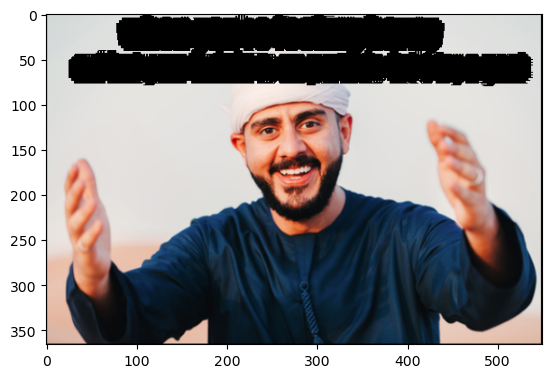

In [21]:
plt.imshow(Image.open(os.path.join(data_dir, 'img_mask_3px', image_name)).convert('RGB'))

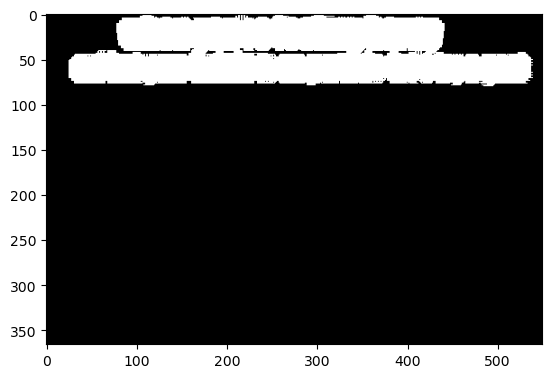

In [22]:
plt.imshow(Image.open(os.path.join(data_dir, 'img_mask_3px', image_name.replace('.png','.mask.png'))).convert('RGB'))
